# Laboratório 8
Material desenvolvido por Henrique Margotte e Aurora Pozo para a disciplina de Aprendizado de Máquina, para o curso de Informática Biomédica da UFPR, semestre 2025/2. Códigos baseados em exemplos da biblioteca scikit-learn e nos notebooks Python do livro "Inteligência Artificial: Uma Abordagem de Aprendizado de Máquina", 2ª edição.

# Exemplo 1: Agrupamento

Hoje veremos um pouco sobre aprendizado não supervisionado, por meio de algoritmos de Agrupamento, ou *Clustering*. Esse tipo de algoritmo se baseia na criação de grupos de dados, de forma que dados similares estejam em um mesmo grupo, ou *cluster*, e dados diferentes estejam em grupos distantes. Há diversas formas de se fazer isso, e veremos algumas a seguir.

Mas, o ponto principal desse algoritmo é que não sabemos os grupos, apenas deixamos o modelo separá-los a partir de alguma métrica estipulada, diferente de um algoritmo de classificação que possui uma taxa de acerto.

## Exemplo 1.1: Visualizando a Base
Antes de vermos os algoritmos, vamos preparar e explorar a base de dados `digits` para podermos utilizá-la em cluster. Por exemplo, podemos tentar agrupar as imagens que contém os mesmos números, mas sem saber qual número é qual! Para visualizar em um gráfico de duas dimensões, podemos utilizar tanto o PCA quanto o t-SNE.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

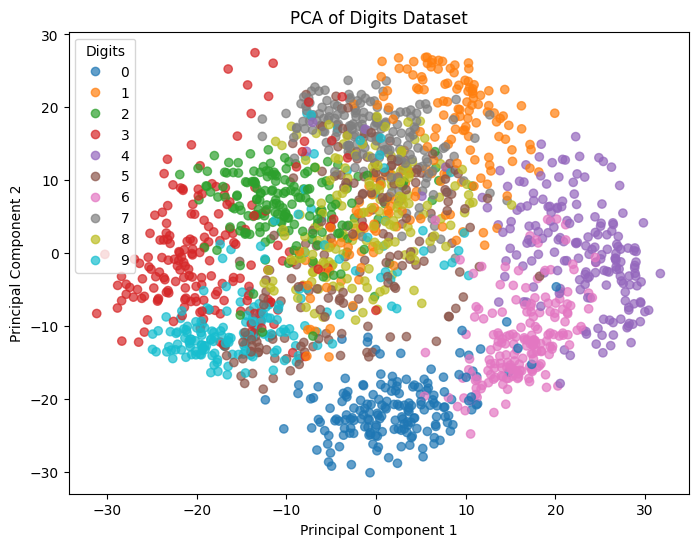

In [ ]:
# Visualizando com PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(digits.data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=digits.target, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("PCA of Digits Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

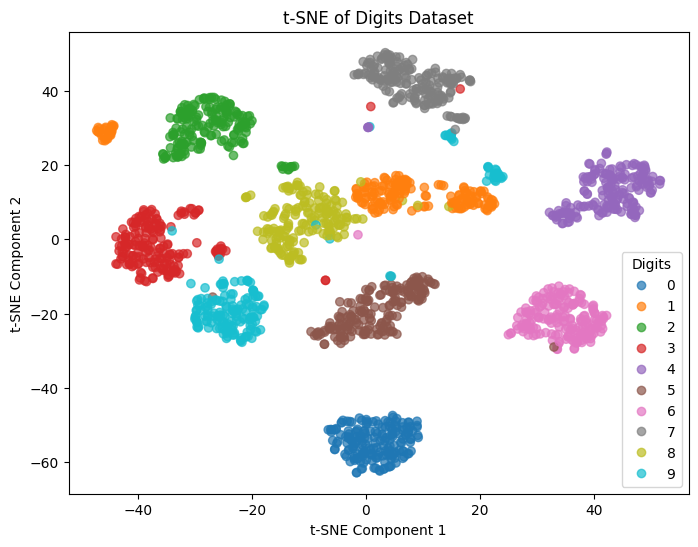

In [ ]:
# Visualizando com TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=digits.target, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Podemos observar que o t-SNE nesse caso consegue separar os dados em grupos mais definidos, mas o PCA também apresenta regiões de uma mesma classe. Nossa ideia é que os clusters consigam identificar essas regiões por si só e como pertencentes à mesma classe!

## Exemplo 1.2: Baseados em Erro Quadrático: k-Médias
O algoritmo de k-Médias, ou *k-Means*, se baseia na seleção de `k` centroides, que servirão como centro de cada cluster, atribuindo os elementos mais próximos a esse centroide como pertencente ao respectivo cluster. Então, é calculado o erro quadrático entre todos os elementos do cluster e o centroide, alterando-se os centroides a cada interação para minimizar esse erro.

Veremos um exemplo utilizando o `KMeans` do scikit-learn e visualizando com o t-SNE.

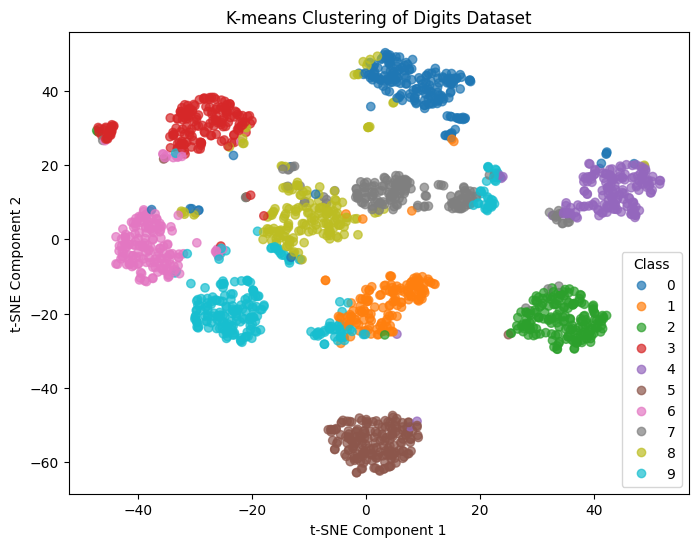

In [ ]:
# K-médias
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(digits.data)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("K-means Clustering of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Podemos também visualizar quais são os centroides definidos pelo k-Médias, e as imagens mais próximas a eles.

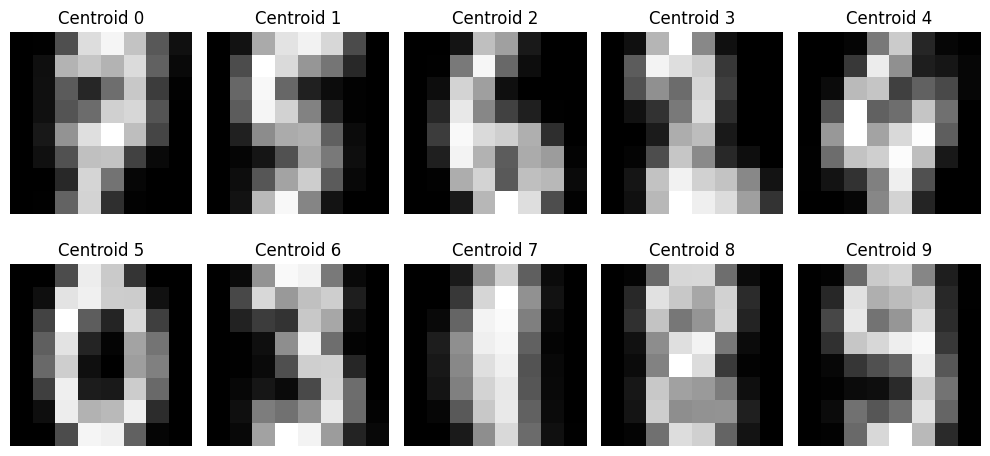

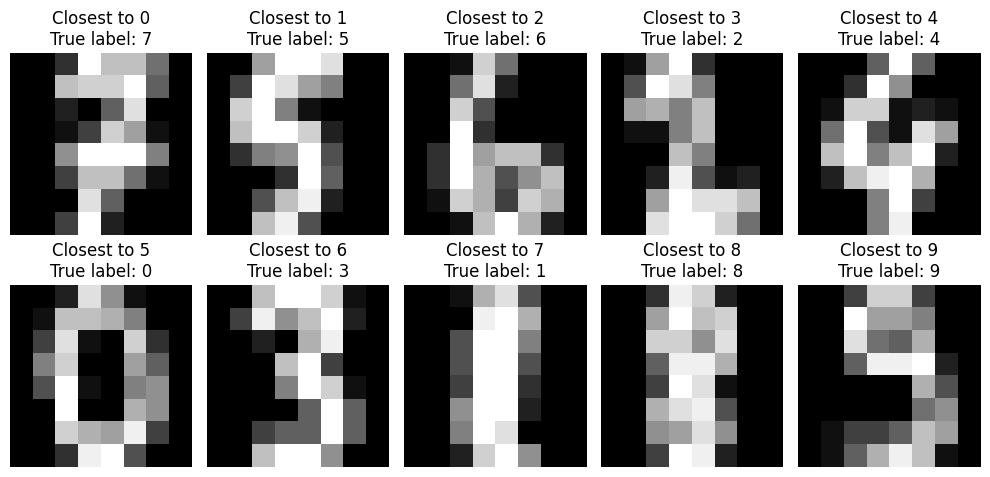

In [ ]:
# Visualizando os centroides
centroids = kmeans.cluster_centers_
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(centroids[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Centroid {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualizando as imagens mais próximas dos centroides with true labels
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(centroids, digits.data)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(digits.images[closest[i]], cmap='gray')
    ax.set_title(f'Closest to {i}\nTrue label: {digits.target[closest[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Como temos as classes definidas, podemos tentar verificar quanto nosso cluster separou adequadamente. Para isso, vamos definir a classe de cada cluster como a classe da imagem mais próxima a cada centroide, então, medir o erro de classificação.

In [ ]:
# Classificação baseada nos clusters
predicted_labels = np.zeros_like(labels)
for i in range(10):
    mask = (labels == i)
    if np.any(mask):
        closest_index = closest[i]
        predicted_labels[mask] = digits.target[closest_index]
accuracy = np.mean(predicted_labels == digits.target)
print(f'Acurácia de classificação baseada em clusters: {accuracy * 100:.2f}%')

Acurácia de classificação baseada em clusters: 86.14%


Isso seria uma tentativa de resolver um problema de classificação com clusters, que não se caracteriza como seu principal uso não supervisionado, mas nos dá uma ideia de como o modelo funciona. Veremos outros exemplo na mesma base.

## Exemplo 1.3: Baseados em Densidade: DBSCAN

O DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) é um algoritmo baseado em densidade. Ele identifica as regiões de maior densidade de dados e as define como clusters, encontrando pontos de menor densidade e os classificando como ruído. Diferente do k-Médias, o algoritmo define a quantidade de clusters, utilizando como base a distância entre os centros de densidade.

Veremos um exemplo utilizando o `DBSCAN` do scikit-learn. O hiperparâmetro `eps` define a distância máxima entre dois elementos para serem considerados vizinhos, já o `min_samples` define o número mínimo de vizinhos para formar uma região densa, elementos fora desse intervalo são considerados ruídos (Classe -1). O ajuste desses hiperparâmetros pode influenciar bastante o modelo, ainda mais em altas dimensões. Como exemplo, utilizaremos o DBSCAN aplicado na transformação 2D do t-SNE.

Número de clusters encontrados pelo DBSCAN: 9


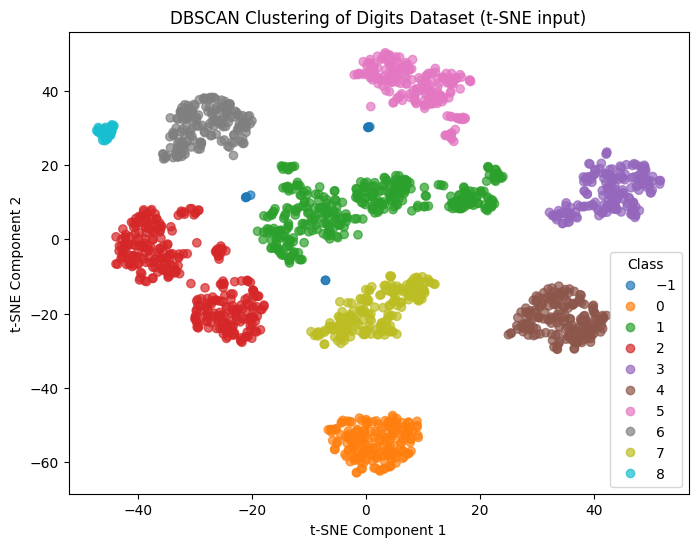

In [ ]:
# DBSCAN on t-SNE embedding
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=5)
dbscan.fit(data_tsne)  # use the 2D t-SNE representation instead of the raw pixels
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f'Número de clusters encontrados pelo DBSCAN: {n_clusters}')
db_labels = dbscan.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=db_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("DBSCAN Clustering of Digits Dataset (t-SNE input)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

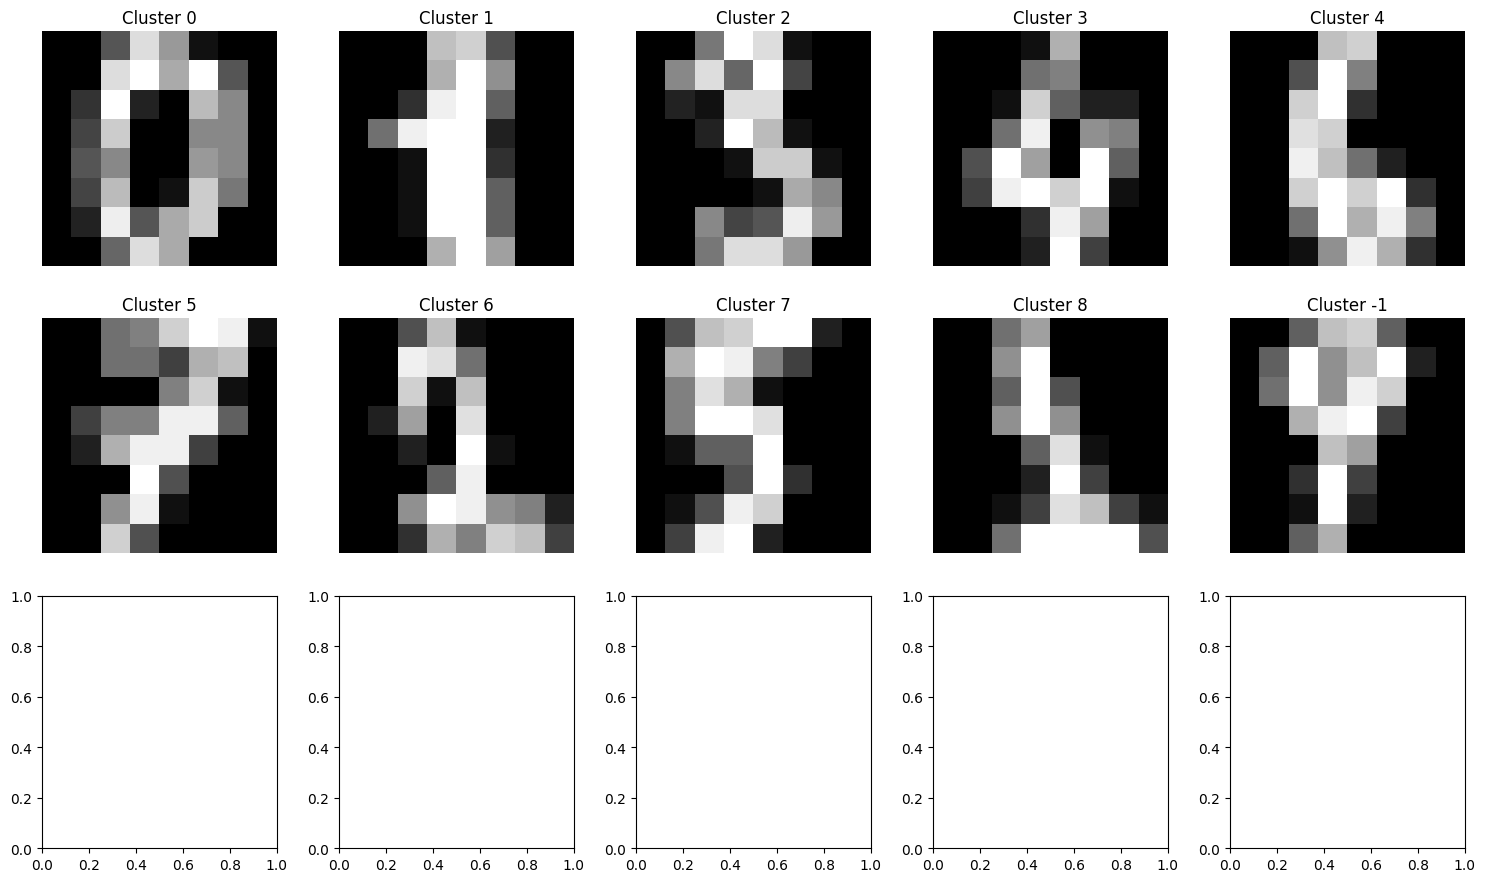

In [ ]:
# Visualizando alguns elementos de cada cluster DBSCAN
unique_labels = set(db_labels)
fig, axes = plt.subplots(len(unique_labels) // 5 + 1, 5, figsize=(15, 3 * (len(unique_labels) // 5 + 1)))
for i, label in enumerate(unique_labels):
    cluster_indices = np.where(db_labels == label)[0]
    if len(cluster_indices) > 0:
        sample_index = cluster_indices[0]
        ax = axes.flatten()[i]
        ax.imshow(digits.images[sample_index], cmap='gray')
        ax.set_title(f'Cluster {label}')
        ax.axis('off')
plt.tight_layout()
plt.show()


## Exemplo 1.4: Baseados em Grafo: Cluster Espectral

Outro exemplo de tipo de cluster são os baseados em grafos. Eles definem cada elemento como um nó do grafo, os conectando com arestas. Então, as arestas são removidas com base em critérios estipulados, até se formar núcleos representando os clusters.

Veremos um exemplo com `SpectralClustering`.

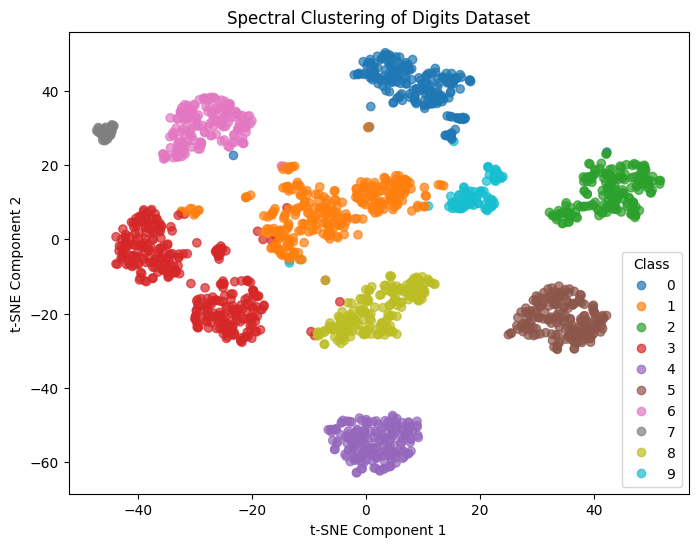

In [ ]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(digits.data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=spectral_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("Spectral Clustering of Digits Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Exercício!

SUA VEZ!

Agora, vamos por os conhecimentos em prática com clusters! Baixe a base de dados `selected_images.pkl` e faça os seguintes procedimentos:
- Explore a base como quiser! Utilizando t-SNE e PCA para visualizar.
- Tente encontrar um número de classes utilizando k-Médias e SpectralClustering.
  - Você pode aplicar técnicas de redução de dimensionalidade para auxiliar!
- Tente encontrar uma configuração de hiperparâmetros que dê um bom resultado com DBSCAN!

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

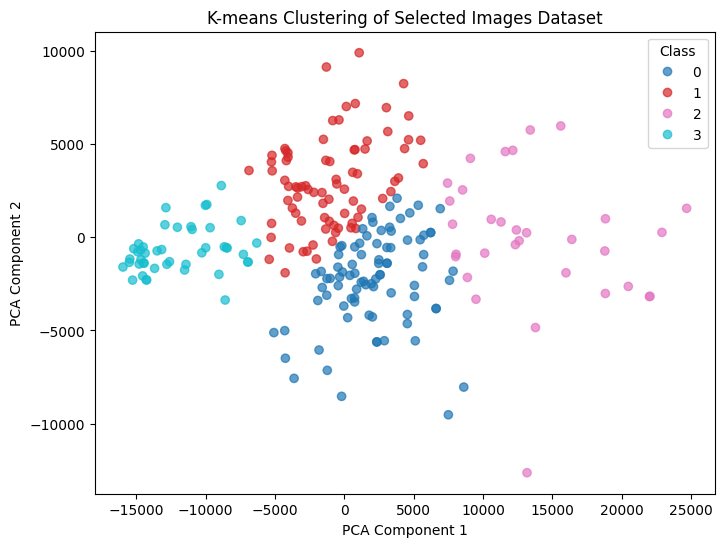


Data points in each cluster:
Cluster 2:
##################################################


array([[[150, 156, 135],
        [147, 154, 140],
        [157, 163, 151],
        ...,
        [204, 208, 212],
        [207, 214, 215],
        [200, 208, 211]],

       [[145, 150, 138],
        [148, 153, 152],
        [164, 173, 167],
        ...,
        [206, 210, 209],
        [204, 209, 213],
        [203, 211, 214]],

       [[184, 190, 181],
        [180, 188, 188],
        [175, 183, 183],
        ...,
        [206, 211, 212],
        [205, 211, 214],
        [207, 214, 216]],

       ...,

       [[181, 184, 171],
        [170, 176, 161],
        [166, 170, 149],
        ...,
        [168, 163, 135],
        [170, 169, 145],
        [171, 167, 141]],

       [[173, 173, 162],
        [161, 167, 145],
        [117, 124,  99],
        ...,
        [171, 164, 126],
        [170, 167, 133],
        [178, 177, 151]],

       [[171, 173, 144],
        [123, 129,  98],
        [ 39,  41,  36],
        ...,
        [179, 181, 156],
        [177, 181, 154],
        [174, 176, 153]]], dtype=uint8)
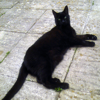

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
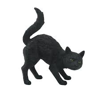

array([[[124,  39,   2],
        [124,  39,   2],
        [124,  39,   2],
        ...,
        [168, 150,  88],
        [168, 150,  88],
        [168, 150,  88]],

       [[123,  39,   2],
        [123,  39,   2],
        [123,  39,   2],
        ...,
        [172, 154,  92],
        [171, 153,  91],
        [171, 153,  91]],

       [[122,  40,   0],
        [121,  39,   0],
        [121,  39,   0],
        ...,
        [177, 159,  97],
        [176, 158,  96],
        [175, 157,  95]],

       ...,

       [[207, 202, 144],
        [207, 202, 144],
        [206, 201, 143],
        ...,
        [243, 228, 173],
        [236, 221, 166],
        [232, 217, 162]],

       [[206, 201, 143],
        [205, 200, 142],
        [205, 200, 142],
        ...,
        [241, 226, 171],
        [234, 219, 164],
        [230, 215, 160]],

       [[205, 200, 142],
        [204, 199, 141],
        [204, 199, 141],
        ...,
        [241, 226, 171],
        [234, 219, 164],
        [230, 215, 160]]], dtype=uint8)
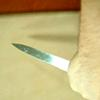

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [250, 255, 252],
        [255, 254, 249],
        [255, 253, 251]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [250, 254, 252],
        [255, 255, 252],
        [255, 254, 252]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [250, 253, 251],
        [254, 255, 254],
        [255, 255, 254]],

       ...,

       [[253, 251, 252],
        [250, 249, 250],
        [248, 249, 250],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[252, 252, 253],
        [251, 251, 253],
        [251, 252, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
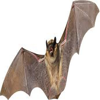

array([[[217, 153,  98],
        [164,  90,  35],
        [162,  89,  34],
        ...,
        [222, 222, 222],
        [225, 225, 225],
        [244, 244, 244]],

       [[176, 102,  47],
        [167,  94,  39],
        [162,  89,  34],
        ...,
        [225, 225, 225],
        [223, 223, 223],
        [229, 229, 229]],

       [[173, 100,  45],
        [172,  99,  44],
        [167,  94,  39],
        ...,
        [223, 223, 223],
        [224, 224, 224],
        [220, 220, 220]],

       ...,

       [[194, 140,  97],
        [208, 139,  86],
        [195, 143, 104],
        ...,
        [198, 157, 122],
        [188, 149, 118],
        [179, 149, 125]],

       [[194, 144, 108],
        [204, 136,  84],
        [181, 130,  93],
        ...,
        [198, 154, 119],
        [189, 151, 121],
        [192, 168, 149]],

       [[218, 178, 150],
        [185, 120,  75],
        [174, 122,  89],
        ...,
        [197, 153, 116],
        [193, 154, 124],
        [232, 213, 197]]], dtype=uint8)
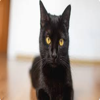

array([[[109,  93, 106],
        [109,  93, 106],
        [107,  93, 106],
        ...,
        [144, 138, 126],
        [143, 137, 125],
        [141, 135, 123]],

       [[ 98,  83,  96],
        [ 97,  82,  95],
        [102,  88, 101],
        ...,
        [144, 138, 126],
        [143, 137, 125],
        [142, 136, 124]],

       [[104,  90, 103],
        [ 97,  83,  96],
        [ 97,  85,  97],
        ...,
        [144, 138, 126],
        [143, 137, 125],
        [142, 136, 124]],

       ...,

       [[169, 159, 157],
        [166, 156, 154],
        [162, 153, 148],
        ...,
        [150, 145, 151],
        [153, 148, 154],
        [152, 146, 152]],

       [[170, 160, 159],
        [168, 158, 157],
        [164, 154, 151],
        ...,
        [136, 131, 138],
        [142, 137, 143],
        [144, 138, 144]],

       [[178, 168, 167],
        [177, 167, 167],
        [170, 160, 160],
        ...,
        [127, 122, 129],
        [136, 131, 138],
        [140, 134, 141]]], dtype=uint8)
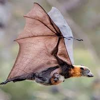

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
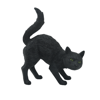

array([[[186, 179, 180],
        [172, 168, 162],
        [147, 147, 128],
        ...,
        [177, 161, 153],
        [157, 137, 130],
        [121, 103,  98]],

       [[177, 172, 175],
        [164, 162, 157],
        [142, 143, 126],
        ...,
        [126, 113, 106],
        [145, 130, 125],
        [161, 147, 145]],

       [[165, 163, 168],
        [156, 155, 152],
        [137, 139, 125],
        ...,
        [168, 160, 154],
        [176, 168, 165],
        [185, 178, 179]],

       ...,

       [[173, 188, 207],
        [177, 189, 205],
        [178, 190, 209],
        ...,
        [195, 211, 234],
        [195, 211, 234],
        [195, 211, 234]],

       [[180, 197, 218],
        [182, 195, 213],
        [180, 192, 212],
        ...,
        [195, 211, 234],
        [195, 211, 234],
        [195, 211, 234]],

       [[186, 203, 225],
        [190, 200, 228],
        [188, 198, 221],
        ...,
        [195, 211, 234],
        [195, 211, 234],
        [195, 211, 234]]], dtype=uint8)
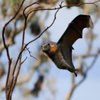

array([[[251, 203, 131],
        [250, 202, 130],
        [250, 201, 134],
        ...,
        [125, 108, 118],
        [124, 107, 117],
        [123, 106, 116]],

       [[244, 195, 126],
        [243, 194, 125],
        [243, 194, 127],
        ...,
        [121, 104, 112],
        [119, 102, 112],
        [118, 101, 109]],

       [[238, 191, 123],
        [238, 190, 124],
        [237, 189, 125],
        ...,
        [117, 102, 107],
        [116, 101, 108],
        [114,  99, 104]],

       ...,

       [[165, 155, 145],
        [162, 155, 147],
        [143, 143, 143],
        ...,
        [ 48,  57,  74],
        [ 50,  59,  76],
        [ 47,  56,  73]],

       [[152, 142, 132],
        [149, 142, 134],
        [130, 130, 130],
        ...,
        [ 48,  57,  74],
        [ 50,  59,  76],
        [ 47,  56,  73]],

       [[145, 135, 125],
        [142, 135, 127],
        [122, 122, 122],
        ...,
        [ 51,  60,  77],
        [ 53,  62,  79],
        [ 50,  59,  76]]], dtype=uint8)
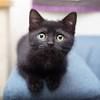

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
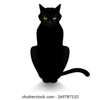

array([[[237, 237, 237],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [233, 233, 233],
        [232, 232, 232],
        [232, 232, 232]],

       [[237, 237, 237],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [233, 233, 233],
        [232, 232, 232],
        [232, 232, 232]],

       [[236, 236, 236],
        [237, 237, 237],
        [239, 239, 239],
        ...,
        [233, 233, 233],
        [233, 233, 233],
        [233, 233, 233]],

       ...,

       [[207, 207, 207],
        [207, 207, 207],
        [208, 208, 208],
        ...,
        [197, 197, 197],
        [197, 197, 197],
        [196, 196, 196]],

       [[205, 205, 205],
        [205, 205, 205],
        [205, 205, 205],
        ...,
        [194, 194, 194],
        [194, 194, 194],
        [193, 193, 193]],

       [[202, 202, 202],
        [203, 203, 203],
        [203, 203, 203],
        ...,
        [190, 190, 190],
        [190, 190, 190],
        [190, 190, 190]]], dtype=uint8)
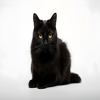

array([[[231, 231, 231],
        [232, 232, 232],
        [232, 232, 232],
        ...,
        [232, 232, 232],
        [232, 232, 232],
        [232, 232, 232]],

       [[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [236, 236, 236]],

       [[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [236, 236, 236]],

       ...,

       [[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [237, 237, 237]],

       [[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [237, 237, 237],
        [237, 237, 237],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [235, 235, 235]]], dtype=uint8)
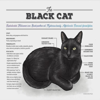

array([[[235, 235, 235],
        [234, 234, 234],
        [233, 233, 233],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [242, 242, 242]],

       [[231, 231, 231],
        [235, 235, 235],
        [238, 238, 238],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [242, 242, 242]],

       [[236, 236, 236],
        [237, 237, 237],
        [239, 239, 239],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [242, 242, 242]],

       ...,

       [[232, 232, 232],
        [232, 232, 232],
        [231, 231, 231],
        ...,
        [247, 241, 237],
        [246, 240, 236],
        [246, 241, 236]],

       [[232, 232, 232],
        [232, 232, 232],
        [231, 231, 231],
        ...,
        [247, 240, 234],
        [247, 240, 234],
        [248, 242, 236]],

       [[232, 232, 232],
        [232, 232, 232],
        [231, 231, 231],
        ...,
        [249, 242, 236],
        [244, 220, 216],
        [235, 181, 183]]], dtype=uint8)
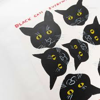

array([[[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]]], dtype=uint8)
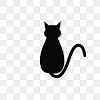

array([[[217, 218, 221],
        [227, 228, 232],
        [223, 224, 226],
        ...,
        [167, 151, 129],
        [164, 153, 138],
        [154, 147, 134]],

       [[213, 214, 217],
        [227, 228, 231],
        [222, 223, 225],
        ...,
        [168, 152, 131],
        [167, 156, 141],
        [156, 149, 136]],

       [[209, 210, 212],
        [226, 227, 230],
        [222, 223, 225],
        ...,
        [169, 153, 132],
        [169, 158, 142],
        [159, 151, 139]],

       ...,

       [[223, 216, 197],
        [228, 219, 201],
        [229, 218, 201],
        ...,
        [232, 227, 209],
        [231, 227, 211],
        [231, 230, 215]],

       [[224, 216, 197],
        [228, 219, 200],
        [231, 220, 202],
        ...,
        [232, 225, 207],
        [233, 227, 210],
        [234, 229, 213]],

       [[227, 219, 200],
        [227, 218, 199],
        [231, 220, 202],
        ...,
        [232, 225, 207],
        [234, 227, 208],
        [235, 228, 210]]], dtype=uint8)
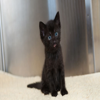

array([[[161, 102,  60],
        [186, 117,  62],
        [183, 113,  55],
        ...,
        [211, 204, 195],
        [211, 203, 195],
        [210, 202, 193]],

       [[169, 107,  61],
        [184, 116,  62],
        [179, 110,  53],
        ...,
        [214, 208, 200],
        [213, 208, 199],
        [213, 206, 199]],

       [[175, 111,  62],
        [184, 114,  60],
        [177, 109,  53],
        ...,
        [214, 209, 203],
        [213, 208, 202],
        [214, 208, 201]],

       ...,

       [[191, 137,  96],
        [192, 140,  98],
        [193, 139,  97],
        ...,
        [174, 136, 106],
        [172, 132, 103],
        [165, 126,  99]],

       [[191, 137,  93],
        [190, 137,  94],
        [192, 139,  96],
        ...,
        [173, 134, 106],
        [182, 143, 110],
        [179, 139, 107]],

       [[192, 136,  91],
        [193, 140,  95],
        [198, 145,  98],
        ...,
        [162, 125,  99],
        [166, 126, 100],
        [172, 131, 101]]], dtype=uint8)
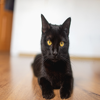

array([[[191, 251, 255],
        [191, 251, 255],
        [191, 251, 255],
        ...,
        [162, 153, 136],
        [157, 148, 131],
        [155, 146, 129]],

       [[191, 251, 255],
        [192, 252, 255],
        [192, 253, 255],
        ...,
        [161, 152, 135],
        [156, 147, 130],
        [153, 144, 127]],

       [[192, 252, 255],
        [192, 253, 255],
        [192, 253, 255],
        ...,
        [161, 152, 135],
        [156, 147, 130],
        [153, 144, 127]],

       ...,

       [[223, 169, 143],
        [224, 170, 144],
        [219, 165, 141],
        ...,
        [ 91,  64,  53],
        [ 86,  59,  48],
        [ 87,  60,  49]],

       [[223, 169, 143],
        [222, 168, 142],
        [214, 160, 136],
        ...,
        [ 88,  61,  50],
        [ 87,  60,  49],
        [ 90,  63,  52]],

       [[221, 167, 141],
        [220, 166, 140],
        [211, 157, 133],
        ...,
        [ 89,  62,  51],
        [ 89,  62,  51],
        [ 93,  66,  55]]], dtype=uint8)
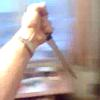

array([[[187, 197, 206],
        [191, 201, 210],
        [195, 205, 215],
        ...,
        [170, 175, 215],
        [163, 168, 208],
        [159, 164, 204]],

       [[188, 198, 208],
        [190, 200, 210],
        [193, 203, 213],
        ...,
        [163, 179, 213],
        [155, 171, 207],
        [149, 165, 199]],

       [[188, 198, 210],
        [189, 199, 211],
        [190, 200, 212],
        ...,
        [151, 187, 213],
        [143, 178, 206],
        [137, 173, 199]],

       ...,

       [[113,  56,  49],
        [108,  55,  47],
        [103,  54,  47],
        ...,
        [148, 128, 117],
        [147, 127, 116],
        [147, 127, 116]],

       [[112,  55,  48],
        [107,  54,  46],
        [101,  52,  45],
        ...,
        [131, 111, 100],
        [131, 111, 100],
        [130, 110,  99]],

       [[113,  56,  49],
        [107,  54,  46],
        [101,  52,  45],
        ...,
        [120, 100,  89],
        [119,  99,  88],
        [119,  99,  88]]], dtype=uint8)

array([[[201, 183, 163],
        [205, 187, 167],
        [210, 193, 173],
        ...,
        [241, 241, 237],
        [238, 235, 230],
        [232, 220, 210]],

       [[203, 185, 165],
        [208, 190, 170],
        [213, 195, 175],
        ...,
        [241, 240, 237],
        [236, 233, 227],
        [228, 215, 202]],

       [[207, 189, 169],
        [211, 193, 173],
        [214, 197, 177],
        ...,
        [241, 239, 237],
        [235, 229, 222],
        [224, 210, 192]],

       ...,

       [[249, 249, 249],
        [248, 248, 247],
        [248, 248, 246],
        ...,
        [212, 184, 161],
        [213, 183, 159],
        [212, 182, 156]],

       [[249, 249, 249],
        [248, 248, 247],
        [247, 247, 245],
        ...,
        [213, 184, 160],
        [213, 183, 158],
        [213, 183, 157]],

       [[249, 249, 249],
        [248, 248, 247],
        [247, 247, 245],
        ...,
        [213, 184, 161],
        [213, 183, 158],
        [214, 184, 158]]], dtype=uint8)
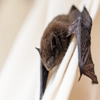

array([[[167, 168, 188],
        [167, 170, 188],
        [170, 173, 192],
        ...,
        [136, 131, 125],
        [110, 102, 100],
        [107,  99,  97]],

       [[167, 168, 188],
        [168, 170, 188],
        [171, 174, 193],
        ...,
        [144, 137, 134],
        [114, 105, 104],
        [104,  96,  94]],

       [[167, 168, 188],
        [168, 170, 188],
        [171, 174, 193],
        ...,
        [150, 142, 138],
        [121, 112, 109],
        [105,  97,  95]],

       ...,

       [[193, 191, 208],
        [185, 184, 199],
        [202, 201, 215],
        ...,
        [163, 158, 180],
        [168, 161, 183],
        [182, 179, 201]],

       [[183, 180, 198],
        [193, 193, 206],
        [180, 179, 197],
        ...,
        [186, 184, 202],
        [191, 188, 207],
        [160, 154, 179]],

       [[173, 171, 190],
        [185, 186, 201],
        [178, 177, 194],
        ...,
        [180, 177, 196],
        [188, 186, 204],
        [174, 168, 191]]], dtype=uint8)
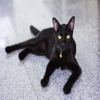

array([[[223, 232, 239],
        [224, 233, 240],
        [225, 234, 241],
        ...,
        [198, 230, 187],
        [191, 212, 215],
        [167, 182, 189]],

       [[224, 233, 240],
        [224, 233, 240],
        [225, 234, 241],
        ...,
        [125, 159,  78],
        [141, 164, 129],
        [ 74,  82,  86]],

       [[225, 234, 241],
        [225, 234, 241],
        [227, 236, 243],
        ...,
        [161, 186, 142],
        [ 64,  80,  50],
        [101, 101, 104]],

       ...,

       [[231, 240, 247],
        [231, 240, 247],
        [231, 240, 247],
        ...,
        [123, 156, 101],
        [ 79, 110,  59],
        [ 65,  99,  38]],

       [[231, 240, 247],
        [231, 240, 247],
        [231, 240, 247],
        ...,
        [ 40,  76,  10],
        [ 58,  90,  28],
        [ 42,  73,  11]],

       [[231, 240, 246],
        [231, 240, 247],
        [231, 240, 248],
        ...,
        [ 47,  78,   9],
        [ 61,  91,  26],
        [ 50,  80,   8]]], dtype=uint8)
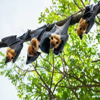

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [254, 254, 254],
        [243, 239, 236]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [240, 239, 235],
        [215, 207, 198],
        [182, 165, 152]],

       [[254, 254, 254],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [172, 152, 137],
        [133,  98,  81],
        [117,  76,  58]],

       ...,

       [[250, 250, 248],
        [250, 250, 248],
        [250, 250, 248],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[249, 249, 248],
        [250, 250, 249],
        [250, 250, 248],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[250, 250, 249],
        [250, 250, 249],
        [250, 250, 248],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]]], dtype=uint8)
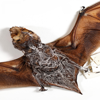

array([[[ 65,  25,  49],
        [ 67,  28,  49],
        [ 68,  29,  50],
        ...,
        [255, 253, 242],
        [255, 254, 242],
        [255, 254, 242]],

       [[ 66,  26,  50],
        [ 68,  29,  50],
        [ 69,  30,  49],
        ...,
        [255, 253, 241],
        [255, 254, 242],
        [255, 254, 241]],

       [[ 67,  28,  49],
        [ 68,  29,  50],
        [ 68,  29,  48],
        ...,
        [255, 254, 239],
        [255, 253, 241],
        [255, 254, 239]],

       ...,

       [[255, 208, 179],
        [255, 204, 175],
        [239, 189, 164],
        ...,
        [146, 125, 108],
        [154, 133, 116],
        [159, 138, 121]],

       [[254, 203, 174],
        [247, 196, 167],
        [227, 177, 152],
        ...,
        [151, 130, 113],
        [157, 136, 119],
        [161, 140, 123]],

       [[253, 202, 173],
        [243, 192, 163],
        [219, 169, 144],
        ...,
        [154, 133, 116],
        [159, 138, 121],
        [162, 141, 124]]], dtype=uint8)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
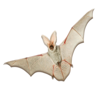

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
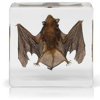

array([[[ 96,  62,  78],
        [ 99,  65,  81],
        [106,  72,  86],
        ...,
        [249, 237, 197],
        [247, 235, 195],
        [247, 235, 195]],

       [[ 97,  63,  79],
        [100,  66,  82],
        [104,  70,  86],
        ...,
        [249, 237, 197],
        [248, 236, 196],
        [248, 236, 196]],

       [[ 98,  64,  81],
        [ 99,  65,  82],
        [101,  67,  84],
        ...,
        [250, 238, 198],
        [248, 236, 196],
        [248, 236, 196]],

       ...,

       [[180, 147, 128],
        [175, 142, 123],
        [171, 134, 118],
        ...,
        [101,  84,  77],
        [ 92,  75,  68],
        [ 85,  68,  61]],

       [[173, 140, 121],
        [168, 135, 116],
        [163, 126, 110],
        ...,
        [ 99,  82,  75],
        [ 90,  73,  66],
        [ 84,  67,  60]],

       [[169, 136, 117],
        [164, 131, 112],
        [158, 121, 105],
        ...,
        [ 96,  79,  72],
        [ 89,  72,  65],
        [ 83,  66,  59]]], dtype=uint8)
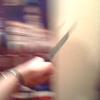

array([[[229, 242, 154],
        [224, 238, 160],
        [218, 233, 179],
        ...,
        [247, 247, 250],
        [246, 245, 250],
        [246, 245, 250]],

       [[228, 239, 158],
        [222, 236, 164],
        [215, 229, 180],
        ...,
        [247, 247, 251],
        [246, 245, 250],
        [246, 245, 250]],

       [[226, 238, 153],
        [218, 233, 163],
        [211, 226, 183],
        ...,
        [247, 247, 251],
        [246, 245, 250],
        [246, 245, 250]],

       ...,

       [[229, 232, 216],
        [234, 237, 218],
        [235, 238, 218],
        ...,
        [211, 211, 221],
        [212, 211, 222],
        [208, 206, 217]],

       [[223, 226, 208],
        [228, 231, 210],
        [234, 238, 217],
        ...,
        [208, 208, 219],
        [212, 211, 222],
        [210, 208, 220]],

       [[219, 224, 205],
        [222, 227, 205],
        [231, 235, 217],
        ...,
        [206, 206, 218],
        [207, 206, 218],
        [203, 201, 214]]], dtype=uint8)
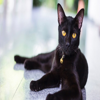

array([[[190, 228, 247],
        [190, 228, 247],
        [190, 228, 247],
        ...,
        [201, 229, 250],
        [201, 229, 250],
        [201, 229, 250]],

       [[190, 228, 247],
        [190, 228, 247],
        [190, 228, 247],
        ...,
        [201, 229, 250],
        [201, 229, 250],
        [201, 229, 250]],

       [[190, 228, 247],
        [190, 228, 247],
        [190, 228, 247],
        ...,
        [201, 229, 250],
        [201, 229, 250],
        [201, 229, 250]],

       ...,

       [[194, 229, 249],
        [194, 229, 249],
        [194, 229, 249],
        ...,
        [202, 230, 251],
        [201, 229, 250],
        [201, 229, 250]],

       [[194, 229, 249],
        [194, 229, 249],
        [194, 229, 249],
        ...,
        [200, 228, 249],
        [201, 229, 250],
        [201, 229, 250]],

       [[194, 229, 249],
        [194, 229, 249],
        [194, 229, 249],
        ...,
        [200, 228, 249],
        [201, 229, 250],
        [201, 229, 250]]], dtype=uint8)

array([[[191, 218, 255],
        [186, 217, 255],
        [180, 219, 255],
        ...,
        [ 72,  42,  50],
        [ 72,  42,  50],
        [ 72,  42,  50]],

       [[182, 205, 247],
        [183, 211, 251],
        [185, 220, 255],
        ...,
        [ 68,  38,  46],
        [ 68,  38,  46],
        [ 68,  38,  46]],

       [[200, 219, 252],
        [195, 215, 248],
        [183, 212, 242],
        ...,
        [ 70,  40,  48],
        [ 69,  39,  47],
        [ 70,  40,  48]],

       ...,

       [[188, 165, 147],
        [188, 165, 147],
        [188, 162, 147],
        ...,
        [181, 155, 130],
        [182, 156, 131],
        [183, 157, 132]],

       [[186, 163, 145],
        [185, 162, 144],
        [186, 160, 145],
        ...,
        [181, 155, 130],
        [182, 156, 131],
        [183, 157, 132]],

       [[186, 163, 145],
        [185, 162, 144],
        [186, 160, 145],
        ...,
        [182, 156, 131],
        [183, 157, 132],
        [183, 157, 132]]], dtype=uint8)

array([[[223, 219, 210],
        [225, 221, 212],
        [228, 224, 215],
        ...,
        [230, 221, 212],
        [231, 222, 213],
        [220, 211, 202]],

       [[222, 218, 209],
        [225, 221, 212],
        [228, 224, 215],
        ...,
        [222, 213, 204],
        [224, 215, 206],
        [225, 216, 207]],

       [[221, 217, 208],
        [224, 220, 211],
        [227, 223, 214],
        ...,
        [207, 198, 189],
        [216, 207, 198],
        [221, 212, 203]],

       ...,

       [[210, 205, 199],
        [206, 201, 195],
        [203, 198, 192],
        ...,
        [224, 217, 209],
        [216, 209, 201],
        [213, 209, 200]],

       [[204, 199, 193],
        [205, 200, 194],
        [206, 201, 195],
        ...,
        [224, 216, 208],
        [213, 206, 198],
        [213, 208, 200]],

       [[208, 204, 195],
        [202, 198, 189],
        [204, 200, 191],
        ...,
        [211, 204, 196],
        [205, 198, 190],
        [212, 204, 196]]], dtype=uint8)

array([[[159, 114,  77],
        [155, 109,  75],
        [147, 104,  69],
        ...,
        [203, 170, 139],
        [199, 166, 135],
        [195, 162, 130]],

       [[157, 111,  76],
        [153, 107,  73],
        [145, 102,  69],
        ...,
        [204, 171, 141],
        [201, 168, 137],
        [196, 163, 131]],

       [[154, 108,  75],
        [150, 104,  72],
        [142,  99,  67],
        ...,
        [206, 173, 144],
        [202, 169, 139],
        [196, 164, 133]],

       ...,

       [[104,  82,  51],
        [111,  87,  53],
        [126,  99,  60],
        ...,
        [206, 166, 115],
        [204, 167, 115],
        [204, 168, 119]],

       [[101,  79,  48],
        [107,  84,  50],
        [122,  95,  58],
        ...,
        [207, 169, 118],
        [205, 170, 119],
        [204, 170, 122]],

       [[ 97,  75,  44],
        [103,  79,  47],
        [117,  91,  54],
        ...,
        [208, 170, 121],
        [207, 172, 123],
        [206, 173, 125]]], dtype=uint8)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
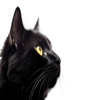

Cluster 0:
##################################################


array([[[133, 130, 139],
        [128, 126, 133],
        [127, 127, 131],
        ...,
        [ 44,  46,  61],
        [ 51,  53,  69],
        [ 52,  52,  68]],

       [[131, 129, 137],
        [130, 129, 135],
        [115, 115, 120],
        ...,
        [ 43,  45,  59],
        [ 46,  48,  63],
        [ 47,  47,  61]],

       [[125, 126, 134],
        [131, 132, 139],
        [123, 124, 130],
        ...,
        [ 46,  48,  61],
        [ 50,  51,  64],
        [ 49,  48,  61]],

       ...,

       [[160,  99, 111],
        [148,  93, 106],
        [122,  80,  94],
        ...,
        [ 98,  91, 134],
        [ 97,  90, 132],
        [ 99,  92, 134]],

       [[151,  95, 109],
        [134,  85,  99],
        [113,  80,  94],
        ...,
        [116, 110, 153],
        [125, 118, 161],
        [138, 131, 174]],

       [[142,  90, 103],
        [125,  81,  96],
        [117,  89, 104],
        ...,
        [137, 131, 175],
        [125, 118, 162],
        [122, 115, 159]]], dtype=uint8)
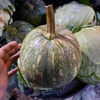

array([[[ 92,  68,  66],
        [ 96,  72,  70],
        [ 93,  69,  67],
        ...,
        [101,  84,  77],
        [101,  84,  77],
        [101,  84,  77]],

       [[ 93,  69,  67],
        [ 96,  72,  70],
        [ 93,  69,  67],
        ...,
        [102,  85,  77],
        [102,  85,  77],
        [102,  85,  77]],

       [[ 94,  70,  68],
        [ 97,  73,  71],
        [ 94,  70,  68],
        ...,
        [103,  86,  76],
        [103,  86,  76],
        [103,  86,  76]],

       ...,

       [[ 62, 100, 109],
        [ 63,  97, 107],
        [ 62,  85,  99],
        ...,
        [ 98,  72,  57],
        [101,  75,  60],
        [105,  79,  64]],

       [[ 66, 104, 113],
        [ 64,  98, 108],
        [ 68,  91, 105],
        ...,
        [103,  77,  62],
        [103,  77,  62],
        [105,  79,  64]],

       [[ 65, 103, 112],
        [ 61,  95, 105],
        [ 70,  93, 107],
        ...,
        [108,  82,  67],
        [105,  79,  64],
        [105,  79,  64]]], dtype=uint8)
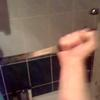

array([[[227, 227, 226],
        [228, 228, 229],
        [229, 229, 231],
        ...,
        [167, 181, 193],
        [167, 181, 192],
        [167, 181, 192]],

       [[227, 227, 226],
        [228, 228, 229],
        [229, 229, 231],
        ...,
        [167, 181, 193],
        [167, 181, 192],
        [166, 180, 191]],

       [[227, 227, 226],
        [228, 228, 229],
        [229, 229, 230],
        ...,
        [167, 181, 192],
        [167, 181, 192],
        [166, 180, 191]],

       ...,

       [[224, 215, 206],
        [220, 212, 203],
        [234, 229, 222],
        ...,
        [125, 152, 171],
        [125, 152, 171],
        [126, 153, 172]],

       [[218, 212, 199],
        [225, 219, 208],
        [238, 235, 230],
        ...,
        [125, 151, 171],
        [126, 153, 172],
        [127, 154, 173]],

       [[235, 234, 229],
        [237, 235, 229],
        [238, 237, 233],
        ...,
        [125, 151, 170],
        [126, 153, 172],
        [128, 155, 174]]], dtype=uint8)
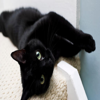

array([[[136, 157, 101],
        [136, 157, 101],
        [136, 157, 101],
        ...,
        [166, 145,  88],
        [179, 158, 101],
        [179, 158, 101]],

       [[136, 157, 101],
        [136, 157, 101],
        [136, 157, 101],
        ...,
        [172, 151,  94],
        [180, 159, 102],
        [179, 158, 101]],

       [[137, 158, 102],
        [137, 158, 102],
        [137, 158, 102],
        ...,
        [177, 156,  99],
        [180, 159, 102],
        [177, 156,  99]],

       ...,

       [[131, 164, 109],
        [133, 166, 111],
        [137, 167, 113],
        ...,
        [197, 170, 117],
        [191, 164, 111],
        [187, 160, 107]],

       [[135, 168, 113],
        [137, 170, 115],
        [141, 171, 117],
        ...,
        [196, 169, 116],
        [191, 164, 111],
        [188, 161, 108]],

       [[136, 169, 114],
        [139, 172, 117],
        [144, 174, 120],
        ...,
        [196, 169, 116],
        [191, 164, 111],
        [188, 161, 108]]], dtype=uint8)
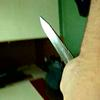

array([[[103, 103, 103],
        [112, 112, 115],
        [102, 103, 110],
        ...,
        [121, 125, 117],
        [104, 109, 103],
        [ 91,  98,  92]],

       [[ 89,  88,  84],
        [101, 101, 100],
        [ 81,  83,  88],
        ...,
        [ 91,  97,  90],
        [ 82,  90,  84],
        [ 77,  86,  81]],

       [[ 59,  60,  53],
        [ 52,  54,  51],
        [ 65,  68,  73],
        ...,
        [ 81,  91,  82],
        [ 80,  92,  85],
        [ 62,  73,  68]],

       ...,

       [[ 31,  32,  27],
        [ 29,  30,  25],
        [ 28,  29,  24],
        ...,
        [133, 112, 111],
        [152, 133, 132],
        [124, 106, 106]],

       [[ 30,  31,  26],
        [ 32,  33,  28],
        [ 31,  32,  27],
        ...,
        [132, 112, 109],
        [134, 114, 113],
        [138, 119, 118]],

       [[ 30,  31,  26],
        [ 32,  33,  28],
        [ 32,  33,  28],
        ...,
        [129, 109, 106],
        [107,  88,  84],
        [137, 119, 115]]], dtype=uint8)
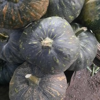

array([[[139, 127, 139],
        [137, 128, 139],
        [131, 126, 136],
        ...,
        [156, 168, 119],
        [109, 122,  75],
        [ 75,  91,  48]],

       [[132, 123, 134],
        [129, 121, 131],
        [129, 123, 134],
        ...,
        [104, 112,  70],
        [129, 139,  94],
        [115, 128,  82]],

       [[126, 121, 127],
        [122, 115, 123],
        [125, 116, 128],
        ...,
        [189, 193, 153],
        [153, 158, 112],
        [156, 165, 117]],

       ...,

       [[  6,   9,   9],
        [  6,   9,   8],
        [  6,   9,   8],
        ...,
        [175, 158, 156],
        [167, 149, 145],
        [165, 147, 142]],

       [[  6,  12,  10],
        [  6,  10,   9],
        [  6,  10,   9],
        ...,
        [175, 162, 161],
        [166, 150, 149],
        [151, 135, 134]],

       [[  6,  12,  10],
        [  5,  10,   9],
        [  6,  10,   9],
        ...,
        [141, 130, 129],
        [175, 161, 161],
        [165, 151, 151]]], dtype=uint8)
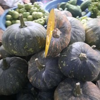

array([[[148, 124, 100],
        [152, 128, 102],
        [159, 133, 108],
        ...,
        [177, 159, 135],
        [173, 155, 131],
        [171, 153, 129]],

       [[151, 127, 103],
        [156, 132, 106],
        [163, 137, 110],
        ...,
        [179, 161, 137],
        [173, 155, 131],
        [169, 151, 127]],

       [[157, 133, 107],
        [162, 138, 112],
        [169, 145, 117],
        ...,
        [178, 160, 136],
        [173, 155, 131],
        [169, 151, 127]],

       ...,

       [[180, 146, 121],
        [180, 146, 121],
        [180, 146, 121],
        ...,
        [ 25,   0,   6],
        [ 24,   0,   5],
        [ 21,   0,   4]],

       [[180, 146, 121],
        [180, 146, 121],
        [180, 146, 121],
        ...,
        [ 24,   0,   5],
        [ 23,   0,   4],
        [ 20,   0,   3]],

       [[180, 146, 121],
        [180, 146, 121],
        [180, 146, 121],
        ...,
        [ 25,   0,   6],
        [ 24,   0,   5],
        [ 21,   0,   4]]], dtype=uint8)

array([[[131, 134,  91],
        [123, 127,  87],
        [110, 115,  79],
        ...,
        [110, 130, 116],
        [125, 144, 123],
        [ 97, 117,  90]],

       [[119, 123,  79],
        [117, 121,  78],
        [109, 114,  72],
        ...,
        [ 80, 100,  81],
        [ 90, 108,  85],
        [ 84, 104,  75]],

       [[109, 115,  74],
        [109, 115,  72],
        [108, 115,  68],
        ...,
        [ 41,  60,  36],
        [ 29,  47,  24],
        [ 44,  63,  37]],

       ...,

       [[132, 123, 122],
        [142, 132, 131],
        [146, 135, 133],
        ...,
        [139, 144, 128],
        [108, 108,  93],
        [122, 115, 104]],

       [[133, 121, 123],
        [148, 136, 138],
        [135, 123, 122],
        ...,
        [150, 153, 137],
        [113, 110,  96],
        [124, 115, 104]],

       [[126, 111, 116],
        [150, 138, 140],
        [134, 124, 123],
        ...,
        [142, 143, 128],
        [105, 101,  86],
        [111, 100,  90]]], dtype=uint8)
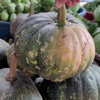

array([[[176, 161, 140],
        [176, 161, 140],
        [177, 162, 141],
        ...,
        [106, 138, 117],
        [116, 148, 127],
        [126, 158, 137]],

       [[176, 161, 140],
        [176, 161, 140],
        [176, 161, 140],
        ...,
        [111, 143, 122],
        [122, 151, 131],
        [131, 163, 142]],

       [[176, 161, 140],
        [176, 161, 140],
        [176, 161, 140],
        ...,
        [115, 144, 124],
        [125, 152, 133],
        [135, 164, 144]],

       ...,

       [[114,  94,  87],
        [112,  92,  83],
        [110,  90,  81],
        ...,
        [118, 134, 124],
        [116, 132, 122],
        [116, 132, 122]],

       [[112,  92,  85],
        [112,  92,  83],
        [111,  91,  82],
        ...,
        [116, 132, 122],
        [114, 130, 120],
        [114, 130, 120]],

       [[112,  92,  85],
        [112,  92,  83],
        [111,  91,  82],
        ...,
        [115, 131, 121],
        [113, 129, 119],
        [113, 129, 119]]], dtype=uint8)
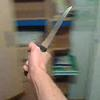

array([[[114, 108,  82],
        [117, 111,  85],
        [117, 112,  85],
        ...,
        [116, 120,  85],
        [110, 115,  79],
        [140, 142, 115]],

       [[115, 109,  82],
        [119, 113,  87],
        [119, 113,  87],
        ...,
        [114, 117,  82],
        [127, 131,  99],
        [204, 198, 186]],

       [[117, 112,  83],
        [123, 117,  90],
        [122, 117,  91],
        ...,
        [114, 118,  85],
        [183, 176, 159],
        [195, 183, 176]],

       ...,

       [[115, 128,  89],
        [114, 124,  88],
        [112, 119,  90],
        ...,
        [109, 123,  91],
        [108, 118,  88],
        [113, 117,  89]],

       [[121, 131,  94],
        [120, 126,  92],
        [117, 122,  93],
        ...,
        [117, 127,  94],
        [114, 120,  90],
        [118, 118,  91]],

       [[128, 134,  98],
        [124, 129,  94],
        [121, 126,  95],
        ...,
        [124, 130,  94],
        [122, 125,  92],
        [125, 123,  91]]], dtype=uint8)
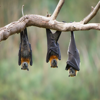

array([[[216, 196, 172],
        [216, 196, 172],
        [216, 196, 172],
        ...,
        [ 62,  48,  48],
        [ 88,  74,  71],
        [166, 153, 147]],

       [[215, 195, 171],
        [215, 195, 171],
        [216, 196, 172],
        ...,
        [ 60,  46,  46],
        [ 99,  85,  82],
        [183, 170, 164]],

       [[215, 195, 171],
        [215, 195, 171],
        [215, 195, 171],
        ...,
        [ 60,  46,  45],
        [114, 101,  95],
        [201, 188, 180]],

       ...,

       [[125, 105, 106],
        [124, 104, 105],
        [123, 105, 105],
        ...,
        [180, 145, 125],
        [181, 146, 126],
        [183, 148, 128]],

       [[124, 104, 105],
        [124, 104, 105],
        [122, 104, 104],
        ...,
        [179, 144, 124],
        [180, 145, 125],
        [182, 147, 127]],

       [[124, 104, 105],
        [123, 103, 104],
        [122, 104, 104],
        ...,
        [179, 144, 124],
        [180, 145, 125],
        [181, 146, 126]]], dtype=uint8)
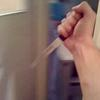

array([[[160, 159, 154],
        [163, 162, 157],
        [159, 158, 153],
        ...,
        [142, 147, 151],
        [149, 159, 162],
        [166, 181, 189]],

       [[162, 161, 156],
        [163, 162, 157],
        [159, 158, 154],
        ...,
        [137, 146, 148],
        [142, 152, 155],
        [163, 178, 186]],

       [[164, 162, 157],
        [162, 161, 156],
        [158, 158, 155],
        ...,
        [133, 142, 146],
        [137, 147, 150],
        [158, 170, 178]],

       ...,

       [[136, 112,  87],
        [141, 114,  87],
        [145, 116,  86],
        ...,
        [189, 171, 147],
        [193, 171, 148],
        [188, 166, 142]],

       [[139, 114,  87],
        [145, 118,  88],
        [148, 117,  84],
        ...,
        [191, 167, 142],
        [195, 174, 147],
        [199, 179, 150]],

       [[139, 112,  81],
        [138, 111,  80],
        [142, 112,  77],
        ...,
        [173, 149, 124],
        [176, 153, 128],
        [173, 149, 124]]], dtype=uint8)
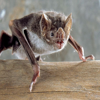

array([[[ 49,  33,  26],
        [ 58,  38,  32],
        [ 73,  45,  40],
        ...,
        [120, 112,  75],
        [ 84,  79,  41],
        [ 98,  94,  57]],

       [[ 47,  32,  25],
        [ 46,  28,  21],
        [ 60,  36,  30],
        ...,
        [105,  97,  61],
        [ 90,  85,  47],
        [ 93,  89,  52]],

       [[ 47,  32,  25],
        [ 36,  20,  13],
        [ 38,  21,  13],
        ...,
        [ 99,  94,  57],
        [ 98,  96,  57],
        [ 95,  93,  55]],

       ...,

       [[ 39,  26,  17],
        [ 41,  28,  18],
        [ 41,  29,  18],
        ...,
        [116,  99,  92],
        [ 99,  82,  75],
        [ 86,  69,  62]],

       [[ 36,  27,  16],
        [ 34,  25,  13],
        [ 33,  24,  11],
        ...,
        [119, 102,  95],
        [104,  87,  80],
        [ 99,  81,  74]],

       [[ 26,  20,   7],
        [ 26,  19,   5],
        [ 29,  23,   9],
        ...,
        [128, 111, 104],
        [118, 101,  94],
        [106,  89,  82]]], dtype=uint8)
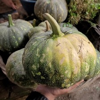

array([[[110,  88,  85],
        [ 69,  60,  64],
        [ 61,  55,  57],
        ...,
        [ 32,  30,  41],
        [ 33,  31,  42],
        [ 32,  30,  41]],

       [[104,  85,  84],
        [ 74,  63,  66],
        [ 62,  54,  59],
        ...,
        [ 33,  31,  42],
        [ 32,  29,  41],
        [ 31,  29,  40]],

       [[ 91,  77,  77],
        [ 73,  63,  65],
        [ 67,  57,  62],
        ...,
        [ 34,  33,  43],
        [ 32,  31,  42],
        [ 32,  29,  41]],

       ...,

       [[ 26,  26,  36],
        [ 24,  24,  34],
        [ 24,  23,  34],
        ...,
        [ 30,  30,  40],
        [ 26,  26,  37],
        [ 27,  27,  39]],

       [[ 26,  26,  36],
        [ 26,  26,  36],
        [ 26,  25,  36],
        ...,
        [ 33,  33,  43],
        [ 31,  31,  41],
        [ 27,  27,  38]],

       [[ 28,  28,  38],
        [ 26,  26,  36],
        [ 25,  23,  34],
        ...,
        [ 39,  39,  48],
        [ 33,  33,  42],
        [ 32,  32,  39]]], dtype=uint8)
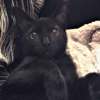

array([[[129, 132,  87],
        [133, 145, 103],
        [150, 170, 129],
        ...,
        [ 77,  96,  46],
        [106, 123,  67],
        [149, 162, 102]],

       [[126, 129,  95],
        [132, 143, 108],
        [148, 166, 128],
        ...,
        [ 80,  97,  52],
        [113, 123,  79],
        [159, 162, 120]],

       [[121, 127,  91],
        [128, 142, 103],
        [144, 163, 122],
        ...,
        [ 95, 112,  66],
        [124, 130,  94],
        [157, 151, 125]],

       ...,

       [[142, 118,  92],
        [116,  97,  67],
        [ 85,  76,  41],
        ...,
        [153, 140, 144],
        [154, 140, 146],
        [153, 137, 144]],

       [[124, 109,  82],
        [ 98,  86,  57],
        [ 90,  84,  51],
        ...,
        [156, 141, 146],
        [156, 141, 147],
        [154, 139, 146]],

       [[103,  94,  67],
        [ 95,  87,  59],
        [ 83,  78,  48],
        ...,
        [162, 146, 151],
        [160, 145, 152],
        [155, 140, 148]]], dtype=uint8)
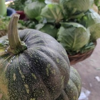

array([[[218, 163,  94],
        [211, 160,  94],
        [197, 132,  73],
        ...,
        [ 73,  88,  97],
        [ 56,  62,  32],
        [ 45,  49,  22]],

       [[223, 175, 108],
        [217, 169, 104],
        [202, 140,  76],
        ...,
        [ 73,  79,  78],
        [ 69,  77,  42],
        [ 46,  52,  35]],

       [[224, 181, 118],
        [218, 176, 115],
        [205, 149,  87],
        ...,
        [ 71,  72,  55],
        [ 71,  79,  44],
        [ 58,  71,  68]],

       ...,

       [[164, 144,  67],
        [173, 147,  79],
        [165, 137,  76],
        ...,
        [ 85, 122, 184],
        [ 84, 122, 184],
        [ 84, 122, 184]],

       [[161, 141,  70],
        [167, 142,  78],
        [158, 131,  76],
        ...,
        [ 84, 122, 184],
        [ 84, 122, 184],
        [ 84, 122, 182]],

       [[159, 141,  73],
        [166, 142,  81],
        [160, 132,  81],
        ...,
        [ 84, 122, 184],
        [ 84, 122, 183],
        [ 83, 122, 179]]], dtype=uint8)
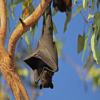

array([[[194, 168, 143],
        [194, 168, 143],
        [194, 168, 143],
        ...,
        [160, 149, 131],
        [160, 149, 131],
        [161, 150, 132]],

       [[194, 168, 143],
        [194, 168, 143],
        [193, 167, 142],
        ...,
        [160, 149, 131],
        [160, 149, 131],
        [161, 150, 132]],

       [[194, 168, 143],
        [193, 167, 142],
        [193, 167, 142],
        ...,
        [160, 149, 131],
        [160, 149, 131],
        [161, 150, 132]],

       ...,

       [[ 78,  59,  63],
        [ 73,  54,  58],
        [ 67,  46,  51],
        ...,
        [ 55,  58,  67],
        [ 56,  59,  68],
        [ 57,  60,  69]],

       [[ 77,  58,  62],
        [ 71,  52,  56],
        [ 64,  43,  48],
        ...,
        [ 55,  58,  67],
        [ 56,  59,  68],
        [ 57,  60,  69]],

       [[ 79,  60,  64],
        [ 73,  54,  58],
        [ 65,  44,  49],
        ...,
        [ 55,  58,  67],
        [ 56,  59,  68],
        [ 57,  60,  69]]], dtype=uint8)

array([[[222, 196, 140],
        [214, 188, 141],
        [192, 168, 134],
        ...,
        [184, 115,  46],
        [168, 108,  27],
        [106,  67,  25]],

       [[191, 154, 102],
        [211, 176, 127],
        [228, 196, 152],
        ...,
        [185, 120,  59],
        [142,  86,  31],
        [ 72,  42,  13]],

       [[173, 127,  82],
        [176, 133,  83],
        [185, 145,  90],
        ...,
        [162, 105,  57],
        [101,  55,  33],
        [ 52,  32,  17]],

       ...,

       [[ 61,  46,  43],
        [ 67,  52,  49],
        [ 51,  37,  34],
        ...,
        [ 79,  85, 135],
        [ 78,  84, 134],
        [ 78,  84, 132]],

       [[ 68,  52,  49],
        [ 42,  27,  24],
        [ 46,  31,  28],
        ...,
        [ 75,  82, 132],
        [ 76,  82, 132],
        [ 77,  83, 131]],

       [[ 46,  27,  25],
        [ 60,  42,  40],
        [ 38,  22,  19],
        ...,
        [ 68,  78, 128],
        [ 72,  81, 130],
        [ 76,  82, 130]]], dtype=uint8)

array([[[128,  98,  70],
        [126,  99,  72],
        [125,  99,  74],
        ...,
        [165, 185, 176],
        [165, 185, 176],
        [166, 186, 177]],

       [[124,  94,  66],
        [121,  94,  67],
        [118,  94,  68],
        ...,
        [166, 186, 177],
        [166, 186, 177],
        [166, 186, 177]],

       [[116,  89,  60],
        [113,  87,  60],
        [110,  86,  60],
        ...,
        [166, 185, 179],
        [166, 185, 179],
        [167, 186, 180]],

       ...,

       [[142, 114, 103],
        [145, 117, 106],
        [150, 120, 110],
        ...,
        [123, 107,  82],
        [123, 107,  82],
        [124, 108,  83]],

       [[149, 121, 110],
        [152, 124, 113],
        [156, 126, 116],
        ...,
        [123, 107,  82],
        [123, 107,  82],
        [124, 108,  83]],

       [[154, 126, 115],
        [156, 128, 117],
        [160, 130, 120],
        ...,
        [123, 107,  82],
        [123, 107,  82],
        [124, 108,  83]]], dtype=uint8)
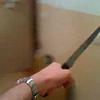

array([[[114, 142, 139],
        [124, 151, 152],
        [138, 163, 168],
        ...,
        [ 91,  91,  85],
        [101,  98,  93],
        [104, 103,  98]],

       [[120, 146, 143],
        [129, 155, 156],
        [139, 165, 172],
        ...,
        [ 88,  88,  83],
        [ 99,  95,  91],
        [103, 102,  97]],

       [[126, 150, 148],
        [137, 160, 164],
        [135, 153, 136],
        ...,
        [ 87,  87,  81],
        [ 96,  92,  88],
        [100,  99,  94]],

       ...,

       [[ 51,  73,  24],
        [ 59,  95,  22],
        [ 79, 126,  19],
        ...,
        [ 95, 105,  84],
        [ 91, 103,  80],
        [ 87, 103,  77]],

       [[ 54,  77,  21],
        [ 66, 103,  22],
        [ 79, 126,  19],
        ...,
        [131, 138, 122],
        [133, 143, 124],
        [105, 122,  95]],

       [[ 58,  82,  21],
        [ 68, 106,  19],
        [ 78, 124,  17],
        ...,
        [ 87,  98,  74],
        [ 91, 103,  79],
        [ 88, 104,  77]]], dtype=uint8)
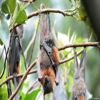

array([[[111,  62,  47],
        [104,  59,  44],
        [ 86,  48,  37],
        ...,
        [176, 112,  63],
        [180, 115,  69],
        [185, 118,  71]],

       [[116,  64,  47],
        [108,  59,  44],
        [ 89,  47,  36],
        ...,
        [178, 114,  67],
        [175, 111,  65],
        [180, 115,  67]],

       [[130,  72,  52],
        [120,  65,  47],
        [ 99,  50,  36],
        ...,
        [183, 119,  72],
        [174, 110,  63],
        [172, 111,  62]],

       ...,

       [[192, 133,  73],
        [176, 121,  65],
        [168, 116,  67],
        ...,
        [191, 133,  84],
        [202, 144,  99],
        [195, 140, 106]],

       [[184, 125,  65],
        [171, 116,  60],
        [165, 112,  63],
        ...,
        [195, 137,  89],
        [200, 143,  95],
        [211, 159, 111]],

       [[173, 113,  56],
        [162, 106,  52],
        [157, 105,  56],
        ...,
        [192, 134,  86],
        [203, 146,  97],
        [210, 159, 101]]], dtype=uint8)
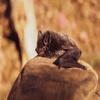

array([[[127,  97,  71],
        [118,  86,  61],
        [111,  76,  54],
        ...,
        [156, 152, 123],
        [155, 150, 121],
        [150, 145, 116]],

       [[138, 108,  82],
        [127,  95,  70],
        [117,  83,  58],
        ...,
        [155, 151, 122],
        [155, 150, 121],
        [150, 145, 116]],

       [[133, 106,  77],
        [123,  93,  65],
        [115,  81,  54],
        ...,
        [156, 150, 124],
        [154, 148, 122],
        [149, 143, 117]],

       ...,

       [[111,  58,  40],
        [111,  58,  40],
        [112,  59,  41],
        ...,
        [140,  94,  60],
        [140,  94,  60],
        [140,  94,  60]],

       [[111,  58,  40],
        [111,  58,  40],
        [112,  59,  41],
        ...,
        [140,  94,  60],
        [140,  94,  60],
        [140,  94,  60]],

       [[111,  58,  40],
        [111,  58,  40],
        [112,  59,  41],
        ...,
        [140,  94,  60],
        [140,  94,  60],
        [140,  94,  60]]], dtype=uint8)
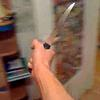

array([[[145, 126, 109],
        [136, 117,  99],
        [ 67,  51,  33],
        ...,
        [190, 177, 158],
        [192, 176, 158],
        [192, 177, 158]],

       [[127, 108,  91],
        [127, 108,  91],
        [ 68,  52,  36],
        ...,
        [191, 180, 160],
        [194, 179, 160],
        [195, 180, 161]],

       [[ 97,  78,  61],
        [104,  84,  68],
        [ 82,  65,  53],
        ...,
        [192, 183, 162],
        [194, 182, 162],
        [196, 181, 162]],

       ...,

       [[ 45,  41,  42],
        [ 47,  43,  37],
        [ 47,  36,  38],
        ...,
        [139, 133,  82],
        [136, 133,  62],
        [133, 130,  62]],

       [[ 48,  41,  42],
        [ 85,  78,  69],
        [ 43,  33,  34],
        ...,
        [133, 128,  69],
        [131, 125,  58],
        [134, 129,  61]],

       [[ 48,  39,  41],
        [ 86,  77,  69],
        [ 24,  22,  26],
        ...,
        [127, 123,  57],
        [131, 124,  58],
        [133, 127,  53]]], dtype=uint8)
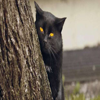

array([[[ 96, 124,  83],
        [ 95, 123,  82],
        [ 95, 123,  82],
        ...,
        [186, 149, 105],
        [182, 145, 101],
        [180, 143,  99]],

       [[ 97, 125,  84],
        [ 96, 124,  83],
        [ 96, 124,  83],
        ...,
        [181, 144, 100],
        [178, 141,  97],
        [177, 140,  96]],

       [[101, 129,  88],
        [100, 128,  87],
        [100, 128,  87],
        ...,
        [178, 141,  97],
        [176, 139,  95],
        [175, 138,  94]],

       ...,

       [[153, 140,  95],
        [155, 142,  97],
        [159, 145, 100],
        ...,
        [ 94,  76,  40],
        [ 80,  62,  26],
        [ 69,  51,  15]],

       [[153, 140,  95],
        [155, 142,  97],
        [159, 145, 100],
        ...,
        [ 94,  76,  40],
        [ 81,  63,  27],
        [ 72,  54,  18]],

       [[153, 140,  95],
        [155, 142,  97],
        [159, 145, 100],
        ...,
        [ 93,  75,  39],
        [ 81,  63,  27],
        [ 77,  59,  23]]], dtype=uint8)
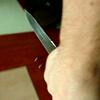

array([[[ 95,  89,  71],
        [146, 126,  55],
        [247, 228,  39],
        ...,
        [209, 207, 223],
        [216, 213, 232],
        [222, 219, 240]],

       [[ 91,  80,  67],
        [123, 101,  64],
        [218, 198,  44],
        ...,
        [206, 204, 222],
        [208, 206, 227],
        [206, 204, 227]],

       [[ 98,  83,  77],
        [105,  84,  67],
        [153, 133,  46],
        ...,
        [217, 219, 241],
        [211, 216, 240],
        [207, 211, 237]],

       ...,

       [[134, 118, 123],
        [136, 125, 129],
        [121, 112, 119],
        ...,
        [ 85,  91,  83],
        [ 77,  85,  74],
        [ 69,  76,  62]],

       [[135, 121, 128],
        [131, 124, 126],
        [122, 116, 122],
        ...,
        [ 86,  95,  87],
        [ 73,  85,  74],
        [ 88, 101,  86]],

       [[132, 119, 122],
        [129, 124, 122],
        [125, 122, 125],
        ...,
        [ 86,  97,  89],
        [ 74,  89,  78],
        [ 97, 114,  97]]], dtype=uint8)
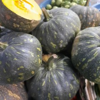

array([[[102, 147,  70],
        [ 74, 127,  20],
        [ 72, 133,   7],
        ...,
        [ 86, 164,  27],
        [ 84, 158,  34],
        [ 86, 155,  23]],

       [[149, 203, 113],
        [ 86, 146,  39],
        [ 63, 130,  10],
        ...,
        [ 84, 167,  21],
        [ 85, 166,  28],
        [ 86, 159,  29]],

       [[109, 169,  56],
        [ 77, 140,  29],
        [ 55, 122,   7],
        ...,
        [ 86, 165,  38],
        [ 88, 168,  47],
        [ 90, 167,  42]],

       ...,

       [[103, 135,  37],
        [100, 131,  31],
        [ 95, 125,  22],
        ...,
        [255, 255, 242],
        [255, 255, 240],
        [254, 254, 238]],

       [[ 97, 139,  28],
        [ 92, 132,  24],
        [ 85, 122,  17],
        ...,
        [244, 244, 208],
        [244, 244, 208],
        [240, 240, 203]],

       [[ 78, 126,   6],
        [ 71, 117,   4],
        [ 69, 112,   5],
        ...,
        [221, 222, 172],
        [224, 223, 174],
        [221, 219, 169]]], dtype=uint8)
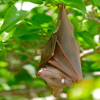

array([[[201, 196, 192],
        [202, 197, 193],
        [203, 198, 194],
        ...,
        [163, 162, 132],
        [162, 161, 131],
        [161, 160, 130]],

       [[200, 197, 190],
        [201, 198, 191],
        [202, 199, 192],
        ...,
        [163, 162, 132],
        [162, 161, 131],
        [161, 160, 130]],

       [[199, 199, 189],
        [199, 199, 189],
        [198, 200, 189],
        ...,
        [163, 162, 131],
        [162, 161, 130],
        [161, 160, 129]],

       ...,

       [[ 91,  49,  51],
        [ 90,  48,  50],
        [ 87,  45,  47],
        ...,
        [178, 164, 137],
        [185, 171, 144],
        [188, 174, 147]],

       [[ 89,  47,  49],
        [ 87,  45,  47],
        [ 83,  41,  43],
        ...,
        [183, 169, 142],
        [192, 178, 151],
        [197, 183, 156]],

       [[ 87,  45,  47],
        [ 84,  42,  44],
        [ 79,  37,  39],
        ...,
        [185, 171, 144],
        [196, 182, 155],
        [202, 188, 161]]], dtype=uint8)
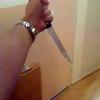

array([[[  7,  13,   9],
        [ 11,  17,  13],
        [ 12,  18,  14],
        ...,
        [153, 179, 166],
        [156, 182, 169],
        [160, 186, 173]],

       [[ 21,  27,  23],
        [ 24,  30,  26],
        [ 27,  33,  29],
        ...,
        [161, 187, 174],
        [162, 188, 175],
        [163, 189, 176]],

       [[  4,  10,   6],
        [  7,  13,   9],
        [ 10,  16,  12],
        ...,
        [188, 216, 204],
        [188, 216, 204],
        [187, 215, 203]],

       ...,

       [[  1,   2,   0],
        [  1,   2,   0],
        [  2,   1,   0],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]],

       [[  1,   2,   0],
        [  1,   2,   0],
        [  2,   1,   0],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]],

       [[  1,   2,   0],
        [  1,   2,   0],
        [  2,   1,   0],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]]], dtype=uint8)
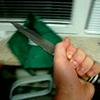

array([[[114,  83,  76],
        [100,  72,  63],
        [ 64,  41,  34],
        ...,
        [ 73,  98, 160],
        [ 71,  96, 155],
        [ 70,  94, 153]],

       [[106,  77,  69],
        [123,  95,  87],
        [ 82,  58,  50],
        ...,
        [ 73,  99, 157],
        [ 72,  98, 154],
        [ 68,  95, 150]],

       [[ 70,  42,  34],
        [107,  82,  72],
        [116,  92,  82],
        ...,
        [ 80, 111, 163],
        [ 75, 105, 157],
        [ 72, 100, 153]],

       ...,

       [[ 48,  38,  40],
        [ 68,  58,  62],
        [ 74,  64,  69],
        ...,
        [ 82,  66,  64],
        [ 54,  39,  35],
        [ 70,  57,  52]],

       [[ 74,  64,  65],
        [ 65,  55,  56],
        [ 74,  63,  68],
        ...,
        [ 81,  67,  64],
        [ 78,  61,  57],
        [ 67,  51,  44]],

       [[ 80,  68,  69],
        [ 66,  54,  56],
        [ 73,  61,  66],
        ...,
        [ 61,  50,  47],
        [ 91,  74,  70],
        [ 59,  39,  32]]], dtype=uint8)
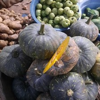

array([[[ 50, 120,  57],
        [ 56, 131,  66],
        [ 56, 134,  72],
        ...,
        [119, 155, 107],
        [114, 150, 102],
        [106, 142,  94]],

       [[ 64, 133,  70],
        [ 67, 139,  75],
        [ 58, 136,  74],
        ...,
        [ 94, 134,  84],
        [ 98, 138,  88],
        [ 96, 136,  86]],

       [[ 82, 148,  86],
        [ 77, 147,  84],
        [ 62, 138,  76],
        ...,
        [ 80, 128,  78],
        [ 90, 138,  88],
        [ 87, 135,  85]],

       ...,

       [[132, 173, 113],
        [138, 178, 118],
        [142, 177, 119],
        ...,
        [176, 196, 111],
        [168, 188, 103],
        [157, 177,  92]],

       [[131, 172, 112],
        [137, 177, 117],
        [145, 180, 122],
        ...,
        [181, 201, 116],
        [173, 193, 108],
        [161, 181,  96]],

       [[128, 169, 109],
        [133, 173, 113],
        [141, 176, 118],
        ...,
        [188, 208, 123],
        [179, 199, 114],
        [168, 188, 103]]], dtype=uint8)
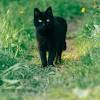

array([[[135, 153, 115],
        [135, 153, 115],
        [137, 153, 116],
        ...,
        [  7,  16,  11],
        [  0,   3,   0],
        [  0,   3,   0]],

       [[136, 152, 115],
        [136, 152, 115],
        [137, 151, 115],
        ...,
        [ 98, 107, 102],
        [ 60,  69,  64],
        [ 30,  39,  34]],

       [[138, 150, 114],
        [138, 150, 114],
        [139, 151, 115],
        ...,
        [188, 198, 190],
        [174, 184, 176],
        [165, 175, 167]],

       ...,

       [[115, 135, 124],
        [ 85, 102,  92],
        [ 22,  38,  28],
        ...,
        [ 35,  53,  31],
        [ 34,  52,  30],
        [ 32,  50,  28]],

       [[140, 160, 148],
        [114, 132, 120],
        [ 55,  71,  60],
        ...,
        [ 35,  53,  31],
        [ 34,  52,  30],
        [ 32,  50,  28]],

       [[150, 171, 156],
        [131, 149, 135],
        [ 81,  97,  86],
        ...,
        [ 35,  53,  31],
        [ 34,  52,  30],
        [ 32,  50,  28]]], dtype=uint8)
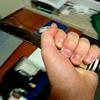

array([[[ 71, 173, 237],
        [ 72, 174, 238],
        [ 76, 178, 241],
        ...,
        [ 72,  63,  61],
        [ 82,  73,  68],
        [100, 126, 120]],

       [[ 71, 174, 237],
        [ 72, 173, 237],
        [ 75, 175, 239],
        ...,
        [ 76, 133, 157],
        [ 63,  70,  76],
        [ 68,  54,  51]],

       [[ 70, 174, 237],
        [ 70, 174, 237],
        [ 69, 173, 237],
        ...,
        [ 95, 166, 170],
        [ 96, 154, 138],
        [ 80,  99,  74]],

       ...,

       [[ 80,  92,  58],
        [ 58,  79,  17],
        [ 48,  76,  16],
        ...,
        [ 54,  34,  28],
        [ 82,  76,  45],
        [ 86, 123, 122]],

       [[ 80,  92,  53],
        [ 68,  87,  29],
        [ 60,  82,  27],
        ...,
        [ 50,  35,  33],
        [ 63,  78, 100],
        [ 65, 107, 150]],

       [[ 68,  82,  44],
        [ 66,  83,  43],
        [ 67,  87,  51],
        ...,
        [ 52,  44,  50],
        [ 71, 102, 139],
        [ 71, 109, 149]]], dtype=uint8)
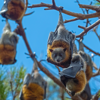

array([[[145, 128, 112],
        [136, 119, 103],
        [ 70,  53,  37],
        ...,
        [187, 178, 157],
        [189, 176, 157],
        [190, 176, 157]],

       [[124, 107,  91],
        [126, 109,  93],
        [ 70,  53,  37],
        ...,
        [189, 180, 159],
        [190, 179, 159],
        [191, 178, 159]],

       [[ 97,  80,  64],
        [101,  84,  68],
        [ 81,  64,  48],
        ...,
        [192, 183, 162],
        [193, 182, 162],
        [194, 180, 161]],

       ...,

       [[ 45,  41,  37],
        [ 43,  40,  38],
        [ 43,  38,  37],
        ...,
        [139, 131,  84],
        [139, 132,  74],
        [136, 131,  65]],

       [[ 47,  41,  38],
        [ 82,  78,  76],
        [ 39,  35,  34],
        ...,
        [134, 127,  73],
        [128, 122,  58],
        [134, 130,  60]],

       [[ 48,  41,  38],
        [ 83,  79,  77],
        [ 24,  22,  20],
        ...,
        [125, 118,  58],
        [130, 126,  58],
        [131, 127,  54]]], dtype=uint8)
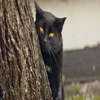

array([[[231, 214, 207],
        [217, 200, 193],
        [183, 162, 154],
        ...,
        [ 12,  11,   7],
        [  3,   8,   9],
        [  1,   3,   9]],

       [[215, 200, 196],
        [186, 170, 164],
        [162, 143, 136],
        ...,
        [ 18,  14,  10],
        [  4,   6,   7],
        [  1,   1,   6]],

       [[113, 100,  98],
        [144, 131, 126],
        [125, 110, 103],
        ...,
        [ 32,  20,  17],
        [ 15,   9,   9],
        [  7,   1,   4]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [115,  77,  48],
        [112,  80,  55],
        [ 47,  29,  19]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [114,  74,  43],
        [116,  83,  57],
        [ 53,  35,  27]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [101,  60,  29],
        [108,  75,  49],
        [ 49,  32,  25]]], dtype=uint8)
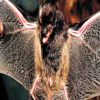

array([[[152, 171, 174],
        [122, 143, 153],
        [ 55,  78,  94],
        ...,
        [ 78, 111, 133],
        [ 90, 120, 149],
        [ 95, 118, 139]],

       [[168, 187, 188],
        [161, 181, 190],
        [107, 128, 142],
        ...,
        [ 78, 112, 136],
        [ 88, 119, 148],
        [ 93, 118, 139]],

       [[173, 190, 192],
        [163, 183, 190],
        [128, 150, 161],
        ...,
        [ 78, 113, 138],
        [ 95, 127, 156],
        [ 91, 118, 139]],

       ...,

       [[153, 172, 195],
        [121, 143, 168],
        [ 98, 125, 152],
        ...,
        [ 46,  56,  65],
        [ 82,  93, 102],
        [ 94, 102, 112]],

       [[ 92, 113, 136],
        [ 83, 108, 131],
        [ 83, 110, 137],
        ...,
        [ 80,  91,  99],
        [ 76,  86,  95],
        [ 93, 100, 110]],

       [[ 90, 113, 132],
        [ 89, 111, 131],
        [129, 151, 172],
        ...,
        [ 90,  99, 108],
        [ 77,  85,  95],
        [ 84,  91, 100]]], dtype=uint8)
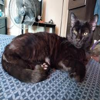

array([[[136, 148, 128],
        [146, 158, 138],
        [159, 171, 151],
        ...,
        [ 12,  31,   9],
        [ 22,  41,  19],
        [ 24,  43,  21]],

       [[136, 148, 128],
        [139, 151, 131],
        [145, 157, 137],
        ...,
        [  0,  16,   0],
        [  8,  25,   6],
        [ 15,  33,  11]],

       [[131, 143, 123],
        [125, 137, 117],
        [112, 124, 104],
        ...,
        [  0,   8,   0],
        [  0,  11,   0],
        [  1,  16,   0]],

       ...,

       [[ 14,   2,   2],
        [ 18,   0,   1],
        [ 25,   0,   0],
        ...,
        [  0,   2,   0],
        [  4,   5,   0],
        [  8,  10,   0]],

       [[ 11,   0,   0],
        [ 17,   0,   0],
        [ 27,   0,   1],
        ...,
        [  0,   1,   0],
        [  1,   2,   0],
        [  1,   2,   0]],

       [[  8,   0,   0],
        [ 17,   0,   0],
        [ 29,   0,   3],
        ...,
        [  3,   4,   0],
        [  1,   2,   0],
        [  0,   1,   0]]], dtype=uint8)
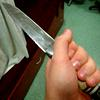

array([[[ 86,  10,   0],
        [101,  25,   1],
        [117,  43,  16],
        ...,
        [171, 220, 190],
        [168, 217, 187],
        [165, 214, 184]],

       [[ 83,   6,   0],
        [ 92,  16,   0],
        [101,  25,   0],
        ...,
        [167, 216, 186],
        [165, 214, 184],
        [163, 212, 182]],

       [[ 84,   5,   0],
        [ 85,   8,   0],
        [ 84,   8,   0],
        ...,
        [172, 218, 189],
        [171, 217, 188],
        [170, 216, 187]],

       ...,

       [[169, 198, 144],
        [178, 205, 152],
        [188, 210, 163],
        ...,
        [ 38,  63,  34],
        [ 39,  62,  36],
        [ 41,  64,  38]],

       [[172, 201, 147],
        [181, 208, 155],
        [191, 213, 166],
        ...,
        [ 15,  38,  12],
        [  5,  24,   2],
        [  0,  16,   0]],

       [[173, 202, 148],
        [182, 209, 156],
        [192, 214, 167],
        ...,
        [  0,  23,   0],
        [  0,  14,   0],
        [  0,   9,   0]]], dtype=uint8)
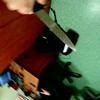

array([[[118, 127, 119],
        [155, 165, 157],
        [111, 125,  97],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[146, 164, 146],
        [170, 187, 173],
        [141, 158, 135],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[139, 160, 129],
        [115, 135, 111],
        [137, 155, 126],
        ...,
        [255, 255, 255],
        [254, 254, 254],
        [255, 255, 255]],

       ...,

       [[154, 145, 140],
        [156, 149, 143],
        [152, 144, 138],
        ...,
        [178, 169, 162],
        [176, 167, 160],
        [189, 179, 171]],

       [[151, 142, 137],
        [153, 145, 139],
        [150, 141, 137],
        ...,
        [179, 170, 166],
        [182, 174, 169],
        [195, 190, 182]],

       [[150, 141, 135],
        [153, 146, 140],
        [150, 142, 137],
        ...,
        [185, 174, 173],
        [187, 180, 177],
        [191, 191, 184]]], dtype=uint8)
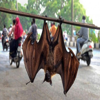

array([[[114, 104,  77],
        [118, 111,  83],
        [117, 110,  84],
        ...,
        [116, 119,  86],
        [107, 110,  82],
        [144, 137, 121]],

       [[116, 107,  80],
        [121, 114,  86],
        [119, 113,  87],
        ...,
        [112, 114,  82],
        [129, 130, 103],
        [204, 196, 183]],

       [[120, 111,  83],
        [125, 118,  90],
        [123, 117,  90],
        ...,
        [115, 115,  86],
        [183, 182, 157],
        [192, 184, 172]],

       ...,

       [[120, 125,  92],
        [117, 122,  91],
        [115, 119,  92],
        ...,
        [110, 124,  89],
        [111, 118,  86],
        [113, 116,  87]],

       [[126, 129,  97],
        [124, 126,  96],
        [121, 122,  96],
        ...,
        [114, 125,  89],
        [113, 119,  86],
        [119, 121,  91]],

       [[131, 136,  98],
        [127, 132,  96],
        [123, 126,  95],
        ...,
        [125, 130,  95],
        [123, 125,  92],
        [126, 125,  89]]], dtype=uint8)
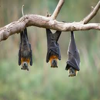

array([[[143, 132, 119],
        [144, 131, 118],
        [143, 131, 119],
        ...,
        [ 90,  91, 111],
        [ 82,  83, 100],
        [ 75,  75,  91]],

       [[144, 132, 122],
        [144, 132, 121],
        [143, 132, 121],
        ...,
        [ 78,  78,  90],
        [ 74,  73,  85],
        [ 71,  70,  80]],

       [[144, 133, 123],
        [143, 132, 122],
        [141, 131, 122],
        ...,
        [ 71,  71,  79],
        [ 70,  69,  76],
        [ 70,  69,  75]],

       ...,

       [[ 44,  45,  40],
        [ 46,  45,  41],
        [ 47,  46,  42],
        ...,
        [ 71,  70,  70],
        [ 97, 101, 120],
        [ 94, 100, 117]],

       [[ 44,  44,  40],
        [ 45,  44,  40],
        [ 46,  45,  41],
        ...,
        [ 67,  68,  74],
        [133, 145, 170],
        [ 82,  88,  96]],

       [[ 45,  44,  40],
        [ 46,  45,  41],
        [ 46,  45,  41],
        ...,
        [ 73,  77,  90],
        [117, 127, 142],
        [ 57,  59,  55]]], dtype=uint8)
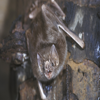

array([[[108, 108, 108],
        [114, 114, 114],
        [115, 115, 115],
        ...,
        [ 51,  51,  51],
        [ 77,  77,  77],
        [115, 115, 115]],

       [[ 85,  85,  85],
        [ 85,  85,  85],
        [ 86,  86,  86],
        ...,
        [ 39,  39,  39],
        [ 40,  40,  40],
        [ 76,  76,  76]],

       [[ 85,  85,  85],
        [ 95,  95,  95],
        [104, 104, 104],
        ...,
        [ 59,  59,  59],
        [ 53,  53,  53],
        [ 61,  61,  61]],

       ...,

       [[169, 169, 169],
        [158, 158, 158],
        [159, 159, 159],
        ...,
        [196, 196, 196],
        [204, 204, 204],
        [209, 209, 209]],

       [[176, 176, 176],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [194, 194, 194],
        [204, 204, 204],
        [214, 214, 214]],

       [[187, 187, 187],
        [183, 183, 183],
        [170, 170, 170],
        ...,
        [188, 188, 188],
        [206, 206, 206],
        [206, 206, 206]]], dtype=uint8)
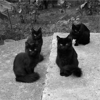

array([[[104,  98,  50],
        [ 69,  74,  11],
        [ 71,  84,   7],
        ...,
        [  7,  20,   3],
        [ 17,  34,   4],
        [ 24,  50,   6]],

       [[105,  94,  49],
        [ 76,  82,  13],
        [ 67,  82,   6],
        ...,
        [  3,  12,   3],
        [ 11,  23,   4],
        [ 17,  37,   4]],

       [[101,  90,  48],
        [ 86,  92,  16],
        [ 69,  87,   6],
        ...,
        [  1,   4,   2],
        [  6,  13,   2],
        [ 13,  24,   5]],

       ...,

       [[178, 157, 145],
        [152, 114,  78],
        [190, 154, 125],
        ...,
        [189, 218,  67],
        [190, 215,  83],
        [193, 213, 102]],

       [[190, 179, 174],
        [144, 115,  91],
        [164, 128,  95],
        ...,
        [192, 220,  79],
        [192, 217,  91],
        [196, 216, 107]],

       [[193, 188, 186],
        [162, 141, 127],
        [154, 117,  79],
        ...,
        [196, 221,  88],
        [195, 218,  97],
        [195, 219, 101]]], dtype=uint8)

array([[[ 71,  71,  71],
        [ 47,  47,  47],
        [ 45,  45,  45],
        ...,
        [ 85,  85,  85],
        [ 77,  77,  77],
        [ 73,  73,  73]],

       [[ 71,  71,  71],
        [ 56,  56,  56],
        [ 59,  59,  59],
        ...,
        [ 90,  90,  90],
        [ 82,  82,  82],
        [ 78,  78,  78]],

       [[ 77,  77,  77],
        [ 68,  68,  68],
        [ 76,  76,  76],
        ...,
        [ 99,  99,  99],
        [ 91,  91,  91],
        [ 85,  85,  85]],

       ...,

       [[ 99,  99,  99],
        [108, 108, 108],
        [117, 117, 117],
        ...,
        [108, 108, 108],
        [103, 103, 103],
        [ 99,  99,  99]],

       [[105, 105, 105],
        [113, 113, 113],
        [121, 121, 121],
        ...,
        [101, 101, 101],
        [ 97,  97,  97],
        [ 96,  96,  96]],

       [[ 95,  95,  95],
        [ 97,  97,  97],
        [ 97,  97,  97],
        ...,
        [101, 101, 101],
        [ 96,  96,  96],
        [ 93,  93,  93]]], dtype=uint8)
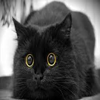

array([[[ 76,  71,  68],
        [ 78,  73,  70],
        [ 76,  76,  72],
        ...,
        [ 43,  44,  38],
        [ 40,  41,  35],
        [ 40,  41,  35]],

       [[ 75,  72,  69],
        [ 77,  74,  71],
        [ 76,  77,  72],
        ...,
        [ 43,  44,  38],
        [ 41,  42,  36],
        [ 40,  41,  35]],

       [[ 74,  74,  69],
        [ 76,  76,  71],
        [ 78,  79,  74],
        ...,
        [ 44,  45,  39],
        [ 42,  43,  37],
        [ 40,  41,  35]],

       ...,

       [[110, 112, 109],
        [116, 118, 115],
        [118, 120, 117],
        ...,
        [123, 125, 125],
        [123, 124, 126],
        [119, 120, 121]],

       [[108, 110, 107],
        [112, 114, 111],
        [115, 117, 114],
        ...,
        [115, 118, 116],
        [114, 116, 115],
        [113, 115, 114]],

       [[107, 109, 106],
        [108, 110, 107],
        [110, 112, 109],
        ...,
        [106, 107, 105],
        [105, 107, 106],
        [106, 108, 107]]], dtype=uint8)

array([[[102, 121, 138],
        [105, 124, 142],
        [106, 127, 146],
        ...,
        [160, 149, 146],
        [158, 148, 149],
        [157, 147, 148]],

       [[106, 127, 146],
        [109, 130, 151],
        [112, 133, 154],
        ...,
        [161, 150, 147],
        [159, 149, 150],
        [158, 148, 149]],

       [[114, 137, 160],
        [117, 140, 163],
        [119, 144, 166],
        ...,
        [163, 152, 149],
        [162, 152, 152],
        [160, 150, 151]],

       ...,

       [[190, 151, 139],
        [188, 148, 137],
        [181, 138, 125],
        ...,
        [195, 155, 149],
        [200, 162, 155],
        [195, 158, 150]],

       [[205, 173, 164],
        [208, 172, 163],
        [200, 162, 151],
        ...,
        [199, 166, 161],
        [205, 172, 164],
        [198, 165, 155]],

       [[211, 178, 169],
        [216, 181, 172],
        [213, 175, 165],
        ...,
        [205, 172, 166],
        [199, 165, 156],
        [193, 158, 149]]], dtype=uint8)

array([[[190, 183, 170],
        [196, 190, 175],
        [197, 189, 175],
        ...,
        [173, 170, 151],
        [160, 146, 117],
        [155, 151, 114]],

       [[197, 188, 175],
        [197, 188, 175],
        [196, 188, 174],
        ...,
        [160, 151, 132],
        [164, 128, 114],
        [153, 150, 116]],

       [[210, 199, 189],
        [195, 186, 171],
        [194, 186, 171],
        ...,
        [148, 154, 124],
        [137, 113,  91],
        [142, 117,  97]],

       ...,

       [[165, 161, 127],
        [160, 157, 125],
        [149, 148, 123],
        ...,
        [197, 186, 170],
        [208, 198, 184],
        [148, 150, 116]],

       [[168, 169, 136],
        [161, 160, 132],
        [147, 146, 127],
        ...,
        [196, 187, 169],
        [213, 201, 190],
        [199, 196, 180]],

       [[170, 170, 142],
        [161, 160, 135],
        [145, 144, 127],
        ...,
        [198, 186, 176],
        [212, 205, 196],
        [227, 222, 217]]], dtype=uint8)
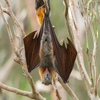

array([[[185, 171, 108],
        [185, 171, 108],
        [185, 171, 108],
        ...,
        [164, 161,  84],
        [164, 161,  84],
        [164, 161,  84]],

       [[185, 171, 108],
        [185, 171, 108],
        [185, 171, 108],
        ...,
        [164, 161,  84],
        [164, 161,  84],
        [164, 161,  84]],

       [[185, 171, 108],
        [185, 171, 108],
        [185, 171, 108],
        ...,
        [164, 161,  84],
        [164, 161,  84],
        [164, 161,  84]],

       ...,

       [[ 84,  10,   1],
        [ 82,   8,   0],
        [ 85,   7,   3],
        ...,
        [122,  55,   3],
        [125,  58,   5],
        [122,  55,   2]],

       [[ 80,   7,   0],
        [ 80,   7,   0],
        [ 81,   6,   1],
        ...,
        [128,  58,   6],
        [134,  64,  12],
        [132,  63,   8]],

       [[ 78,   5,   0],
        [ 78,   5,   0],
        [ 80,   5,   0],
        ...,
        [131,  61,   9],
        [138,  69,  14],
        [139,  70,  15]]], dtype=uint8)

array([[[181, 166, 147],
        [162, 147, 129],
        [163, 148, 129],
        ...,
        [ 29,  52,  44],
        [ 29,  52,  44],
        [ 31,  54,  46]],

       [[164, 149, 129],
        [177, 162, 142],
        [166, 151, 131],
        ...,
        [ 29,  52,  44],
        [ 29,  52,  44],
        [ 29,  52,  44]],

       [[152, 137, 115],
        [182, 167, 145],
        [192, 177, 155],
        ...,
        [ 29,  52,  44],
        [ 29,  52,  44],
        [ 27,  50,  42]],

       ...,

       [[111,  95,  67],
        [102,  89,  70],
        [ 92,  85,  80],
        ...,
        [237, 228, 216],
        [231, 220, 208],
        [238, 220, 211]],

       [[108,  93,  66],
        [105,  92,  75],
        [ 93,  87,  83],
        ...,
        [243, 233, 221],
        [231, 220, 208],
        [240, 220, 210]],

       [[111,  98,  80],
        [ 98,  91,  80],
        [ 74,  75,  77],
        ...,
        [244, 230, 214],
        [233, 218, 203],
        [233, 210, 198]]], dtype=uint8)

array([[[169, 161, 180],
        [165, 156, 175],
        [153, 144, 162],
        ...,
        [163, 175, 136],
        [140, 156, 104],
        [127, 143,  89]],

       [[172, 163, 181],
        [149, 139, 157],
        [130, 119, 136],
        ...,
        [163, 184, 130],
        [147, 169, 109],
        [141, 166,  93]],

       [[170, 160, 177],
        [132, 120, 137],
        [120, 107, 123],
        ...,
        [169, 195, 145],
        [155, 183, 126],
        [119, 150,  75]],

       ...,

       [[116, 119,  74],
        [112, 110,  66],
        [124, 119,  74],
        ...,
        [195, 210, 168],
        [170, 183, 142],
        [161, 171, 145]],

       [[132, 125,  79],
        [111, 104,  58],
        [125, 115,  71],
        ...,
        [188, 205, 154],
        [179, 193, 142],
        [157, 166, 147]],

       [[122, 117,  61],
        [115, 108,  55],
        [134, 125,  76],
        ...,
        [194, 211, 158],
        [170, 187, 134],
        [156, 164, 154]]], dtype=uint8)
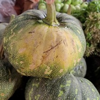

array([[[172, 141,  86],
        [172, 141,  86],
        [174, 142,  85],
        ...,
        [166, 207, 193],
        [166, 207, 193],
        [166, 207, 193]],

       [[172, 141,  86],
        [172, 141,  86],
        [174, 142,  85],
        ...,
        [166, 207, 193],
        [166, 207, 193],
        [166, 207, 193]],

       [[172, 141,  86],
        [172, 141,  86],
        [173, 141,  84],
        ...,
        [167, 208, 194],
        [167, 208, 194],
        [167, 208, 194]],

       ...,

       [[105, 130, 126],
        [107, 128, 123],
        [113, 123, 115],
        ...,
        [254, 206, 144],
        [255, 207, 145],
        [255, 208, 146]],

       [[105, 130, 126],
        [107, 128, 123],
        [113, 123, 115],
        ...,
        [254, 206, 144],
        [255, 207, 145],
        [255, 208, 146]],

       [[105, 130, 126],
        [107, 128, 123],
        [113, 123, 115],
        ...,
        [254, 206, 144],
        [255, 207, 145],
        [255, 208, 146]]], dtype=uint8)
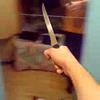

array([[[218, 164, 110],
        [210, 160,  87],
        [194, 135,  73],
        ...,
        [ 80,  86,  95],
        [ 53,  65,  32],
        [ 45,  53,  19]],

       [[224, 174, 116],
        [217, 168,  98],
        [199, 141,  79],
        ...,
        [ 74,  78,  82],
        [ 65,  75,  49],
        [ 49,  58,  41]],

       [[228, 182, 118],
        [223, 178, 111],
        [201, 146,  84],
        ...,
        [ 69,  69,  62],
        [ 73,  78,  60],
        [ 55,  67,  76]],

       ...,

       [[165, 146,  67],
        [172, 149,  82],
        [165, 140,  76],
        ...,
        [ 84, 122, 185],
        [ 84, 122, 185],
        [ 84, 122, 184]],

       [[159, 139,  69],
        [167, 142,  83],
        [159, 133,  77],
        ...,
        [ 84, 122, 185],
        [ 84, 122, 185],
        [ 84, 123, 183]],

       [[160, 137,  72],
        [167, 139,  86],
        [158, 131,  82],
        ...,
        [ 84, 122, 185],
        [ 84, 122, 184],
        [ 84, 123, 181]]], dtype=uint8)
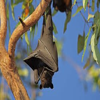

array([[[210, 226, 239],
        [212, 226, 239],
        [213, 226, 238],
        ...,
        [156, 157, 163],
        [216, 230, 241],
        [213, 230, 240]],

       [[213, 227, 240],
        [212, 228, 239],
        [213, 228, 238],
        ...,
        [221, 237, 247],
        [216, 231, 241],
        [214, 228, 239]],

       [[212, 228, 239],
        [211, 228, 239],
        [211, 228, 238],
        ...,
        [213, 230, 240],
        [212, 229, 239],
        [213, 229, 239]],

       ...,

       [[ 93,  72,  58],
        [ 93,  71,  59],
        [ 86,  71,  66],
        ...,
        [ 98, 116,  66],
        [ 91, 110,  55],
        [119, 137,  72]],

       [[193, 211, 227],
        [192, 209, 226],
        [195, 212, 229],
        ...,
        [ 93, 113,  59],
        [ 96, 115,  60],
        [109, 127,  68]],

       [[214, 232, 242],
        [214, 232, 241],
        [213, 231, 241],
        ...,
        [104, 122,  66],
        [ 94, 112,  61],
        [104, 120,  67]]], dtype=uint8)

array([[[ 84,  67,  76],
        [ 72,  58,  65],
        [136, 129, 139],
        ...,
        [126,  90,  99],
        [123,  88,  91],
        [111,  76,  75]],

       [[ 73,  58,  76],
        [ 74,  57,  73],
        [ 76,  64,  78],
        ...,
        [128,  92, 101],
        [121,  85,  89],
        [118,  80,  80]],

       [[ 73,  60,  70],
        [ 69,  53,  63],
        [ 58,  45,  54],
        ...,
        [120,  86,  93],
        [117,  82,  85],
        [130,  91,  93]],

       ...,

       [[ 85,  77,  95],
        [ 84,  75,  93],
        [ 84,  74,  91],
        ...,
        [177, 165, 136],
        [173, 157, 122],
        [164, 145, 105]],

       [[ 88,  79,  98],
        [ 83,  73,  93],
        [ 83,  71,  91],
        ...,
        [172, 165, 133],
        [171, 158, 122],
        [162, 146, 101]],

       [[ 88,  79,  98],
        [ 84,  75,  94],
        [ 83,  70,  91],
        ...,
        [165, 161, 129],
        [164, 155, 118],
        [161, 146, 101]]], dtype=uint8)

array([[[209, 175, 132],
        [212, 180, 141],
        [181, 149, 120],
        ...,
        [170, 190, 172],
        [170, 186, 167],
        [159, 173, 152]],

       [[182, 144, 105],
        [182, 146, 112],
        [197, 161, 135],
        ...,
        [138, 159, 142],
        [172, 189, 172],
        [165, 178, 161]],

       [[144, 103,  71],
        [148, 108,  80],
        [181, 143, 122],
        ...,
        [123, 144, 130],
        [161, 177, 165],
        [165, 177, 166]],

       ...,

       [[ 10,  11,  11],
        [  9,  11,  10],
        [  6,   8,   9],
        ...,
        [ 55,  42,  44],
        [ 96,  78,  78],
        [174, 155, 155]],

       [[ 10,  10,   9],
        [ 10,  11,   9],
        [  8,  10,   8],
        ...,
        [ 52,  40,  42],
        [ 59,  46,  46],
        [122, 111, 109]],

       [[ 10,  10,  10],
        [ 12,  12,  10],
        [  8,  10,   8],
        ...,
        [ 50,  39,  39],
        [ 62,  53,  51],
        [ 65,  60,  57]]], dtype=uint8)
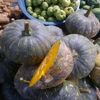

array([[[ 92,  68,  66],
        [ 92,  69,  66],
        [ 88,  67,  62],
        ...,
        [102, 100,  39],
        [106, 103,  46],
        [ 87,  84,  35]],

       [[ 95,  71,  69],
        [ 94,  71,  69],
        [ 91,  70,  65],
        ...,
        [ 79,  80,  29],
        [ 89,  89,  33],
        [ 83,  80,  31]],

       [[ 96,  70,  69],
        [ 95,  70,  68],
        [ 94,  71,  67],
        ...,
        [ 65,  67,  20],
        [ 80,  81,  29],
        [ 82,  80,  33]],

       ...,

       [[ 91, 126,  63],
        [ 92, 126,  59],
        [101, 131,  64],
        ...,
        [128, 153,  85],
        [127, 153,  84],
        [124, 150,  79]],

       [[ 90, 124,  63],
        [ 91, 125,  60],
        [100, 131,  65],
        ...,
        [123, 150,  78],
        [123, 148,  77],
        [121, 146,  77]],

       [[ 85, 119,  58],
        [ 85, 119,  55],
        [ 94, 124,  60],
        ...,
        [113, 141,  67],
        [123, 145,  76],
        [119, 143,  75]]], dtype=uint8)

array([[[ 58,  58,  47],
        [ 58,  59,  44],
        [ 59,  58,  38],
        ...,
        [ 75,  74,  80],
        [ 72,  71,  77],
        [ 68,  68,  71]],

       [[ 59,  60,  46],
        [ 58,  59,  43],
        [ 60,  60,  37],
        ...,
        [ 76,  75,  81],
        [ 74,  73,  79],
        [ 72,  72,  74]],

       [[ 60,  61,  45],
        [ 59,  61,  42],
        [ 61,  61,  36],
        ...,
        [ 77,  76,  82],
        [ 76,  75,  80],
        [ 74,  74,  76]],

       ...,

       [[ 96, 100,  82],
        [ 97,  98,  82],
        [ 94,  94,  85],
        ...,
        [109, 115, 113],
        [ 43,  50,  51],
        [ 66,  67,  64]],

       [[ 84,  87,  76],
        [ 79,  78,  71],
        [ 77,  75,  71],
        ...,
        [ 93,  96,  99],
        [ 56,  57,  54],
        [ 73,  73,  67]],

       [[ 73,  74,  69],
        [ 75,  76,  74],
        [ 73,  75,  72],
        ...,
        [ 64,  70,  64],
        [ 55,  57,  50],
        [ 63,  67,  60]]], dtype=uint8)
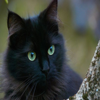

array([[[140, 120, 114],
        [158, 139, 133],
        [170, 153, 146],
        ...,
        [182, 165, 166],
        [185, 171, 170],
        [170, 156, 155]],

       [[152, 132, 124],
        [168, 149, 141],
        [163, 144, 136],
        ...,
        [181, 167, 166],
        [187, 174, 173],
        [173, 161, 160]],

       [[157, 134, 122],
        [153, 131, 119],
        [153, 132, 121],
        ...,
        [179, 166, 165],
        [184, 173, 171],
        [161, 150, 148]],

       ...,

       [[ 66,  68,  62],
        [ 78,  79,  75],
        [ 71,  71,  69],
        ...,
        [104,  96,  89],
        [ 98,  93,  84],
        [105, 100,  94]],

       [[ 63,  65,  59],
        [ 90,  92,  87],
        [ 92,  92,  90],
        ...,
        [111, 102,  95],
        [105,  99,  91],
        [108, 103,  97]],

       [[ 55,  58,  51],
        [ 73,  75,  70],
        [ 84,  84,  82],
        ...,
        [107,  98,  91],
        [114, 107,  99],
        [101,  94,  88]]], dtype=uint8)
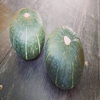

array([[[ 88,  86,  74],
        [ 88,  86,  74],
        [ 94,  92,  80],
        ...,
        [200, 207, 225],
        [199, 206, 224],
        [198, 205, 223]],

       [[ 88,  85,  76],
        [ 88,  85,  76],
        [ 95,  92,  83],
        ...,
        [200, 207, 225],
        [199, 206, 224],
        [199, 206, 224]],

       [[ 87,  84,  75],
        [ 89,  86,  77],
        [ 94,  91,  82],
        ...,
        [200, 207, 225],
        [200, 207, 225],
        [201, 208, 226]],

       ...,

       [[158, 164, 186],
        [162, 168, 190],
        [163, 169, 191],
        ...,
        [201, 209, 230],
        [202, 210, 231],
        [204, 212, 233]],

       [[161, 167, 189],
        [163, 169, 191],
        [164, 170, 192],
        ...,
        [201, 209, 230],
        [202, 210, 231],
        [204, 212, 233]],

       [[163, 169, 191],
        [164, 170, 192],
        [165, 171, 193],
        ...,
        [201, 209, 230],
        [202, 210, 231],
        [204, 212, 233]]], dtype=uint8)
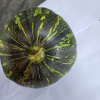

array([[[193,  92,   4],
        [182,  87,   5],
        [174,  90,  18],
        ...,
        [135, 190, 158],
        [138, 193, 161],
        [137, 192, 160]],

       [[194,  95,  12],
        [184,  93,  14],
        [171,  90,  24],
        ...,
        [139, 194, 162],
        [140, 195, 163],
        [140, 195, 163]],

       [[188,  98,  22],
        [179,  95,  23],
        [157,  83,  22],
        ...,
        [138, 195, 162],
        [137, 194, 161],
        [138, 195, 162]],

       ...,

       [[ 12,  44,  31],
        [ 13,  45,  30],
        [  5,  34,  14],
        ...,
        [ 18,   1,   7],
        [ 10,   0,   2],
        [  7,   0,   1]],

       [[ 17,  47,  35],
        [ 16,  47,  32],
        [  8,  35,  16],
        ...,
        [ 16,   0,   5],
        [  8,   0,   0],
        [  6,   0,   0]],

       [[ 24,  54,  42],
        [ 19,  47,  33],
        [ 11,  38,  19],
        ...,
        [ 13,   0,   2],
        [  8,   0,   0],
        [  6,   0,   0]]], dtype=uint8)
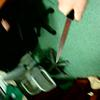

array([[[ 63, 100,   1],
        [ 59,  96,   0],
        [ 54,  92,   0],
        ...,
        [126, 109,  79],
        [118, 101,  74],
        [135, 118,  88]],

       [[ 63, 104,  10],
        [ 61, 103,   4],
        [ 57, 100,   0],
        ...,
        [109,  94,  63],
        [126, 111,  80],
        [144, 130,  95]],

       [[ 44,  82,   5],
        [ 53,  92,   6],
        [ 59, 101,   4],
        ...,
        [118, 105,  71],
        [140, 128,  93],
        [134, 123,  90]],

       ...,

       [[170, 146,  80],
        [171, 146,  87],
        [182, 155, 108],
        ...,
        [110, 119, 107],
        [ 94, 103,  89],
        [110, 119, 105]],

       [[169, 140,  83],
        [175, 146,  91],
        [170, 143,  95],
        ...,
        [ 91,  99,  88],
        [101, 108,  98],
        [104, 111, 102]],

       [[174, 142,  91],
        [173, 142,  91],
        [189, 161, 113],
        ...,
        [ 83,  91,  79],
        [ 74,  81,  72],
        [ 84,  89,  83]]], dtype=uint8)

array([[[ 39,  39,  51],
        [ 42,  42,  55],
        [ 43,  45,  57],
        ...,
        [144, 135, 126],
        [138, 129, 120],
        [137, 128, 119]],

       [[ 40,  40,  52],
        [ 43,  43,  56],
        [ 44,  46,  57],
        ...,
        [145, 136, 127],
        [140, 131, 122],
        [138, 129, 120]],

       [[ 40,  40,  52],
        [ 44,  44,  56],
        [ 44,  46,  57],
        ...,
        [148, 139, 130],
        [143, 134, 125],
        [140, 131, 122]],

       ...,

       [[ 23,  25,  37],
        [ 23,  25,  37],
        [ 24,  26,  38],
        ...,
        [106, 110, 113],
        [109, 113, 116],
        [113, 116, 118]],

       [[ 23,  25,  37],
        [ 24,  26,  38],
        [ 24,  26,  38],
        ...,
        [106, 110, 113],
        [109, 113, 116],
        [116, 119, 119]],

       [[ 23,  25,  37],
        [ 24,  26,  38],
        [ 24,  26,  38],
        ...,
        [107, 110, 114],
        [111, 115, 118],
        [118, 121, 119]]], dtype=uint8)

array([[[ 66,  31,  25],
        [ 53,  27,  22],
        [ 36,  21,  17],
        ...,
        [147, 174, 200],
        [140, 167, 206],
        [129, 152, 205]],

       [[ 58,  24,  22],
        [ 43,  17,  13],
        [ 22,   7,   4],
        ...,
        [118, 144, 161],
        [110, 135, 154],
        [108, 132, 151]],

       [[ 86,  54,  53],
        [ 31,   7,   5],
        [ 24,   9,   7],
        ...,
        [111, 137, 125],
        [109, 135, 111],
        [112, 138,  99]],

       ...,

       [[ 27,  15,  11],
        [ 21,  11,   8],
        [ 23,  15,  13],
        ...,
        [149, 149, 158],
        [211, 213, 225],
        [208, 211, 221]],

       [[ 32,  20,  11],
        [ 27,  17,  10],
        [ 26,  17,  13],
        ...,
        [196, 199, 211],
        [207, 209, 221],
        [203, 201, 213]],

       [[ 35,  23,  12],
        [ 33,  23,  13],
        [ 29,  20,  14],
        ...,
        [199, 205, 217],
        [214, 215, 229],
        [206, 201, 215]]], dtype=uint8)

array([[[ 16,   8,  11],
        [ 14,   8,  10],
        [ 15,   9,  11],
        ...,
        [160,  70, 127],
        [145,  76, 122],
        [128,  95, 138]],

       [[ 19,   9,  11],
        [ 18,   9,  11],
        [ 19,   9,  12],
        ...,
        [214,  82, 139],
        [218,  85, 137],
        [206,  91, 142]],

       [[ 15,  10,  22],
        [ 16,  11,  18],
        [ 18,  13,  13],
        ...,
        [151,  82, 129],
        [163,  92, 141],
        [160,  95, 143]],

       ...,

       [[  6,  10,  13],
        [  4,   8,  11],
        [  5,   8,  11],
        ...,
        [ 60,  54,  45],
        [ 61,  57,  41],
        [ 70,  59,  50]],

       [[  4,   8,  11],
        [  3,   7,  10],
        [  4,   7,  10],
        ...,
        [ 66,  56,  45],
        [ 71,  60,  49],
        [115,  97,  89]],

       [[  5,   9,  12],
        [  4,   8,  11],
        [  4,   7,  11],
        ...,
        [ 54,  42,  22],
        [ 55,  38,  28],
        [137, 112, 100]]], dtype=uint8)
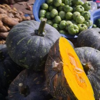

array([[[ 86,  65,  62],
        [ 88,  67,  64],
        [ 90,  69,  66],
        ...,
        [107,  92,  73],
        [107,  92,  73],
        [107,  92,  73]],

       [[ 85,  64,  61],
        [ 87,  66,  63],
        [ 88,  67,  64],
        ...,
        [107,  92,  73],
        [107,  92,  73],
        [107,  92,  73]],

       [[ 84,  63,  60],
        [ 86,  65,  62],
        [ 87,  66,  63],
        ...,
        [107,  92,  73],
        [107,  92,  73],
        [107,  92,  73]],

       ...,

       [[ 64, 107, 126],
        [ 61, 104, 123],
        [ 62, 105, 122],
        ...,
        [146, 125, 108],
        [150, 129, 112],
        [147, 126, 109]],

       [[ 63, 106, 125],
        [ 61, 104, 123],
        [ 62, 105, 122],
        ...,
        [141, 120, 103],
        [145, 124, 107],
        [143, 122, 105]],

       [[ 63, 106, 125],
        [ 60, 103, 122],
        [ 62, 105, 122],
        ...,
        [138, 117, 100],
        [143, 122, 105],
        [141, 120, 103]]], dtype=uint8)
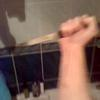

array([[[102, 109,  31],
        [102, 109,  31],
        [103, 110,  32],
        ...,
        [165, 184, 120],
        [165, 184, 120],
        [164, 183, 119]],

       [[102, 109,  31],
        [102, 109,  31],
        [103, 110,  32],
        ...,
        [165, 184, 120],
        [165, 184, 120],
        [164, 183, 119]],

       [[102, 109,  31],
        [103, 110,  32],
        [104, 111,  33],
        ...,
        [165, 184, 120],
        [165, 184, 120],
        [164, 183, 119]],

       ...,

       [[ 98, 103,  23],
        [ 99, 104,  24],
        [ 99, 106,  28],
        ...,
        [ 10,  28,   4],
        [ 78,  98,  71],
        [134, 154, 127]],

       [[ 97, 102,  22],
        [ 98, 103,  23],
        [ 97, 104,  26],
        ...,
        [ 35,  53,  29],
        [115, 135, 108],
        [162, 182, 155]],

       [[ 96, 101,  21],
        [ 97, 102,  22],
        [ 96, 103,  25],
        ...,
        [ 55,  73,  49],
        [137, 157, 130],
        [175, 195, 168]]], dtype=uint8)
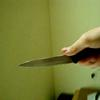

array([[[205, 157, 126],
        [186, 137,  94],
        [200, 152,  99],
        ...,
        [144, 151, 104],
        [ 88, 101,  27],
        [117, 130,  60]],

       [[217, 176, 145],
        [182, 137,  95],
        [186, 140,  90],
        ...,
        [186, 191, 157],
        [ 84,  95,  43],
        [ 55,  65,  18]],

       [[224, 193, 164],
        [211, 174, 136],
        [152, 108,  66],
        ...,
        [225, 228, 213],
        [179, 187, 164],
        [103, 110,  93]],

       ...,

       [[131, 124, 129],
        [129, 122, 125],
        [131, 120, 122],
        ...,
        [165, 164, 173],
        [170, 169, 178],
        [177, 175, 182]],

       [[133, 129, 134],
        [132, 126, 129],
        [135, 124, 126],
        ...,
        [162, 162, 171],
        [165, 166, 172],
        [172, 173, 175]],

       [[131, 129, 134],
        [130, 127, 129],
        [131, 123, 123],
        ...,
        [143, 142, 159],
        [158, 157, 172],
        [165, 165, 178]]], dtype=uint8)
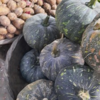

array([[[ 81,  78,  73],
        [ 99,  96,  91],
        [101,  97,  95],
        ...,
        [  8,   7,   4],
        [ 15,  11,   7],
        [ 18,  13,   7]],

       [[ 92,  90,  85],
        [ 90,  88,  84],
        [ 79,  78,  74],
        ...,
        [ 25,  22,  18],
        [ 38,  33,  27],
        [ 40,  32,  24]],

       [[ 84,  83,  78],
        [ 65,  64,  60],
        [ 49,  48,  46],
        ...,
        [ 29,  25,  20],
        [ 37,  30,  23],
        [ 43,  34,  25]],

       ...,

       [[ 93,  87,  61],
        [ 85,  79,  53],
        [ 86,  78,  52],
        ...,
        [ 47,  46,  42],
        [ 82,  81,  77],
        [ 70,  69,  64]],

       [[ 98,  91,  65],
        [ 92,  86,  60],
        [ 87,  79,  53],
        ...,
        [ 18,  17,  13],
        [ 55,  54,  50],
        [ 75,  74,  70]],

       [[ 88,  82,  56],
        [ 88,  81,  55],
        [ 83,  75,  50],
        ...,
        [ 25,  24,  19],
        [ 26,  25,  21],
        [ 45,  44,  40]]], dtype=uint8)
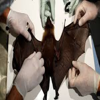

array([[[144, 159, 121],
        [149, 168, 126],
        [109, 132,  80],
        ...,
        [151, 163, 113],
        [148, 156, 113],
        [145, 156, 113]],

       [[134, 151, 109],
        [140, 159, 115],
        [114, 138,  84],
        ...,
        [132, 147,  89],
        [138, 149,  97],
        [137, 149,  98]],

       [[161, 178, 134],
        [144, 163, 118],
        [119, 142,  89],
        ...,
        [111, 129,  63],
        [119, 133,  73],
        [118, 132,  73]],

       ...,

       [[  1,   2,   2],
        [  2,   2,   2],
        [  0,   0,   0],
        ...,
        [127, 117,  90],
        [115, 106,  80],
        [108,  97,  76]],

       [[  1,   2,   1],
        [  0,   1,   0],
        [ 10,  10,   8],
        ...,
        [124, 113,  90],
        [111, 100,  78],
        [111, 100,  81]],

       [[  1,   2,   1],
        [  0,   0,   0],
        [ 58,  59,  55],
        ...,
        [114, 103,  81],
        [115, 104,  84],
        [ 98,  87,  69]]], dtype=uint8)
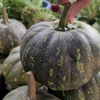

array([[[105, 106, 101],
        [ 86,  87,  82],
        [ 91,  91,  86],
        ...,
        [ 90,  88,  86],
        [ 78,  78,  78],
        [ 72,  73,  69]],

       [[105, 106, 101],
        [ 86,  87,  82],
        [ 91,  91,  86],
        ...,
        [ 99,  94,  89],
        [ 83,  81,  79],
        [ 73,  73,  72]],

       [[105, 106, 101],
        [ 86,  87,  82],
        [ 91,  91,  86],
        ...,
        [108, 101,  96],
        [ 87,  83,  80],
        [ 73,  75,  73]],

       ...,

       [[107, 100,  98],
        [ 74,  66,  64],
        [ 61,  57,  55],
        ...,
        [248, 247, 248],
        [246, 248, 248],
        [246, 248, 247]],

       [[ 83,  84,  83],
        [ 50,  51,  50],
        [ 42,  44,  46],
        ...,
        [235, 230, 223],
        [247, 249, 246],
        [246, 248, 247]],

       [[ 65,  69,  71],
        [ 42,  46,  47],
        [ 37,  43,  48],
        ...,
        [152, 138, 123],
        [232, 231, 227],
        [245, 247, 247]]], dtype=uint8)
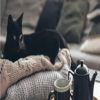

array([[[169, 161, 126],
        [172, 167, 128],
        [179, 174, 132],
        ...,
        [218, 187, 203],
        [216, 185, 203],
        [215, 184, 202]],

       [[181, 177, 133],
        [184, 180, 134],
        [182, 180, 132],
        ...,
        [219, 188, 204],
        [219, 188, 204],
        [215, 184, 201]],

       [[175, 173, 123],
        [166, 165, 114],
        [154, 155, 102],
        ...,
        [213, 182, 198],
        [210, 179, 195],
        [207, 176, 192]],

       ...,

       [[ 31,  35,  29],
        [ 22,  26,  20],
        [ 22,  26,  20],
        ...,
        [ 70,  58,  62],
        [ 69,  57,  61],
        [ 69,  57,  61]],

       [[ 24,  29,  25],
        [ 20,  25,  21],
        [ 17,  22,  17],
        ...,
        [ 67,  56,  60],
        [ 67,  56,  60],
        [ 67,  55,  59]],

       [[ 17,  21,  18],
        [ 14,  18,  17],
        [ 13,  17,  15],
        ...,
        [ 64,  53,  57],
        [ 65,  54,  58],
        [ 63,  52,  56]]], dtype=uint8)
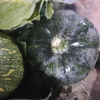

array([[[219, 207, 205],
        [217, 206, 206],
        [218, 206, 204],
        ...,
        [216, 205, 184],
        [216, 205, 183],
        [217, 205, 183]],

       [[221, 211, 210],
        [219, 209, 210],
        [219, 209, 208],
        ...,
        [215, 204, 183],
        [216, 204, 182],
        [217, 205, 183]],

       [[221, 213, 213],
        [221, 213, 215],
        [221, 212, 214],
        ...,
        [215, 204, 183],
        [215, 204, 182],
        [216, 204, 182]],

       ...,

       [[186, 130,  82],
        [187, 133,  86],
        [185, 131,  86],
        ...,
        [ 82,  45,  23],
        [ 84,  44,  24],
        [ 52,  28,  20]],

       [[186, 132,  89],
        [186, 134,  91],
        [186, 135,  96],
        ...,
        [ 32,  25,  18],
        [ 43,  28,  18],
        [ 33,  22,  15]],

       [[187, 133,  89],
        [186, 135,  95],
        [187, 140, 105],
        ...,
        [ 66,  36,  24],
        [ 80,  36,  27],
        [ 70,  33,  23]]], dtype=uint8)
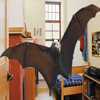

array([[[166, 137, 115],
        [160, 131, 104],
        [167, 138, 105],
        ...,
        [140, 117, 125],
        [ 81,  54,  53],
        [ 52,  23,  15]],

       [[159, 128, 109],
        [147, 116,  90],
        [157, 127,  94],
        ...,
        [135, 110, 119],
        [ 80,  51,  53],
        [ 51,  21,  15]],

       [[166, 135, 118],
        [149, 117,  92],
        [151, 120,  86],
        ...,
        [143, 114, 126],
        [110,  80,  85],
        [ 66,  34,  32]],

       ...,

       [[135, 118, 100],
        [136, 120,  99],
        [139, 125, 101],
        ...,
        [117, 122, 110],
        [116, 121, 107],
        [131, 138, 117]],

       [[137, 119, 101],
        [135, 118,  98],
        [140, 125, 103],
        ...,
        [128, 134, 119],
        [125, 132, 115],
        [133, 141, 120]],

       [[139, 121, 101],
        [134, 117,  97],
        [138, 122, 102],
        ...,
        [140, 147, 128],
        [115, 121, 107],
        [140, 147, 131]]], dtype=uint8)
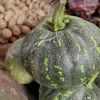

array([[[189, 181, 160],
        [189, 181, 160],
        [189, 181, 160],
        ...,
        [153, 147, 123],
        [153, 147, 123],
        [153, 147, 123]],

       [[189, 181, 160],
        [189, 181, 160],
        [189, 181, 160],
        ...,
        [154, 148, 124],
        [154, 148, 124],
        [154, 148, 124]],

       [[189, 181, 162],
        [189, 181, 162],
        [189, 181, 162],
        ...,
        [154, 148, 126],
        [154, 148, 126],
        [154, 148, 126]],

       ...,

       [[127,  47,  48],
        [113,  39,  40],
        [ 91,  26,  30],
        ...,
        [ 86,  76,  66],
        [ 86,  76,  66],
        [ 87,  77,  67]],

       [[115,  39,  43],
        [103,  32,  36],
        [ 85,  24,  31],
        ...,
        [ 85,  75,  65],
        [ 86,  76,  66],
        [ 87,  77,  67]],

       [[112,  37,  42],
        [100,  31,  36],
        [ 85,  24,  32],
        ...,
        [ 84,  74,  64],
        [ 85,  75,  65],
        [ 86,  76,  66]]], dtype=uint8)
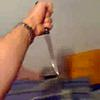

array([[[128,  89,  94],
        [163, 123, 131],
        [162, 126, 134],
        ...,
        [ 77,  62,  76],
        [ 74,  63,  78],
        [ 69,  60,  76]],

       [[137,  98, 103],
        [137,  99, 107],
        [154, 119, 127],
        ...,
        [ 84,  68,  80],
        [ 75,  61,  70],
        [ 85,  72,  80]],

       [[122,  88,  92],
        [124,  91,  97],
        [132, 100, 108],
        ...,
        [ 87,  73,  89],
        [ 82,  67,  80],
        [ 85,  69,  78]],

       ...,

       [[160, 122, 120],
        [162, 124, 122],
        [174, 136, 134],
        ...,
        [170, 170, 123],
        [153, 150,  94],
        [137, 133,  69]],

       [[165, 128, 123],
        [171, 133, 130],
        [174, 136, 135],
        ...,
        [149, 151, 104],
        [144, 143,  89],
        [137, 132,  76]],

       [[180, 143, 137],
        [182, 145, 140],
        [178, 140, 138],
        ...,
        [146, 150, 102],
        [147, 147,  97],
        [150, 148,  96]]], dtype=uint8)
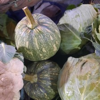

array([[[179, 160, 162],
        [174, 155, 156],
        [165, 146, 147],
        ...,
        [ 94,  86,  83],
        [ 88,  80,  75],
        [ 87,  80,  74]],

       [[179, 161, 166],
        [183, 164, 169],
        [180, 161, 166],
        ...,
        [ 90,  80,  78],
        [ 89,  78,  73],
        [ 88,  76,  70]],

       [[187, 170, 178],
        [184, 166, 174],
        [190, 172, 178],
        ...,
        [ 98,  86,  81],
        [ 95,  80,  75],
        [ 98,  82,  75]],

       ...,

       [[172, 169, 188],
        [170, 167, 186],
        [163, 160, 179],
        ...,
        [128, 127, 138],
        [126, 124, 135],
        [118, 116, 129]],

       [[161, 158, 177],
        [159, 156, 175],
        [162, 159, 178],
        ...,
        [136, 135, 146],
        [124, 122, 133],
        [127, 125, 138]],

       [[161, 158, 177],
        [159, 156, 175],
        [166, 163, 182],
        ...,
        [139, 137, 149],
        [129, 126, 137],
        [127, 125, 136]]], dtype=uint8)

array([[[108, 108, 108],
        [117, 117, 117],
        [114, 114, 114],
        ...,
        [ 54,  54,  54],
        [ 77,  77,  77],
        [117, 117, 117]],

       [[ 84,  84,  84],
        [ 84,  84,  84],
        [ 86,  86,  86],
        ...,
        [ 44,  44,  44],
        [ 38,  38,  38],
        [ 75,  75,  75]],

       [[ 84,  84,  84],
        [ 93,  93,  93],
        [104, 104, 104],
        ...,
        [ 59,  59,  59],
        [ 50,  50,  50],
        [ 61,  61,  61]],

       ...,

       [[169, 169, 169],
        [155, 155, 155],
        [161, 161, 161],
        ...,
        [204, 204, 204],
        [206, 206, 206],
        [210, 210, 210]],

       [[178, 178, 178],
        [161, 161, 161],
        [162, 162, 162],
        ...,
        [189, 189, 189],
        [203, 203, 203],
        [216, 216, 216]],

       [[186, 186, 186],
        [181, 181, 181],
        [170, 170, 170],
        ...,
        [188, 188, 188],
        [205, 205, 205],
        [207, 207, 207]]], dtype=uint8)

array([[[248, 200, 164],
        [250, 205, 166],
        [242, 197, 158],
        ...,
        [133, 112,  95],
        [132, 111,  94],
        [132, 111,  94]],

       [[247, 199, 163],
        [250, 205, 166],
        [242, 197, 158],
        ...,
        [135, 114,  97],
        [134, 113,  96],
        [134, 113,  96]],

       [[246, 198, 162],
        [248, 203, 164],
        [242, 197, 158],
        ...,
        [137, 116,  99],
        [136, 115,  98],
        [136, 115,  98]],

       ...,

       [[ 41,   5,   5],
        [ 41,   5,   7],
        [ 43,   7,   9],
        ...,
        [193, 150, 131],
        [198, 153, 134],
        [200, 155, 136]],

       [[ 39,   5,   6],
        [ 37,   3,   4],
        [ 39,   4,   8],
        ...,
        [192, 149, 130],
        [198, 153, 134],
        [200, 155, 136]],

       [[ 44,  10,  11],
        [ 41,   7,   8],
        [ 42,   7,  13],
        ...,
        [192, 149, 130],
        [198, 153, 134],
        [200, 155, 136]]], dtype=uint8)
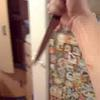

array([[[135, 170, 140],
        [130, 165, 135],
        [125, 160, 130],
        ...,
        [ 24,  18,  20],
        [ 18,  12,  14],
        [  7,   1,   1]],

       [[133, 168, 138],
        [131, 166, 136],
        [129, 164, 134],
        ...,
        [ 24,  14,  13],
        [ 24,  14,  12],
        [ 19,  10,   5]],

       [[125, 162, 131],
        [125, 162, 131],
        [126, 163, 132],
        ...,
        [ 19,   2,   0],
        [ 23,   6,   0],
        [ 34,  18,   5]],

       ...,

       [[128, 167, 112],
        [129, 168, 113],
        [130, 169, 116],
        ...,
        [ 65, 134,  87],
        [ 62, 131,  84],
        [ 61, 130,  83]],

       [[129, 168, 113],
        [129, 168, 113],
        [131, 170, 117],
        ...,
        [ 63, 132,  85],
        [ 60, 129,  82],
        [ 59, 128,  81]],

       [[129, 168, 113],
        [130, 169, 114],
        [131, 170, 117],
        ...,
        [ 62, 131,  84],
        [ 59, 128,  81],
        [ 57, 126,  79]]], dtype=uint8)
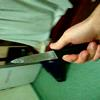

array([[[ 82,  67,  63],
        [ 75,  61,  56],
        [ 79,  67,  60],
        ...,
        [174, 160, 123],
        [184, 170, 135],
        [194, 178, 142]],

       [[ 90,  75,  67],
        [ 97,  84,  75],
        [ 84,  72,  62],
        ...,
        [165, 150, 117],
        [182, 167, 136],
        [181, 165, 130]],

       [[122, 109,  93],
        [111,  99,  83],
        [100,  88,  75],
        ...,
        [164, 148, 121],
        [176, 160, 135],
        [175, 158, 126]],

       ...,

       [[156, 143, 108],
        [126, 116,  87],
        [113, 108,  85],
        ...,
        [ 86,  79,  69],
        [ 98,  89,  74],
        [ 90,  84,  70]],

       [[149, 135, 101],
        [113, 103,  74],
        [114, 109,  86],
        ...,
        [ 87,  80,  70],
        [ 95,  85,  72],
        [100,  94,  80]],

       [[134, 120,  86],
        [102,  92,  63],
        [130, 125, 102],
        ...,
        [ 83,  76,  66],
        [ 98,  88,  75],
        [111, 106,  92]]], dtype=uint8)

array([[[ 83, 107,  59],
        [ 64,  86,  36],
        [ 72,  93,  35],
        ...,
        [ 97, 114,  76],
        [107, 123,  84],
        [105, 121,  84]],

       [[ 69,  92,  46],
        [ 59,  80,  34],
        [ 63,  82,  35],
        ...,
        [101, 117,  76],
        [ 94, 111,  69],
        [ 88, 104,  65]],

       [[ 54,  78,  30],
        [ 40,  61,  18],
        [ 45,  63,  25],
        ...,
        [ 79,  94,  53],
        [ 83,  99,  58],
        [ 85, 101,  62]],

       ...,

       [[130, 129, 126],
        [126, 124, 124],
        [131, 131, 133],
        ...,
        [115, 109,  83],
        [ 99,  97,  87],
        [148, 148, 146]],

       [[160, 156, 152],
        [162, 158, 157],
        [147, 144, 147],
        ...,
        [102,  97,  84],
        [143, 142, 150],
        [216, 219, 232]],

       [[164, 157, 151],
        [174, 167, 164],
        [162, 158, 161],
        ...,
        [142, 137, 136],
        [226, 225, 243],
        [234, 237, 255]]], dtype=uint8)

array([[[111, 160, 253],
        [105, 152, 246],
        [ 58,  98, 200],
        ...,
        [ 12,  18,  19],
        [ 56,  51,  61],
        [142, 119, 140]],

       [[106, 158, 249],
        [ 95, 149, 243],
        [ 53, 101, 202],
        ...,
        [ 37,  31,  36],
        [ 25,  21,  31],
        [ 60,  53,  67]],

       [[101, 156, 245],
        [ 85, 144, 240],
        [ 50, 103, 207],
        ...,
        [118,  96, 106],
        [ 32,  26,  34],
        [ 19,  24,  31]],

       ...,

       [[ 94,  94, 146],
        [104, 103, 154],
        [ 98,  94, 141],
        ...,
        [ 87,  90,  68],
        [166, 173,  63],
        [214, 214, 105]],

       [[106, 105, 153],
        [121, 119, 167],
        [130, 124, 171],
        ...,
        [125, 127, 102],
        [206, 213,  90],
        [237, 231, 138]],

       [[135, 132, 176],
        [139, 134, 179],
        [142, 134, 180],
        ...,
        [ 73,  74,  52],
        [213, 214, 113],
        [242, 235, 144]]], dtype=uint8)
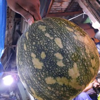

array([[[116, 128, 119],
        [153, 165, 153],
        [111, 124, 105],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[146, 160, 146],
        [177, 191, 174],
        [144, 158, 135],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[143, 160, 139],
        [112, 130, 105],
        [139, 158, 128],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[150, 145, 140],
        [153, 145, 139],
        [151, 143, 136],
        ...,
        [176, 167, 162],
        [182, 173, 166],
        [191, 182, 174]],

       [[149, 143, 138],
        [154, 147, 140],
        [150, 142, 135],
        ...,
        [183, 174, 170],
        [184, 175, 169],
        [197, 189, 179]],

       [[148, 142, 137],
        [154, 147, 141],
        [150, 142, 135],
        ...,
        [185, 176, 172],
        [187, 179, 173],
        [193, 186, 176]]], dtype=uint8)
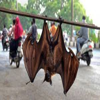

array([[[161, 149, 127],
        [155, 144, 123],
        [156, 145, 126],
        ...,
        [ 62,  51,  52],
        [ 66,  56,  57],
        [ 79,  69,  70]],

       [[166, 155, 131],
        [164, 152, 130],
        [168, 156, 136],
        ...,
        [ 62,  52,  53],
        [ 67,  57,  58],
        [ 81,  71,  72]],

       [[166, 153, 131],
        [169, 155, 135],
        [174, 160, 141],
        ...,
        [ 62,  51,  53],
        [ 66,  56,  58],
        [ 83,  73,  76]],

       ...,

       [[106,  75,  57],
        [ 95,  64,  47],
        [ 89,  59,  41],
        ...,
        [113, 101, 103],
        [116, 104, 106],
        [117, 105, 107]],

       [[103,  71,  56],
        [ 95,  63,  48],
        [ 91,  61,  45],
        ...,
        [124, 114, 115],
        [121, 109, 111],
        [122, 110, 112]],

       [[110,  78,  63],
        [106,  74,  59],
        [ 93,  62,  47],
        ...,
        [111, 100, 102],
        [118, 107, 109],
        [122, 110, 114]]], dtype=uint8)
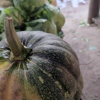

array([[[116,  96,  85],
        [114,  94,  83],
        [115,  97,  85],
        ...,
        [149, 133, 108],
        [143, 129, 103],
        [140, 126, 100]],

       [[118,  98,  87],
        [114,  94,  83],
        [113,  95,  83],
        ...,
        [149, 133, 108],
        [142, 128, 102],
        [138, 124,  98]],

       [[108,  88,  77],
        [104,  84,  73],
        [103,  85,  73],
        ...,
        [149, 134, 111],
        [141, 126, 103],
        [136, 121,  98]],

       ...,

       [[141, 128, 120],
        [138, 125, 117],
        [138, 125, 119],
        ...,
        [220, 171, 154],
        [224, 175, 158],
        [226, 177, 160]],

       [[141, 128, 120],
        [138, 125, 117],
        [138, 125, 119],
        ...,
        [219, 170, 153],
        [224, 175, 158],
        [226, 177, 160]],

       [[141, 128, 120],
        [138, 125, 117],
        [139, 126, 120],
        ...,
        [219, 170, 153],
        [223, 174, 157],
        [226, 177, 160]]], dtype=uint8)
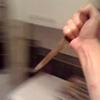

array([[[ 46,  24,  28],
        [ 58,  29,  34],
        [ 64,  32,  38],
        ...,
        [134, 136, 130],
        [137, 136, 132],
        [132, 128, 129]],

       [[ 50,  26,  30],
        [ 62,  32,  38],
        [ 66,  33,  41],
        ...,
        [139, 140, 135],
        [144, 142, 140],
        [137, 134, 134]],

       [[ 54,  28,  32],
        [ 66,  34,  39],
        [ 68,  35,  41],
        ...,
        [146, 143, 143],
        [152, 148, 146],
        [153, 148, 151]],

       ...,

       [[ 99,  98,  98],
        [100,  98,  97],
        [ 98,  98,  96],
        ...,
        [146, 145, 146],
        [148, 146, 148],
        [149, 147, 149]],

       [[ 97,  96,  94],
        [ 97,  97,  95],
        [ 97,  97,  96],
        ...,
        [148, 146, 149],
        [147, 146, 149],
        [148, 147, 148]],

       [[ 95,  94,  92],
        [ 96,  95,  93],
        [ 95,  95,  94],
        ...,
        [153, 151, 154],
        [150, 149, 150],
        [149, 147, 149]]], dtype=uint8)

Cluster 3:
##################################################


array([[[ 41,  60,  92],
        [ 42,  59,  91],
        [ 40,  56,  86],
        ...,
        [ 53,  79, 115],
        [ 50,  73, 111],
        [ 45,  69, 105]],

       [[ 42,  59,  93],
        [ 41,  60,  94],
        [ 39,  58,  88],
        ...,
        [ 53,  81, 121],
        [ 49,  75, 113],
        [ 47,  69, 106]],

       [[ 40,  61,  94],
        [ 38,  60,  94],
        [ 40,  58,  92],
        ...,
        [ 53,  83, 123],
        [ 50,  76, 114],
        [ 48,  70, 108]],

       ...,

       [[ 56,  51,  46],
        [ 68,  58,  46],
        [ 83,  74,  53],
        ...,
        [ 19,  18,  28],
        [ 23,  24,  34],
        [ 22,  23,  34]],

       [[ 48,  46,  44],
        [ 55,  49,  43],
        [ 66,  60,  51],
        ...,
        [ 17,  15,  27],
        [ 21,  22,  33],
        [ 21,  23,  35]],

       [[ 45,  44,  46],
        [ 49,  46,  45],
        [ 55,  54,  51],
        ...,
        [ 17,  15,  27],
        [ 18,  18,  30],
        [ 18,  20,  32]]], dtype=uint8)
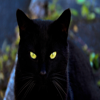

array([[[ 49,  44,  48],
        [ 20,  18,  17],
        [ 10,  10,   7],
        ...,
        [  4,  16,   3],
        [  4,  16,   3],
        [  5,  17,   4]],

       [[ 36,  32,  34],
        [  7,   5,   4],
        [ 12,  11,   9],
        ...,
        [  5,  18,   4],
        [  4,  16,   2],
        [  4,  16,   2]],

       [[ 13,  12,  10],
        [  5,   4,   2],
        [ 15,  14,  12],
        ...,
        [  7,  21,   3],
        [  8,  20,   4],
        [  9,  20,   5]],

       ...,

       [[103, 139,  88],
        [ 49,  80,  33],
        [ 14,  36,   6],
        ...,
        [  5,  28,   3],
        [  3,  30,   2],
        [  8,  38,   5]],

       [[ 78, 110,  65],
        [ 30,  58,  19],
        [ 18,  39,   8],
        ...,
        [  4,  31,   2],
        [  5,  38,   3],
        [  5,  41,   3]],

       [[ 26,  54,  13],
        [ 11,  31,   5],
        [ 16,  31,   8],
        ...,
        [  4,  30,   1],
        [  3,  36,   2],
        [  4,  41,   3]]], dtype=uint8)
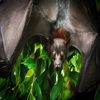

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
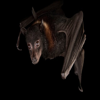

array([[[  3,   3,   3],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [  4,   2,   3],
        [  4,   2,   3],
        [  5,   3,   4]],

       [[  3,   3,   3],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [  4,   2,   3],
        [  4,   2,   3],
        [  5,   3,   4]],

       [[  4,   4,   4],
        [  3,   3,   3],
        [  2,   2,   2],
        ...,
        [  4,   2,   3],
        [  4,   2,   3],
        [  5,   3,   4]],

       ...,

       [[170, 181, 123],
        [ 69,  77,  46],
        [  0,   0,   0],
        ...,
        [  4,   2,   3],
        [  4,   2,   3],
        [  4,   2,   3]],

       [[ 98, 106,  71],
        [ 15,  20,   8],
        [  0,   0,   0],
        ...,
        [  2,   0,   1],
        [  2,   0,   1],
        [  2,   0,   1]],

       [[ 39,  44,  25],
        [ 39,  42,  38],
        [ 41,  42,  45],
        ...,
        [ 45,  43,  44],
        [ 45,  43,  44],
        [ 45,  43,  44]]], dtype=uint8)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
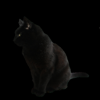

array([[[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 50,  99,  10],
        [ 58, 104,  19],
        [ 45,  92,   9]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 58, 104,  19],
        [ 48,  98,  13],
        [ 49,  97,  13]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 54, 102,  16],
        [ 48,  97,  12],
        [ 57, 101,  17]],

       ...,

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]]], dtype=uint8)
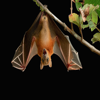

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
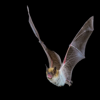

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   1,   0],
        [ 49,  59,  52],
        [199, 229, 220],
        ...,
        [  0,   6,   0],
        [  2,   5,   1],
        [ 11,   1,   1]],

       [[  2,   3,   0],
        [ 48,  60,  53],
        [194, 224, 216],
        ...,
        [  3,   9,   3],
        [  4,   7,   2],
        [ 10,   6,   3]],

       [[  0,   0,   0],
        [ 35,  48,  40],
        [182, 213, 204],
        ...,
        [ 23,  30,  22],
        [  2,   9,   2],
        [ 17,  30,  21]]], dtype=uint8)
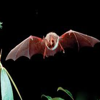

array([[[ 9,  9,  9],
        [10, 10, 10],
        [11, 11, 11],
        ...,
        [18, 17, 13],
        [18, 17, 13],
        [17, 16, 12]],

       [[ 9,  9,  9],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [18, 17, 13],
        [18, 17, 13],
        [18, 17, 13]],

       [[10, 10, 10],
        [11, 11, 11],
        [12, 12, 12],
        ...,
        [19, 18, 14],
        [19, 18, 14],
        [18, 17, 13]],

       ...,

       [[22, 25, 30],
        [24, 27, 32],
        [26, 29, 34],
        ...,
        [ 5,  5,  7],
        [ 4,  4,  6],
        [ 3,  3,  5]],

       [[21, 24, 29],
        [23, 26, 31],
        [24, 27, 32],
        ...,
        [ 4,  4,  6],
        [ 4,  4,  6],
        [ 3,  3,  5]],

       [[21, 24, 29],
        [23, 26, 31],
        [23, 26, 31],
        ...,
        [ 3,  3,  5],
        [ 3,  3,  5],
        [ 3,  3,  5]]], dtype=uint8)
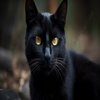

array([[[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[12, 12, 12],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[13, 13, 13],
        [13, 13, 13],
        [13, 13, 13],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       ...,

       [[14, 14, 14],
        [14, 14, 14],
        [13, 13, 13],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[13, 13, 13],
        [13, 13, 13],
        [13, 13, 13],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[13, 13, 13],
        [13, 13, 13],
        [13, 13, 13],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)
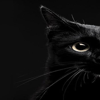

array([[[ 8,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        ...,
        [ 5,  0,  0],
        [ 5,  0,  0],
        [ 5,  0,  0]],

       [[ 8,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        ...,
        [ 5,  0,  0],
        [ 5,  0,  0],
        [ 5,  0,  0]],

       [[ 8,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        ...,
        [ 4,  0,  0],
        [ 4,  0,  0],
        [ 4,  0,  0]],

       ...,

       [[16, 31,  2],
        [13, 27,  1],
        [18, 28,  4],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       [[11, 26,  0],
        [14, 28,  2],
        [21, 31,  7],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       [[11, 26,  0],
        [16, 30,  4],
        [21, 31,  7],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]]], dtype=uint8)
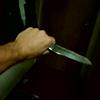

array([[[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[ 6,  6,  6],
        [50, 50, 50],
        [55, 55, 55],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 5,  5,  5],
        [32, 32, 32],
        [32, 32, 32],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1,  1,  1],
        [ 2,  2,  2],
        [ 0,  0,  0],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]]], dtype=uint8)
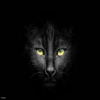

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0, 33, 52],
        [ 0, 24, 45],
        [ 0, 20, 43],
        ...,
        [ 0, 18, 44],
        [ 0, 18, 43],
        [ 0, 18, 43]],

       [[ 0, 27, 47],
        [ 0, 22, 44],
        [ 0, 19, 40],
        ...,
        [ 0, 18, 44],
        [ 0, 18, 44],
        [ 0, 18, 44]],

       [[ 0, 24, 44],
        [ 0, 20, 42],
        [ 0, 17, 37],
        ...,
        [ 0, 18, 44],
        [ 0, 17, 44],
        [ 0, 16, 43]]], dtype=uint8)
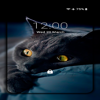

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
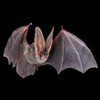

array([[[ 71,  56,  55],
        [ 65,  59,  50],
        [150, 163, 111],
        ...,
        [ 91, 114,  75],
        [ 70,  85,  58],
        [ 37,  32,  29]],

       [[ 61,  46,  49],
        [ 85,  83,  65],
        [170, 186, 130],
        ...,
        [103, 129,  86],
        [ 81,  95,  66],
        [ 39,  31,  30]],

       [[122, 113,  92],
        [120, 120,  94],
        [183, 200, 144],
        ...,
        [113, 135,  91],
        [113, 136,  89],
        [ 32,  38,  27]],

       ...,

       [[ 39,  50,  30],
        [ 65,  83,  47],
        [ 65,  80,  45],
        ...,
        [ 10,  11,   8],
        [  8,   7,   6],
        [  6,   7,   6]],

       [[ 65,  81,  54],
        [ 62,  78,  44],
        [ 52,  70,  36],
        ...,
        [  4,   7,   4],
        [  7,   8,   6],
        [  6,   6,   6]],

       [[ 75,  94,  57],
        [ 60,  78,  44],
        [ 40,  53,  29],
        ...,
        [ 35,  44,  31],
        [  8,  10,   9],
        [  7,   7,   7]]], dtype=uint8)
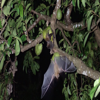

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
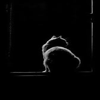

array([[[64, 63, 57],
        [73, 72, 68],
        [69, 67, 62],
        ...,
        [49, 49, 44],
        [54, 54, 47],
        [46, 46, 40]],

       [[60, 60, 52],
        [63, 63, 57],
        [68, 69, 65],
        ...,
        [30, 31, 26],
        [36, 38, 32],
        [35, 34, 31]],

       [[70, 70, 67],
        [71, 71, 68],
        [62, 62, 60],
        ...,
        [11, 12,  9],
        [16, 16, 15],
        [ 6,  6,  5]],

       ...,

       [[28, 23, 18],
        [24, 20, 14],
        [22, 19, 12],
        ...,
        [27, 25, 20],
        [35, 32, 23],
        [35, 31, 22]],

       [[28, 23, 18],
        [26, 22, 16],
        [23, 18, 12],
        ...,
        [28, 24, 19],
        [33, 30, 21],
        [33, 29, 20]],

       [[31, 27, 19],
        [29, 24, 19],
        [24, 19, 14],
        ...,
        [34, 30, 21],
        [31, 28, 19],
        [31, 28, 19]]], dtype=uint8)
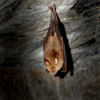

array([[[13, 16, 18],
        [16, 17, 17],
        [19, 17, 17],
        ...,
        [ 7, 15, 18],
        [ 6, 14, 17],
        [ 6, 14, 17]],

       [[15, 16, 17],
        [17, 18, 17],
        [19, 18, 17],
        ...,
        [ 8, 16, 19],
        [ 7, 15, 18],
        [ 7, 15, 18]],

       [[17, 17, 18],
        [19, 18, 17],
        [22, 19, 17],
        ...,
        [10, 18, 21],
        [ 9, 17, 20],
        [ 9, 17, 20]],

       ...,

       [[13, 14, 16],
        [13, 14, 16],
        [13, 14, 16],
        ...,
        [10, 14, 15],
        [10, 14, 15],
        [ 9, 12, 17]],

       [[13, 14, 16],
        [13, 14, 16],
        [13, 14, 16],
        ...,
        [10, 14, 15],
        [10, 14, 15],
        [ 9, 12, 17]],

       [[13, 14, 16],
        [13, 14, 16],
        [13, 14, 16],
        ...,
        [10, 14, 15],
        [10, 14, 15],
        [ 9, 12, 17]]], dtype=uint8)
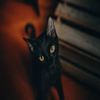

array([[[9, 2, 3],
        [6, 3, 2],
        [4, 2, 1],
        ...,
        [2, 0, 1],
        [2, 0, 1],
        [2, 0, 1]],

       [[7, 3, 2],
        [6, 3, 1],
        [6, 2, 1],
        ...,
        [2, 0, 1],
        [2, 0, 1],
        [2, 0, 1]],

       [[6, 2, 1],
        [5, 2, 1],
        [7, 2, 1],
        ...,
        [2, 0, 1],
        [2, 0, 1],
        [2, 0, 1]],

       ...,

       [[4, 1, 1],
        [3, 1, 1],
        [3, 1, 0],
        ...,
        [9, 2, 2],
        [8, 2, 2],
        [6, 2, 1]],

       [[3, 2, 0],
        [4, 1, 0],
        [4, 1, 0],
        ...,
        [8, 2, 2],
        [8, 2, 2],
        [7, 2, 1]],

       [[3, 1, 0],
        [4, 1, 0],
        [5, 1, 0],
        ...,
        [8, 2, 2],
        [7, 2, 2],
        [7, 2, 1]]], dtype=uint8)
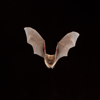

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
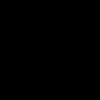

array([[[  4,   4,   4],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [  4,   4,   4],
        [  1,   3,   2],
        [  1,   3,   2]],

       [[  5,   5,   5],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [  5,   4,   4],
        [  2,   2,   2],
        [  3,   4,   4]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  2,   2,   2],
        ...,
        [  3,   2,   2],
        [  3,   3,   3],
        [  3,   3,   3]],

       ...,

       [[167, 187, 104],
        [ 65,  77,  39],
        [  0,   0,   0],
        ...,
        [  6,   2,   3],
        [  6,   2,   3],
        [  6,   2,   3]],

       [[ 92, 102,  63],
        [ 14,  17,   5],
        [  0,   0,   0],
        ...,
        [  3,   0,   1],
        [  3,   0,   0],
        [  2,   0,   0]],

       [[ 28,  27,  34],
        [ 30,  28,  33],
        [ 27,  26,  28],
        ...,
        [ 32,  30,  31],
        [ 31,  29,  30],
        [ 31,  29,  30]]], dtype=uint8)

array([[[11, 13, 13],
        [11, 12, 13],
        [11, 13, 12],
        ...,
        [ 6,  8,  7],
        [ 6,  8,  7],
        [ 6,  8,  7]],

       [[11, 13, 12],
        [11, 13, 12],
        [11, 13, 13],
        ...,
        [ 6,  8,  7],
        [ 6,  8,  7],
        [ 6,  8,  7]],

       [[11, 13, 12],
        [11, 13, 12],
        [11, 13, 12],
        ...,
        [ 6,  8,  7],
        [ 6,  8,  7],
        [ 6,  8,  7]],

       ...,

       [[ 3,  3,  3],
        [ 2,  3,  3],
        [ 2,  2,  2],
        ...,
        [ 7,  9,  9],
        [ 6,  8,  8],
        [ 6,  8,  7]],

       [[ 3,  3,  3],
        [ 2,  3,  3],
        [ 2,  2,  2],
        ...,
        [ 8,  9, 11],
        [ 8,  9, 10],
        [ 8,  9,  9]],

       [[ 3,  3,  3],
        [ 2,  3,  3],
        [ 2,  2,  2],
        ...,
        [10, 11, 12],
        [ 9, 10, 11],
        [ 8, 10, 10]]], dtype=uint8)

array([[[1, 1, 1],
        [2, 2, 2],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [2, 2, 2],
        [4, 4, 4],
        ...,
        [2, 2, 0],
        [2, 2, 0],
        [2, 2, 0]],

       [[1, 1, 1],
        [2, 2, 2],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       ...,

       [[2, 2, 2],
        [1, 1, 1],
        [0, 0, 0],
        ...,
        [6, 6, 6],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [6, 6, 6],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [2, 2, 2],
        ...,
        [6, 6, 6],
        [2, 2, 2],
        [0, 0, 0]]], dtype=uint8)

array([[[ 21,  27,  24],
        [ 17,  24,  15],
        [ 13,  20,   6],
        ...,
        [ 18,  24,  12],
        [ 14,  21,   6],
        [ 12,  19,   2]],

       [[ 18,  27,  23],
        [ 14,  24,  14],
        [ 11,  21,   6],
        ...,
        [ 19,  25,  13],
        [ 16,  22,   7],
        [ 13,  20,   4]],

       [[ 17,  26,  22],
        [ 13,  23,  13],
        [ 10,  21,   5],
        ...,
        [ 20,  27,  15],
        [ 17,  24,   9],
        [ 15,  23,   7]],

       ...,

       [[  2,  12,   1],
        [  4,  14,   3],
        [  6,  16,   5],
        ...,
        [ 96,  96,  96],
        [149, 149, 149],
        [ 11,  11,  11]],

       [[  2,  12,   1],
        [  4,  14,   3],
        [  6,  16,   5],
        ...,
        [ 36,  36,  36],
        [ 31,  31,  31],
        [ 10,  10,  10]],

       [[  2,  12,   1],
        [  4,  14,   3],
        [  6,  16,   5],
        ...,
        [  1,   1,   1],
        [  0,   0,   0],
        [  4,   4,   4]]], dtype=uint8)

array([[[ 23,   4,   0],
        [ 26,   2,   0],
        [ 26,   0,   0],
        ...,
        [135, 134,  77],
        [160, 159, 102],
        [144, 143,  86]],

       [[ 23,   0,   0],
        [ 30,   2,   1],
        [ 33,   0,   1],
        ...,
        [150, 148,  91],
        [171, 169, 112],
        [160, 158, 101]],

       [[ 26,   0,   0],
        [ 36,   2,   0],
        [ 41,   0,   1],
        ...,
        [168, 163, 108],
        [174, 169, 114],
        [164, 159, 104]],

       ...,

       [[ 17,   7,   5],
        [ 12,   2,   0],
        [ 10,   0,   0],
        ...,
        [  1,   1,   0],
        [  1,   1,   0],
        [  1,   1,   0]],

       [[ 17,   7,   5],
        [ 12,   2,   0],
        [ 10,   0,   0],
        ...,
        [  1,   1,   0],
        [  1,   1,   0],
        [  1,   1,   0]],

       [[ 17,   7,   5],
        [ 12,   2,   0],
        [ 10,   0,   0],
        ...,
        [  1,   1,   0],
        [  1,   1,   0],
        [  1,   1,   0]]], dtype=uint8)

array([[[ 3,  3,  5],
        [ 1,  1,  3],
        [ 3,  3,  5],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  2],
        [ 0,  0,  2],
        [ 6,  6,  8],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 4,  4,  6],
        [ 5,  5,  7],
        [13, 13, 15],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 5,  5,  7],
        [ 3,  3,  5],
        [ 2,  2,  4],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[ 2,  2,  4],
        [ 2,  2,  4],
        [ 4,  4,  6],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[ 0,  0,  2],
        [ 2,  2,  4],
        [ 6,  6,  8],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]]], dtype=uint8)
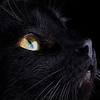

array([[[65, 64, 60],
        [71, 70, 66],
        [70, 69, 65],
        ...,
        [49, 49, 46],
        [54, 54, 53],
        [43, 41, 45]],

       [[61, 60, 56],
        [61, 60, 56],
        [67, 66, 62],
        ...,
        [31, 31, 29],
        [37, 37, 34],
        [39, 39, 34]],

       [[66, 65, 61],
        [74, 73, 69],
        [64, 63, 59],
        ...,
        [14, 14, 12],
        [21, 21, 17],
        [11, 10,  2]],

       ...,

       [[27, 23, 14],
        [25, 21, 12],
        [22, 17, 10],
        ...,
        [30, 26, 17],
        [38, 34, 25],
        [36, 32, 23]],

       [[29, 25, 16],
        [26, 22, 13],
        [23, 18, 11],
        ...,
        [28, 24, 15],
        [34, 30, 21],
        [35, 30, 22]],

       [[33, 28, 22],
        [28, 23, 17],
        [26, 21, 15],
        ...,
        [36, 32, 23],
        [32, 27, 19],
        [32, 27, 21]]], dtype=uint8)

array([[[19, 21, 10],
        [18, 21, 10],
        [19, 23,  9],
        ...,
        [44, 35, 26],
        [45, 36, 27],
        [47, 38, 29]],

       [[18, 20,  9],
        [18, 21, 10],
        [19, 23,  9],
        ...,
        [44, 35, 26],
        [45, 36, 27],
        [47, 38, 29]],

       [[17, 19,  8],
        [17, 20,  9],
        [17, 21,  7],
        ...,
        [44, 35, 26],
        [46, 37, 28],
        [47, 38, 29]],

       ...,

       [[52, 47, 41],
        [53, 48, 42],
        [54, 49, 43],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 9,  9,  9]],

       [[49, 44, 38],
        [50, 45, 39],
        [51, 46, 40],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 9,  9,  9]],

       [[51, 46, 40],
        [52, 47, 41],
        [53, 48, 42],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 9,  9,  9]]], dtype=uint8)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
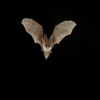

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
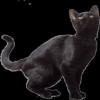

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

array([[[ 20,   1,  20],
        [ 20,   1,  20],
        [ 20,   1,  20],
        ...,
        [ 27,   4,  19],
        [ 23,   0,  17],
        [ 21,   0,  18]],

       [[ 20,   1,  20],
        [ 20,   1,  20],
        [ 20,   1,  20],
        ...,
        [ 20,   4,  22],
        [ 46,  30,  50],
        [ 85,  67,  91]],

       [[ 20,   1,  20],
        [ 20,   1,  20],
        [ 20,   1,  20],
        ...,
        [104,  93, 121],
        [137, 126, 155],
        [138, 127, 157]],

       ...,

       [[ 14,   2,   6],
        [ 16,   2,   8],
        [ 18,   3,  11],
        ...,
        [ 12,   1,   5],
        [ 11,   0,   4],
        [  9,   0,   3]],

       [[ 13,   1,   3],
        [ 15,   1,   4],
        [ 17,   2,   6],
        ...,
        [ 11,   0,   4],
        [  9,   0,   3],
        [  8,   0,   2]],

       [[ 12,   1,   0],
        [ 14,   1,   1],
        [ 16,   2,   3],
        ...,
        [ 10,   0,   3],
        [  8,   0,   2],
        [  8,   0,   2]]], dtype=uint8)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
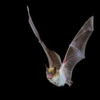

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
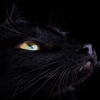

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
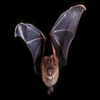

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
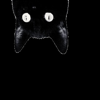

array([[[25, 42, 32],
        [24, 41, 30],
        [22, 37, 28],
        ...,
        [33, 36, 41],
        [32, 35, 40],
        [30, 33, 38]],

       [[25, 42, 32],
        [24, 40, 30],
        [22, 37, 27],
        ...,
        [33, 36, 41],
        [32, 35, 40],
        [31, 34, 39]],

       [[24, 41, 31],
        [23, 39, 29],
        [21, 36, 26],
        ...,
        [34, 37, 42],
        [34, 37, 42],
        [33, 36, 41]],

       ...,

       [[18, 18, 26],
        [19, 19, 27],
        [21, 21, 29],
        ...,
        [43, 28, 23],
        [41, 26, 21],
        [40, 25, 20]],

       [[17, 17, 25],
        [19, 19, 27],
        [20, 20, 28],
        ...,
        [43, 28, 23],
        [41, 26, 21],
        [40, 25, 20]],

       [[17, 17, 25],
        [18, 18, 26],
        [19, 19, 27],
        ...,
        [43, 28, 23],
        [41, 26, 21],
        [40, 25, 20]]], dtype=uint8)
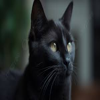

array([[[ 82,  58,  32],
        [ 82,  58,  32],
        [ 80,  56,  30],
        ...,
        [206, 145,  82],
        [208, 147,  84],
        [211, 150,  87]],

       [[ 82,  58,  32],
        [ 82,  58,  32],
        [ 81,  57,  31],
        ...,
        [201, 140,  78],
        [209, 148,  85],
        [218, 157,  94]],

       [[ 82,  58,  32],
        [ 82,  58,  32],
        [ 83,  59,  33],
        ...,
        [202, 139,  75],
        [212, 149,  85],
        [222, 159,  95]],

       ...,

       [[  3,   1,   4],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [  4,   0,   2],
        [ 25,   7,   1],
        [ 63,  34,  16]],

       [[  3,   1,   4],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [  2,   1,   2],
        [ 12,   1,   0],
        [ 42,  21,  11]],

       [[  3,   1,   4],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [  2,   3,   3],
        [  6,   0,   0],
        [ 29,  15,   9]]], dtype=uint8)
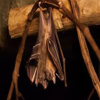

array([[[10, 11, 16],
        [10, 11, 16],
        [10, 11, 16],
        ...,
        [17, 35, 11],
        [18, 36, 12],
        [19, 37, 13]],

       [[10, 11, 16],
        [10, 11, 16],
        [10, 11, 16],
        ...,
        [17, 35, 11],
        [18, 36, 12],
        [19, 37, 13]],

       [[10, 11, 16],
        [10, 11, 16],
        [10, 11, 16],
        ...,
        [17, 35, 11],
        [17, 35, 11],
        [18, 36, 12]],

       ...,

       [[20, 33, 24],
        [17, 28, 22],
        [15, 23, 20],
        ...,
        [20, 32, 20],
        [20, 32, 20],
        [19, 31, 19]],

       [[17, 28, 21],
        [13, 24, 18],
        [12, 20, 17],
        ...,
        [20, 32, 20],
        [20, 32, 20],
        [19, 31, 19]],

       [[14, 25, 19],
        [11, 21, 15],
        [10, 18, 16],
        ...,
        [20, 32, 20],
        [20, 32, 20],
        [19, 31, 19]]], dtype=uint8)
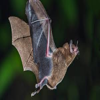

array([[[60, 63, 49],
        [ 3,  4,  0],
        [ 6,  7,  4],
        ...,
        [25, 25, 14],
        [ 2,  4,  0],
        [ 0,  1,  0]],

       [[61, 63, 50],
        [ 6,  7,  1],
        [ 4,  5,  3],
        ...,
        [41, 42, 26],
        [ 8, 10,  3],
        [ 0,  1,  0]],

       [[51, 53, 44],
        [ 2,  3,  0],
        [ 8,  7,  5],
        ...,
        [53, 54, 29],
        [22, 23, 14],
        [ 4,  4,  3]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)
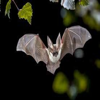

array([[[ 82,  58,  30],
        [ 83,  61,  32],
        [ 79,  58,  29],
        ...,
        [207, 144,  79],
        [209, 147,  84],
        [216, 154,  89]],

       [[ 81,  57,  29],
        [ 81,  60,  30],
        [ 78,  57,  28],
        ...,
        [201, 139,  73],
        [208, 147,  81],
        [220, 159,  97]],

       [[ 81,  57,  29],
        [ 78,  57,  28],
        [ 78,  56,  28],
        ...,
        [201, 140,  75],
        [211, 150,  86],
        [218, 156,  91]],

       ...,

       [[  2,   0,   3],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [  1,   0,   1],
        [ 14,   5,   3],
        [ 71,  36,  13]],

       [[  3,   1,   4],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [  1,   1,   0],
        [  2,   1,   4],
        [ 41,  20,   8]],

       [[  3,   1,   4],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [  0,   1,   1],
        [  2,   1,   1],
        [ 25,  13,   9]]], dtype=uint8)
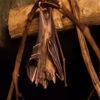

array([[[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)
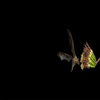

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
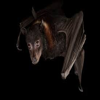

array([[[15, 17, 16],
        [15, 17, 16],
        [15, 17, 16],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [13, 14, 14]],

       [[15, 17, 16],
        [15, 17, 16],
        [15, 17, 16],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[15, 17, 16],
        [15, 17, 16],
        [15, 17, 16],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 15, 14]],

       ...,

       [[15, 17, 16],
        [15, 17, 16],
        [15, 17, 16],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[15, 17, 16],
        [15, 17, 16],
        [15, 17, 16],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[14, 16, 15],
        [14, 16, 15],
        [14, 16, 15],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]]], dtype=uint8)
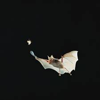

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
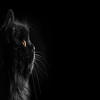

Cluster 1:
##################################################


array([[[118, 118, 115],
        [ 97,  98,  93],
        [ 82,  84,  78],
        ...,
        [ 17,  16,  22],
        [ 16,  15,  21],
        [ 18,  17,  23]],

       [[124, 123, 120],
        [102, 101,  97],
        [ 44,  45,  40],
        ...,
        [ 16,  15,  20],
        [ 13,  12,  17],
        [ 14,  13,  18]],

       [[ 98,  93,  92],
        [121, 118, 114],
        [ 56,  55,  51],
        ...,
        [ 17,  16,  21],
        [ 14,  13,  19],
        [ 20,  19,  24]],

       ...,

       [[ 54,  61,  65],
        [ 56,  62,  65],
        [ 55,  59,  62],
        ...,
        [ 90,  80,  68],
        [117, 106,  85],
        [108,  96,  70]],

       [[ 63,  69,  75],
        [ 67,  71,  76],
        [ 64,  65,  69],
        ...,
        [107,  95,  78],
        [116, 104,  82],
        [102,  91,  66]],

       [[ 72,  76,  83],
        [ 72,  75,  81],
        [ 57,  57,  62],
        ...,
        [109,  94,  75],
        [119, 106,  83],
        [102,  91,  68]]], dtype=uint8)
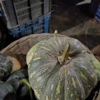

array([[[144, 127, 126],
        [141, 123, 123],
        [140, 122, 122],
        ...,
        [178, 110, 127],
        [131,  77,  90],
        [ 98,  56,  65]],

       [[ 91,  77,  73],
        [ 90,  76,  73],
        [ 89,  74,  71],
        ...,
        [152,  80,  99],
        [136,  71,  87],
        [146,  90, 103]],

       [[ 85,  73,  69],
        [ 89,  77,  73],
        [ 90,  78,  74],
        ...,
        [159,  86, 105],
        [157,  83, 102],
        [158,  87, 104]],

       ...,

       [[ 69,  90,  71],
        [ 78,  94,  71],
        [145, 152, 124],
        ...,
        [ 63,  60,  61],
        [ 51,  49,  53],
        [ 42,  41,  45]],

       [[ 78,  88,  65],
        [ 85,  94,  56],
        [ 98, 104,  54],
        ...,
        [ 54,  53,  57],
        [ 57,  56,  64],
        [ 35,  35,  44]],

       [[ 88,  87,  62],
        [111, 112,  65],
        [119, 123,  59],
        ...,
        [ 35,  35,  39],
        [ 58,  58,  67],
        [ 41,  42,  54]]], dtype=uint8)
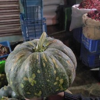

array([[[ 36,  37,  36],
        [ 38,  41,  40],
        [ 59,  65,  65],
        ...,
        [ 65,  67,  79],
        [131, 133, 145],
        [137, 137, 149]],

       [[ 51,  50,  47],
        [ 40,  42,  39],
        [ 47,  53,  52],
        ...,
        [ 91,  94, 105],
        [136, 139, 149],
        [135, 136, 145]],

       [[ 71,  68,  63],
        [ 45,  46,  41],
        [ 36,  40,  37],
        ...,
        [126, 129, 139],
        [134, 137, 146],
        [138, 138, 146]],

       ...,

       [[113, 114, 114],
        [118, 121, 123],
        [ 95, 101, 103],
        ...,
        [ 33,  32,  38],
        [ 26,  25,  31],
        [ 34,  33,  39]],

       [[121, 126, 123],
        [108, 114, 113],
        [ 90,  98,  97],
        ...,
        [ 40,  39,  45],
        [ 34,  33,  39],
        [ 36,  35,  41]],

       [[113, 121, 115],
        [ 96, 104, 102],
        [ 82,  92,  88],
        ...,
        [ 38,  37,  43],
        [ 44,  43,  49],
        [ 41,  40,  46]]], dtype=uint8)
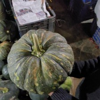

array([[[0, 3, 0],
        [0, 3, 0],
        [0, 2, 0],
        ...,
        [0, 0, 4],
        [0, 0, 4],
        [0, 0, 4]],

       [[0, 3, 0],
        [0, 3, 0],
        [0, 2, 0],
        ...,
        [0, 0, 4],
        [0, 0, 4],
        [0, 0, 4]],

       [[0, 2, 0],
        [0, 2, 0],
        [0, 2, 0],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
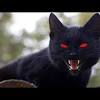

array([[[ 78,  45,   0],
        [ 76,  43,   0],
        [ 76,  43,   0],
        ...,
        [ 67,  54,   9],
        [ 67,  54,   9],
        [ 68,  55,  10]],

       [[ 86,  52,   7],
        [ 85,  52,   7],
        [ 84,  51,   6],
        ...,
        [ 67,  54,   9],
        [ 67,  54,   9],
        [ 68,  55,  10]],

       [[ 89,  52,   7],
        [ 88,  54,   8],
        [ 89,  55,   9],
        ...,
        [ 67,  54,   9],
        [ 68,  55,  10],
        [ 68,  55,  10]],

       ...,

       [[109,  16,   0],
        [114,  21,   4],
        [116,  23,   6],
        ...,
        [ 75,   5,   0],
        [ 71,   0,   0],
        [ 74,   3,   0]],

       [[106,  13,   0],
        [111,  18,   1],
        [114,  21,   4],
        ...,
        [ 75,   5,   0],
        [ 71,   0,   0],
        [ 74,   3,   0]],

       [[103,  10,   0],
        [108,  15,   0],
        [112,  19,   2],
        ...,
        [ 75,   5,   0],
        [ 71,   0,   0],
        [ 74,   3,   0]]], dtype=uint8)
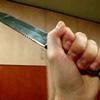

array([[[105, 108, 101],
        [ 81,  82,  76],
        [ 60,  59,  54],
        ...,
        [162, 130, 115],
        [149, 117, 102],
        [110,  78,  63]],

       [[ 99, 101,  96],
        [ 83,  84,  79],
        [ 60,  59,  55],
        ...,
        [125,  93,  78],
        [141, 109,  94],
        [136, 104,  89]],

       [[103, 105, 102],
        [ 97,  97,  95],
        [ 81,  80,  78],
        ...,
        [ 80,  48,  33],
        [117,  85,  70],
        [141, 109,  94]],

       ...,

       [[140, 131, 122],
        [140, 131, 122],
        [142, 133, 124],
        ...,
        [ 47,  12,  16],
        [ 45,  10,  14],
        [ 44,   9,  13]],

       [[140, 131, 122],
        [140, 131, 122],
        [142, 133, 124],
        ...,
        [ 48,  13,  17],
        [ 46,  11,  15],
        [ 46,  11,  15]],

       [[140, 131, 122],
        [140, 131, 122],
        [142, 133, 124],
        ...,
        [ 50,  15,  19],
        [ 48,  13,  17],
        [ 47,  12,  16]]], dtype=uint8)
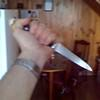

array([[[163, 130, 147],
        [141, 107, 121],
        [ 92,  55,  64],
        ...,
        [ 43,  55,  44],
        [ 24,  32,  31],
        [  5,  10,  13]],

       [[165, 132, 149],
        [156, 122, 136],
        [106,  70,  79],
        ...,
        [ 21,  37,  35],
        [ 15,  27,  40],
        [ 28,  38,  62]],

       [[169, 134, 152],
        [170, 134, 150],
        [132,  96, 108],
        ...,
        [ 76,  97, 122],
        [106, 126, 163],
        [135, 155, 193]],

       ...,

       [[ 22,  11,  15],
        [ 20,  10,  14],
        [ 18,   8,  12],
        ...,
        [136, 135, 143],
        [161, 166, 184],
        [122, 131, 155]],

       [[ 29,  14,  19],
        [ 28,  14,  19],
        [ 25,  13,  17],
        ...,
        [ 78,  75,  85],
        [127, 131, 152],
        [176, 187, 213]],

       [[ 33,  15,  21],
        [ 32,  16,  22],
        [ 31,  17,  21],
        ...,
        [ 46,  42,  53],
        [156, 160, 182],
        [209, 218, 247]]], dtype=uint8)
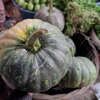

array([[[ 58,  42,  38],
        [ 61,  48,  54],
        [ 77,  73,  89],
        ...,
        [132, 159,  98],
        [128, 154, 101],
        [100, 123,  75]],

       [[140, 117, 100],
        [ 93,  76,  69],
        [ 62,  56,  63],
        ...,
        [107, 123,  56],
        [142, 146, 101],
        [119, 112,  80]],

       [[172, 140, 109],
        [140, 116,  97],
        [ 81,  68,  67],
        ...,
        [122, 132,  68],
        [166, 166, 119],
        [172, 165, 127]],

       ...,

       [[ 74,  68,  56],
        [ 75,  70,  58],
        [ 74,  71,  56],
        ...,
        [189, 189, 200],
        [199, 199, 209],
        [202, 202, 211]],

       [[ 78,  71,  59],
        [ 74,  67,  54],
        [ 70,  65,  50],
        ...,
        [190, 189, 201],
        [202, 202, 212],
        [195, 195, 205]],

       [[ 71,  64,  50],
        [ 65,  59,  44],
        [ 78,  73,  56],
        ...,
        [197, 195, 206],
        [203, 203, 213],
        [224, 224, 234]]], dtype=uint8)
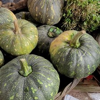

array([[[ 15,  25,  27],
        [ 18,  28,  30],
        [ 19,  31,  33],
        ...,
        [103, 105,  91],
        [107, 103,  90],
        [100,  92,  79]],

       [[ 15,  25,  27],
        [ 18,  28,  30],
        [ 19,  31,  33],
        ...,
        [ 95,  96,  83],
        [112, 108,  95],
        [120, 112,  99]],

       [[ 15,  25,  27],
        [ 18,  28,  30],
        [ 19,  31,  33],
        ...,
        [115, 114, 101],
        [120, 116, 103],
        [132, 123, 111]],

       ...,

       [[148, 135, 127],
        [117, 103,  94],
        [166, 151, 142],
        ...,
        [117,  89,  67],
        [114,  86,  64],
        [119,  91,  69]],

       [[144, 131, 123],
        [119, 106,  97],
        [164, 149, 140],
        ...,
        [116,  88,  66],
        [117,  89,  67],
        [119,  91,  69]],

       [[131, 118, 110],
        [120, 106,  97],
        [166, 151, 141],
        ...,
        [117,  89,  67],
        [121,  93,  71],
        [119,  91,  69]]], dtype=uint8)
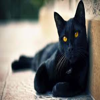

array([[[207, 207, 207],
        [205, 205, 204],
        [203, 203, 200],
        ...,
        [ 13,   9,   4],
        [ 16,  11,   7],
        [ 15,  13,   8]],

       [[210, 210, 210],
        [211, 211, 210],
        [208, 209, 206],
        ...,
        [ 14,   9,   5],
        [ 17,  12,   8],
        [ 16,  14,   9]],

       [[216, 216, 216],
        [216, 216, 214],
        [209, 210, 207],
        ...,
        [ 12,  10,   5],
        [ 16,  13,   8],
        [ 17,  15,  10]],

       ...,

       [[ 67,  63,  60],
        [ 67,  65,  61],
        [ 67,  66,  62],
        ...,
        [ 20,  20,  20],
        [ 22,  22,  22],
        [ 23,  23,  23]],

       [[ 66,  62,  59],
        [ 66,  65,  60],
        [ 66,  65,  61],
        ...,
        [ 18,  18,  18],
        [ 19,  19,  19],
        [ 20,  20,  20]],

       [[ 63,  62,  58],
        [ 65,  64,  60],
        [ 64,  63,  60],
        ...,
        [ 17,  17,  16],
        [ 17,  17,  16],
        [ 17,  18,  16]]], dtype=uint8)
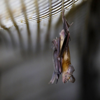

array([[[197, 186, 132],
        [196, 185, 131],
        [196, 185, 131],
        ...,
        [213, 192, 129],
        [214, 193, 130],
        [215, 194, 131]],

       [[197, 186, 132],
        [197, 186, 132],
        [196, 185, 131],
        ...,
        [213, 192, 129],
        [212, 191, 128],
        [210, 189, 126]],

       [[198, 187, 133],
        [197, 186, 132],
        [197, 186, 132],
        ...,
        [210, 189, 126],
        [211, 190, 127],
        [212, 191, 128]],

       ...,

       [[ 47,  80,  51],
        [133, 166, 137],
        [168, 201, 174],
        ...,
        [  0,   4,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[ 57,  90,  61],
        [147, 180, 151],
        [176, 209, 182],
        ...,
        [  0,   5,   0],
        [  0,   5,   0],
        [  0,   5,   0]],

       [[ 69, 102,  73],
        [160, 193, 164],
        [183, 216, 189],
        ...,
        [  1,   6,   0],
        [  1,   6,   0],
        [  1,   6,   0]]], dtype=uint8)
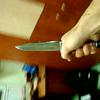

array([[[132, 120, 121],
        [134, 122, 124],
        [131, 121, 124],
        ...,
        [154, 132, 122],
        [167, 144, 136],
        [160, 139, 134]],

       [[ 90,  79,  75],
        [ 90,  79,  77],
        [ 84,  74,  73],
        ...,
        [142, 119, 108],
        [159, 135, 127],
        [152, 132, 125]],

       [[ 88,  77,  71],
        [ 85,  74,  69],
        [ 84,  73,  71],
        ...,
        [127, 105,  94],
        [127, 105,  96],
        [105,  86,  78]],

       ...,

       [[  5,   7,   6],
        [  4,   5,   5],
        [  5,   4,   6],
        ...,
        [  1,   1,   2],
        [  3,   3,   3],
        [  5,   5,   5]],

       [[  6,   8,   7],
        [  3,   5,   4],
        [  4,   6,   5],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  5,   5,   5]],

       [[  8,   9,  10],
        [  4,   5,   5],
        [  4,   7,   6],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  5,   5,   5]]], dtype=uint8)
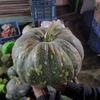

array([[[167, 132, 146],
        [162, 129, 145],
        [121,  89, 102],
        ...,
        [ 58,  82,  59],
        [ 36,  51,  40],
        [ 19,  29,  18]],

       [[166, 132, 147],
        [165, 133, 148],
        [145, 113, 127],
        ...,
        [ 37,  55,  39],
        [ 21,  31,  29],
        [  1,   9,  11]],

       [[169, 136, 150],
        [168, 136, 152],
        [164, 132, 146],
        ...,
        [ 23,  37,  37],
        [ 29,  41,  57],
        [ 54,  65,  90]],

       ...,

       [[ 19,  11,  14],
        [ 17,   9,  11],
        [ 16,   6,   9],
        ...,
        [150, 149, 159],
        [160, 163, 183],
        [110, 116, 143]],

       [[ 23,  12,  16],
        [ 22,  11,  15],
        [ 21,   9,  13],
        ...,
        [ 89,  87,  99],
        [125, 130, 152],
        [171, 179, 208]],

       [[ 24,  12,  16],
        [ 28,  14,  18],
        [ 29,  15,  19],
        ...,
        [ 45,  42,  54],
        [155, 160, 183],
        [213, 221, 253]]], dtype=uint8)
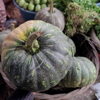

array([[[ 0,  6,  1],
        [ 0,  6,  1],
        [ 0,  6,  1],
        ...,
        [ 0,  5,  1],
        [ 0,  5,  1],
        [ 0,  5,  1]],

       [[ 0,  6,  1],
        [ 0,  6,  1],
        [ 0,  6,  1],
        ...,
        [ 0,  6,  0],
        [ 0,  5,  1],
        [ 0,  6,  0]],

       [[ 0,  6,  1],
        [ 0,  6,  1],
        [ 0,  6,  1],
        ...,
        [ 0,  7,  0],
        [ 0,  7,  0],
        [ 0,  7,  0]],

       ...,

       [[66, 74, 37],
        [65, 75, 38],
        [66, 76, 39],
        ...,
        [29,  0,  0],
        [29,  0,  0],
        [29,  0,  0]],

       [[63, 71, 34],
        [62, 72, 35],
        [64, 74, 37],
        ...,
        [29,  0,  0],
        [29,  0,  0],
        [29,  0,  0]],

       [[62, 70, 33],
        [61, 71, 34],
        [63, 73, 36],
        ...,
        [30,  0,  0],
        [30,  0,  0],
        [30,  0,  0]]], dtype=uint8)
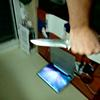

array([[[  6,   5,   3],
        [ 10,   9,   7],
        [ 11,  10,   8],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  7,   6,   4],
        [  9,   8,   6],
        [  9,   8,   6],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  9,   8,   6],
        [  7,   6,   4],
        [  6,   5,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[136, 101,  62],
        [147, 113,  68],
        [144, 111,  60],
        ...,
        [126, 101,  64],
        [117,  96,  63],
        [129, 108,  77]],

       [[138, 103,  65],
        [156, 122,  77],
        [154, 121,  71],
        ...,
        [134, 110,  73],
        [118,  97,  64],
        [120,  99,  68]],

       [[129,  94,  56],
        [155, 121,  77],
        [162, 128,  79],
        ...,
        [136, 112,  75],
        [114,  93,  60],
        [125, 104,  73]]], dtype=uint8)
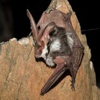

array([[[ 17,  21,  15],
        [ 15,  22,  16],
        [ 13,  23,  17],
        ...,
        [106, 104, 125],
        [103, 102, 120],
        [100,  99, 115]],

       [[ 13,  21,  20],
        [ 12,  21,  20],
        [ 10,  22,  20],
        ...,
        [107, 105, 126],
        [104, 103, 121],
        [101, 100, 116]],

       [[  5,  20,  26],
        [  4,  20,  26],
        [  5,  21,  27],
        ...,
        [108, 106, 127],
        [106, 105, 122],
        [104, 103, 119]],

       ...,

       [[ 12,  17,  37],
        [ 12,  15,  36],
        [ 16,  17,  42],
        ...,
        [ 56,  62,  55],
        [ 43,  47,  40],
        [ 12,  14,   8]],

       [[  8,  13,  32],
        [  8,  13,  32],
        [  9,  11,  32],
        ...,
        [ 52,  58,  52],
        [ 24,  28,  24],
        [  2,   3,   0]],

       [[  8,  15,  30],
        [ 10,  16,  32],
        [ 11,  14,  32],
        ...,
        [ 36,  41,  38],
        [  4,   7,   5],
        [  1,   2,   1]]], dtype=uint8)
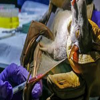

array([[[190, 223, 180],
        [190, 223, 180],
        [190, 223, 180],
        ...,
        [  0,  11,   1],
        [  1,  14,   4],
        [  0,  13,   3]],

       [[192, 225, 182],
        [192, 225, 182],
        [192, 225, 182],
        ...,
        [  0,   8,   0],
        [  0,  11,   0],
        [  0,  12,   0]],

       [[194, 227, 184],
        [194, 227, 184],
        [192, 227, 185],
        ...,
        [  0,   6,   0],
        [  0,  11,   0],
        [  0,  13,   0]],

       ...,

       [[ 94,  67,  12],
        [ 93,  66,  11],
        [ 97,  72,  16],
        ...,
        [188, 174, 125],
        [184, 170, 121],
        [182, 168, 119]],

       [[ 97,  70,  15],
        [ 97,  70,  15],
        [100,  75,  19],
        ...,
        [187, 173, 124],
        [182, 168, 119],
        [181, 167, 118]],

       [[101,  74,  19],
        [100,  73,  18],
        [103,  78,  22],
        ...,
        [185, 171, 122],
        [181, 167, 118],
        [179, 165, 116]]], dtype=uint8)
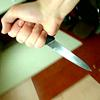

array([[[ 69,  26,  46],
        [ 70,  27,  46],
        [ 69,  28,  44],
        ...,
        [139, 117, 103],
        [161, 139, 125],
        [169, 147, 133]],

       [[ 72,  29,  49],
        [ 73,  30,  49],
        [ 72,  31,  45],
        ...,
        [168, 145, 127],
        [173, 150, 132],
        [174, 151, 133]],

       [[ 80,  37,  56],
        [ 80,  37,  54],
        [ 79,  38,  52],
        ...,
        [187, 159, 135],
        [183, 155, 131],
        [181, 153, 129]],

       ...,

       [[236, 182, 158],
        [238, 184, 160],
        [233, 179, 155],
        ...,
        [ 32,   4,  26],
        [ 31,   3,  25],
        [ 31,   3,  25]],

       [[236, 182, 158],
        [237, 183, 159],
        [229, 175, 151],
        ...,
        [ 32,   4,  26],
        [ 31,   3,  25],
        [ 31,   3,  25]],

       [[236, 182, 158],
        [234, 180, 156],
        [226, 172, 148],
        ...,
        [ 32,   4,  26],
        [ 31,   3,  25],
        [ 31,   3,  25]]], dtype=uint8)
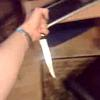

array([[[149, 167, 151],
        [152, 170, 154],
        [155, 173, 159],
        ...,
        [  0,   4,   0],
        [  0,   2,   0],
        [  0,   2,   0]],

       [[150, 168, 152],
        [150, 168, 152],
        [150, 168, 154],
        ...,
        [ 12,  17,  11],
        [ 10,  15,   9],
        [  8,  13,   7]],

       [[154, 172, 156],
        [152, 170, 154],
        [148, 169, 154],
        ...,
        [ 16,  23,  16],
        [ 16,  23,  16],
        [ 16,  23,  16]],

       ...,

       [[ 90, 103,  93],
        [119, 132, 122],
        [133, 146, 136],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]],

       [[ 35,  48,  38],
        [ 89, 102,  92],
        [106, 119, 109],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]],

       [[  7,  20,  10],
        [ 69,  82,  72],
        [ 90, 103,  93],
        ...,
        [  1,   3,   0],
        [  1,   3,   0],
        [  1,   3,   0]]], dtype=uint8)
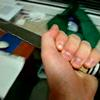

array([[[177, 156, 113],
        [178, 157, 114],
        [179, 158, 115],
        ...,
        [106,  14,   3],
        [105,  13,   2],
        [104,  12,   1]],

       [[175, 154, 111],
        [177, 156, 113],
        [178, 157, 114],
        ...,
        [106,  14,   3],
        [106,  14,   3],
        [105,  13,   2]],

       [[174, 153, 110],
        [176, 155, 112],
        [178, 157, 114],
        ...,
        [107,  15,   2],
        [106,  14,   1],
        [105,  13,   0]],

       ...,

       [[ 75,  11,   1],
        [ 77,  13,   1],
        [ 83,  15,   2],
        ...,
        [196, 144, 104],
        [138,  85,  54],
        [ 59,   5,   0]],

       [[ 74,  10,   0],
        [ 76,  12,   0],
        [ 83,  15,   2],
        ...,
        [193, 141, 101],
        [140,  87,  56],
        [ 61,   7,   0]],

       [[ 73,   9,   0],
        [ 76,  12,   0],
        [ 83,  15,   2],
        ...,
        [187, 135,  95],
        [138,  85,  54],
        [ 60,   6,   0]]], dtype=uint8)
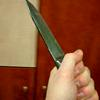

array([[[ 83, 107,   5],
        [ 84, 109,   3],
        [ 82, 109,   3],
        ...,
        [ 39,  72,   4],
        [ 55,  89,   4],
        [103, 142,  12]],

       [[ 86, 112,   4],
        [ 84, 109,   3],
        [ 78, 112,   4],
        ...,
        [ 50,  83,   5],
        [ 42,  73,   4],
        [ 70, 106,   5]],

       [[ 86, 108,   4],
        [ 81, 108,   4],
        [ 81, 116,   3],
        ...,
        [ 62,  96,   4],
        [ 41,  73,   4],
        [ 51,  84,   5]],

       ...,

       [[ 65,  96,   4],
        [ 59,  79,   3],
        [ 42,  60,   3],
        ...,
        [ 87, 131,   8],
        [ 88, 131,  10],
        [ 89, 136,  10]],

       [[ 71, 101,   3],
        [ 51,  69,   3],
        [ 38,  57,   3],
        ...,
        [ 90, 135,   8],
        [ 86, 130,   9],
        [ 83, 132,  12]],

       [[ 68,  94,   4],
        [ 41,  57,   2],
        [ 42,  64,   3],
        ...,
        [ 90, 134,   7],
        [ 90, 136,  10],
        [ 78, 131,  11]]], dtype=uint8)
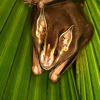

array([[[117, 112, 109],
        [121, 114, 111],
        [125, 116, 114],
        ...,
        [ 91, 102,  77],
        [ 90, 100,  76],
        [ 86,  96,  71]],

       [[117, 112, 109],
        [121, 114, 111],
        [125, 117, 114],
        ...,
        [ 90, 102,  76],
        [ 89,  99,  74],
        [ 86,  96,  71]],

       [[117, 113, 110],
        [121, 114, 111],
        [125, 117, 114],
        ...,
        [ 91, 101,  75],
        [ 88,  98,  73],
        [ 87,  97,  73]],

       ...,

       [[ 92, 123,  81],
        [100, 130,  87],
        [101, 131,  90],
        ...,
        [ 87, 115,  70],
        [ 83, 112,  71],
        [ 84, 114,  79]],

       [[ 89, 120,  78],
        [ 95, 125,  84],
        [ 94, 126,  85],
        ...,
        [ 86, 114,  69],
        [ 87, 115,  76],
        [ 89, 117,  86]],

       [[ 96, 123,  85],
        [101, 129,  91],
        [101, 130,  91],
        ...,
        [ 90, 118,  77],
        [ 84, 112,  74],
        [ 96, 121,  92]]], dtype=uint8)
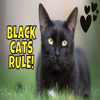

array([[[186, 188, 187],
        [186, 188, 187],
        [182, 183, 185],
        ...,
        [198, 202, 203],
        [200, 201, 203],
        [201, 202, 204]],

       [[184, 186, 185],
        [189, 191, 190],
        [191, 192, 194],
        ...,
        [204, 208, 209],
        [206, 210, 213],
        [209, 213, 216]],

       [[184, 186, 185],
        [193, 195, 194],
        [197, 198, 200],
        ...,
        [206, 211, 212],
        [208, 214, 218],
        [213, 219, 224]],

       ...,

       [[190, 186, 183],
        [189, 185, 182],
        [182, 180, 178],
        ...,
        [ 79,  43,  23],
        [ 73,  41,  24],
        [ 49,  23,  10]],

       [[190, 186, 183],
        [188, 184, 181],
        [186, 182, 179],
        ...,
        [ 69,  31,   9],
        [ 72,  35,  10],
        [ 55,  25,  12]],

       [[192, 188, 185],
        [190, 186, 183],
        [190, 186, 183],
        ...,
        [ 88,  55,  50],
        [ 68,  31,  10],
        [ 64,  31,  12]]], dtype=uint8)
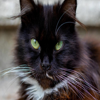

array([[[129, 118, 112],
        [132, 121, 115],
        [135, 124, 118],
        ...,
        [ 22,  29,  39],
        [ 20,  26,  40],
        [ 18,  24,  38]],

       [[128, 117, 111],
        [132, 121, 115],
        [135, 124, 118],
        ...,
        [ 21,  28,  39],
        [ 20,  26,  39],
        [ 18,  24,  38]],

       [[127, 116, 110],
        [131, 120, 114],
        [134, 123, 117],
        ...,
        [ 21,  28,  39],
        [ 19,  25,  39],
        [ 17,  23,  37]],

       ...,

       [[ 53,  42,  46],
        [ 53,  42,  46],
        [ 53,  42,  46],
        ...,
        [  2,   9,  25],
        [  3,   9,  25],
        [  3,   9,  25]],

       [[ 51,  40,  44],
        [ 52,  41,  45],
        [ 53,  42,  46],
        ...,
        [  1,   8,  24],
        [  3,   9,  25],
        [  3,   9,  25]],

       [[ 51,  40,  44],
        [ 52,  41,  45],
        [ 53,  42,  46],
        ...,
        [  1,   8,  24],
        [  3,   9,  25],
        [  3,   9,  25]]], dtype=uint8)
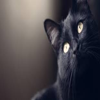

array([[[178, 164, 138],
        [178, 164, 138],
        [178, 164, 138],
        ...,
        [134, 129,  87],
        [134, 129,  87],
        [134, 129,  87]],

       [[178, 164, 138],
        [178, 164, 138],
        [178, 164, 138],
        ...,
        [134, 129,  87],
        [134, 129,  87],
        [134, 129,  87]],

       [[178, 164, 138],
        [178, 164, 138],
        [178, 164, 138],
        ...,
        [135, 130,  90],
        [135, 130,  90],
        [135, 130,  90]],

       ...,

       [[107,  60,  50],
        [106,  60,  47],
        [106,  58,  46],
        ...,
        [ 63,  48,   9],
        [ 63,  49,  12],
        [ 63,  49,  10]],

       [[104,  57,  47],
        [102,  56,  43],
        [102,  54,  42],
        ...,
        [ 59,  43,   7],
        [ 58,  44,   9],
        [ 59,  45,   8]],

       [[ 99,  52,  42],
        [ 97,  51,  38],
        [ 96,  48,  36],
        ...,
        [ 56,  40,   6],
        [ 56,  42,   7],
        [ 57,  43,   8]]], dtype=uint8)
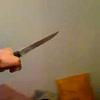

array([[[ 41,  54,  61],
        [ 60,  73,  79],
        [ 59,  73,  75],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   1,   0]],

       [[ 46,  61,  68],
        [ 55,  69,  75],
        [ 60,  74,  79],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   1,   0]],

       [[ 42,  60,  66],
        [ 40,  58,  65],
        [ 40,  55,  62],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 73,  66,  42],
        [130, 116,  87],
        [145, 124,  91],
        ...,
        [ 59,  55,  55],
        [ 46,  46,  50],
        [ 38,  39,  45]],

       [[ 61,  57,  42],
        [127, 117,  93],
        [142, 125,  91],
        ...,
        [ 96,  95,  95],
        [100, 102, 106],
        [ 79,  83,  89]],

       [[ 49,  49,  39],
        [107, 100,  79],
        [140, 125,  88],
        ...,
        [ 37,  38,  37],
        [ 72,  77,  80],
        [ 97, 102, 108]]], dtype=uint8)
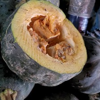

array([[[116, 124, 100],
        [ 97, 104,  85],
        [ 63,  70,  55],
        ...,
        [111, 111, 110],
        [108, 108, 108],
        [106, 106, 108]],

       [[111, 118, 102],
        [101, 107,  95],
        [ 75,  81,  71],
        ...,
        [ 87,  87,  87],
        [ 79,  79,  81],
        [ 72,  72,  74]],

       [[114, 123, 115],
        [108, 116, 111],
        [ 93, 100,  95],
        ...,
        [ 17,  17,  19],
        [ 11,  11,  14],
        [ 12,  12,  16]],

       ...,

       [[  6,   6,   6],
        [  5,   5,   5],
        [  5,   5,   5],
        ...,
        [ 36,  32,  46],
        [ 36,  33,  45],
        [ 37,  36,  44]],

       [[  6,   6,   6],
        [  5,   5,   5],
        [  5,   5,   5],
        ...,
        [ 33,  30,  41],
        [ 35,  33,  43],
        [ 34,  34,  42]],

       [[  6,   6,   6],
        [  6,   6,   6],
        [  6,   6,   6],
        ...,
        [ 32,  31,  41],
        [ 34,  33,  41],
        [ 30,  30,  36]]], dtype=uint8)
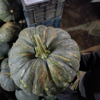

array([[[174, 174, 174],
        [117, 117, 117],
        [122, 122, 122],
        ...,
        [ 71,  69,  72],
        [ 69,  67,  71],
        [162, 162, 162]],

       [[109, 109, 109],
        [ 85,  85,  85],
        [ 91,  91,  91],
        ...,
        [ 24,  22,  26],
        [ 22,  19,  22],
        [ 76,  74,  76]],

       [[108, 108, 108],
        [ 91,  91,  91],
        [ 95,  96,  95],
        ...,
        [ 28,  26,  31],
        [ 27,  23,  28],
        [ 71,  69,  72]],

       ...,

       [[ 49,  47,  48],
        [ 23,  18,  21],
        [ 26,  22,  26],
        ...,
        [ 95,  95,  95],
        [ 90,  90,  90],
        [118, 118, 118]],

       [[ 57,  54,  55],
        [ 16,  11,  13],
        [ 20,  16,  19],
        ...,
        [ 91,  91,  91],
        [ 84,  84,  84],
        [122, 122, 122]],

       [[164, 163, 163],
        [ 91,  89,  89],
        [ 94,  93,  94],
        ...,
        [141, 141, 141],
        [137, 137, 137],
        [195, 195, 195]]], dtype=uint8)
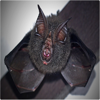

array([[[103,  50,  32],
        [109,  57,  37],
        [113,  63,  42],
        ...,
        [197, 179, 172],
        [188, 165, 161],
        [178, 153, 150]],

       [[ 53,  28,  20],
        [ 56,  29,  21],
        [ 54,  26,  17],
        ...,
        [174, 148, 139],
        [184, 154, 147],
        [186, 154, 146]],

       [[ 19,   9,   6],
        [ 22,  10,   7],
        [ 30,  15,  12],
        ...,
        [112,  88,  73],
        [137, 110,  96],
        [138, 111,  96]],

       ...,

       [[103, 129, 144],
        [113, 136, 152],
        [125, 147, 161],
        ...,
        [ 53,  63,  73],
        [ 53,  63,  73],
        [ 54,  64,  74]],

       [[103, 128, 145],
        [124, 147, 162],
        [129, 149, 164],
        ...,
        [ 50,  60,  70],
        [ 55,  65,  75],
        [ 65,  75,  85]],

       [[104, 129, 147],
        [114, 137, 153],
        [119, 138, 152],
        ...,
        [ 48,  58,  68],
        [ 63,  73,  83],
        [ 89,  99, 109]]], dtype=uint8)
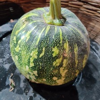

array([[[253, 253, 253],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 79,  46,  31],
        [ 74,  40,  28],
        [ 70,  36,  24]],

       [[254, 254, 254],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [ 79,  45,  33],
        [ 73,  39,  27],
        [ 68,  34,  22]],

       [[253, 255, 254],
        [253, 255, 254],
        [253, 255, 254],
        ...,
        [ 78,  44,  34],
        [ 70,  38,  27],
        [ 64,  32,  21]],

       ...,

       [[114, 107,  97],
        [111, 104,  94],
        [103,  96,  86],
        ...,
        [ 30,   8,  31],
        [ 30,   8,  31],
        [ 30,   8,  31]],

       [[114, 107,  97],
        [111, 104,  94],
        [103,  96,  86],
        ...,
        [ 30,   8,  31],
        [ 30,   8,  31],
        [ 30,   8,  31]],

       [[114, 107,  97],
        [111, 104,  94],
        [103,  96,  86],
        ...,
        [ 30,   8,  31],
        [ 30,   8,  31],
        [ 30,   8,  31]]], dtype=uint8)

array([[[ 31,  40,  39],
        [ 61,  66,  67],
        [ 41,  43,  48],
        ...,
        [143, 146, 154],
        [147, 149, 160],
        [157, 159, 171]],

       [[ 37,  42,  40],
        [ 56,  59,  61],
        [ 56,  59,  63],
        ...,
        [140, 143, 152],
        [151, 153, 164],
        [159, 161, 174]],

       [[ 42,  43,  40],
        [ 45,  46,  46],
        [ 65,  66,  70],
        ...,
        [138, 141, 150],
        [152, 155, 164],
        [162, 164, 174]],

       ...,

       [[ 94, 103, 101],
        [ 93, 100,  98],
        [ 96, 102,  98],
        ...,
        [ 37,  39,  44],
        [ 38,  40,  45],
        [ 44,  47,  52]],

       [[ 88,  96,  93],
        [ 85,  91,  87],
        [ 88,  92,  87],
        ...,
        [ 37,  38,  43],
        [ 36,  37,  42],
        [ 46,  48,  53]],

       [[ 79,  87,  83],
        [ 77,  84,  78],
        [ 71,  75,  69],
        ...,
        [ 41,  40,  46],
        [ 38,  38,  44],
        [ 39,  40,  45]]], dtype=uint8)
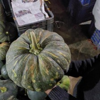

array([[[176, 119,  76],
        [176, 119,  76],
        [176, 119,  76],
        ...,
        [ 68,   3,   1],
        [ 68,   3,   1],
        [ 68,   3,   1]],

       [[177, 120,  77],
        [177, 120,  77],
        [177, 120,  77],
        ...,
        [ 67,   2,   0],
        [ 67,   2,   0],
        [ 67,   2,   0]],

       [[177, 123,  79],
        [177, 123,  79],
        [177, 123,  79],
        ...,
        [ 67,   2,   0],
        [ 67,   2,   0],
        [ 67,   2,   0]],

       ...,

       [[119,  11,   0],
        [120,  12,   0],
        [121,  13,   0],
        ...,
        [ 71,   1,   1],
        [ 71,   1,   1],
        [ 70,   0,   0]],

       [[118,  10,   0],
        [118,  10,   0],
        [119,  11,   0],
        ...,
        [ 71,   1,   1],
        [ 71,   1,   1],
        [ 70,   0,   0]],

       [[117,   9,   0],
        [117,   9,   0],
        [118,  10,   0],
        ...,
        [ 71,   1,   1],
        [ 71,   1,   1],
        [ 70,   0,   0]]], dtype=uint8)
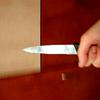

array([[[185, 173, 125],
        [191, 179, 131],
        [200, 188, 138],
        ...,
        [125,  98,  79],
        [139, 112,  91],
        [146, 119,  98]],

       [[184, 172, 124],
        [190, 178, 130],
        [199, 187, 137],
        ...,
        [127, 100,  81],
        [141, 114,  93],
        [150, 123, 102]],

       [[182, 169, 124],
        [189, 177, 129],
        [197, 185, 135],
        ...,
        [126,  99,  80],
        [140, 113,  92],
        [149, 123, 100]],

       ...,

       [[ 32,   0,  17],
        [ 32,   0,  15],
        [ 31,   0,  15],
        ...,
        [137, 102,  98],
        [132,  97,  93],
        [129,  94,  90]],

       [[ 32,   0,  17],
        [ 32,   0,  15],
        [ 31,   0,  15],
        ...,
        [124,  89,  85],
        [117,  82,  78],
        [112,  77,  73]],

       [[ 32,   0,  17],
        [ 32,   0,  15],
        [ 31,   0,  15],
        ...,
        [110,  75,  71],
        [100,  65,  61],
        [ 94,  59,  55]]], dtype=uint8)
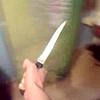

array([[[ 85,  51,  52],
        [ 84,  50,  51],
        [ 83,  48,  52],
        ...,
        [ 58,  35,  63],
        [ 55,  32,  60],
        [ 53,  30,  58]],

       [[ 83,  49,  50],
        [ 82,  48,  49],
        [ 81,  46,  50],
        ...,
        [ 57,  37,  62],
        [ 55,  32,  60],
        [ 52,  32,  57]],

       [[ 82,  46,  48],
        [ 81,  45,  47],
        [ 80,  44,  48],
        ...,
        [ 56,  38,  60],
        [ 53,  33,  58],
        [ 50,  32,  54]],

       ...,

       [[255, 250, 215],
        [255, 242, 206],
        [255, 231, 196],
        ...,
        [ 41,   0,  18],
        [ 41,   0,  18],
        [ 41,   0,  18]],

       [[255, 242, 207],
        [255, 240, 204],
        [255, 230, 195],
        ...,
        [ 41,   0,  18],
        [ 41,   0,  18],
        [ 41,   0,  18]],

       [[255, 241, 206],
        [255, 241, 205],
        [254, 228, 193],
        ...,
        [ 41,   0,  18],
        [ 41,   0,  18],
        [ 41,   0,  18]]], dtype=uint8)
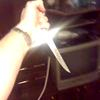

array([[[161, 190, 186],
        [160, 189, 185],
        [163, 188, 185],
        ...,
        [100,  64,  38],
        [ 97,  61,  35],
        [ 96,  60,  34]],

       [[161, 190, 186],
        [161, 190, 186],
        [163, 188, 185],
        ...,
        [102,  65,  38],
        [ 99,  62,  35],
        [ 98,  61,  34]],

       [[161, 190, 186],
        [161, 190, 186],
        [163, 188, 185],
        ...,
        [101,  60,  30],
        [ 99,  58,  28],
        [ 98,  57,  27]],

       ...,

       [[155, 133, 109],
        [129, 111,  87],
        [104,  89,  70],
        ...,
        [  1,   6,   2],
        [  6,  11,   7],
        [ 13,  18,  14]],

       [[168, 144, 118],
        [132, 112,  87],
        [ 98,  81,  61],
        ...,
        [  3,   5,   2],
        [ 11,  13,  10],
        [ 19,  21,  18]],

       [[168, 144, 116],
        [129, 108,  81],
        [ 92,  75,  55],
        ...,
        [  3,   5,   2],
        [ 12,  14,  11],
        [ 22,  24,  21]]], dtype=uint8)
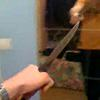

array([[[104,  77,  71],
        [114,  89,  78],
        [128, 104,  89],
        ...,
        [ 37,  19,   1],
        [ 34,  16,   2],
        [ 34,  16,   4]],

       [[ 54,  41,  39],
        [ 69,  56,  49],
        [ 86,  72,  61],
        ...,
        [ 31,  11,   0],
        [ 30,  12,   0],
        [ 28,  10,   0]],

       [[ 42,  43,  50],
        [ 37,  36,  38],
        [ 33,  28,  26],
        ...,
        [ 33,  12,   0],
        [ 35,  14,   1],
        [ 36,  16,   4]],

       ...,

       [[202, 170, 157],
        [209, 177, 166],
        [215, 183, 174],
        ...,
        [ 72,  39,  17],
        [ 70,  38,  16],
        [ 69,  36,  18]],

       [[211, 178, 166],
        [216, 184, 173],
        [217, 185, 177],
        ...,
        [ 74,  44,  21],
        [ 69,  38,  14],
        [ 67,  35,  15]],

       [[215, 181, 169],
        [218, 184, 174],
        [216, 184, 176],
        ...,
        [ 77,  47,  25],
        [ 66,  36,  11],
        [ 65,  34,  13]]], dtype=uint8)
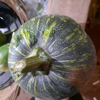

array([[[ 69,  71,  51],
        [ 60,  61,  44],
        [ 62,  62,  50],
        ...,
        [115, 111, 103],
        [116, 112, 102],
        [117, 111, 100]],

       [[100, 103,  86],
        [ 69,  72,  56],
        [ 53,  52,  43],
        ...,
        [115, 111, 104],
        [120, 116, 107],
        [119, 115, 105]],

       [[100, 105,  90],
        [ 76,  79,  67],
        [ 71,  72,  64],
        ...,
        [105, 101,  97],
        [112, 108, 102],
        [109, 105,  99]],

       ...,

       [[  6,   4,   5],
        [  4,   2,   3],
        [ 10,   8,   9],
        ...,
        [ 27,  26,  31],
        [ 34,  33,  40],
        [ 37,  36,  44]],

       [[  8,   6,   7],
        [  7,   5,   6],
        [  7,   5,   6],
        ...,
        [  6,   6,   8],
        [ 17,  16,  21],
        [ 26,  25,  32]],

       [[  8,   6,   7],
        [  8,   6,   7],
        [  8,   6,   7],
        ...,
        [  3,   3,   3],
        [  2,   2,   4],
        [  6,   5,  10]]], dtype=uint8)
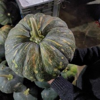

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
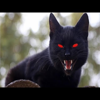

array([[[  2,   3,  10],
        [  3,   5,   9],
        [  4,   6,  11],
        ...,
        [ 43,  44,  47],
        [ 34,  35,  37],
        [ 20,  22,  21]],

       [[  1,   5,   8],
        [  2,   6,   8],
        [  1,   5,   7],
        ...,
        [ 42,  43,  45],
        [ 38,  39,  41],
        [ 22,  24,  23]],

       [[  4,   8,  10],
        [  1,   4,   6],
        [  0,   3,   4],
        ...,
        [ 32,  33,  35],
        [ 24,  26,  25],
        [ 20,  22,  21]],

       ...,

       [[  2,   1,   0],
        [  0,   1,   0],
        [ 38,  39,  26],
        ...,
        [130, 117, 119],
        [116, 108, 106],
        [128, 120, 114]],

       [[  2,   0,   2],
        [  3,   4,   1],
        [ 49,  51,  32],
        ...,
        [135, 122, 120],
        [114, 105, 105],
        [124, 114, 112]],

       [[  4,   0,   4],
        [ 11,  12,   5],
        [ 38,  41,  19],
        ...,
        [129, 116, 112],
        [108,  98,  99],
        [109,  98, 100]]], dtype=uint8)
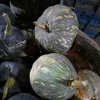

array([[[ 74,  53,  60],
        [ 72,  53,  58],
        [ 72,  56,  59],
        ...,
        [ 34,   5,   7],
        [ 52,  20,  22],
        [ 65,  26,  22]],

       [[ 81,  63,  66],
        [ 81,  64,  67],
        [ 70,  56,  58],
        ...,
        [ 46,  23,  25],
        [ 61,  35,  36],
        [ 74,  42,  37]],

       [[ 84,  68,  69],
        [ 84,  70,  71],
        [ 70,  59,  58],
        ...,
        [ 74,  58,  61],
        [ 87,  69,  69],
        [ 84,  63,  56]],

       ...,

       [[ 62,  64,  60],
        [ 49,  51,  46],
        [ 54,  58,  52],
        ...,
        [ 96, 100,  55],
        [116, 120,  77],
        [116, 117,  80]],

       [[ 60,  62,  60],
        [ 49,  51,  49],
        [ 47,  49,  45],
        ...,
        [ 91,  94,  45],
        [120, 119,  73],
        [132, 131,  90]],

       [[ 53,  57,  57],
        [ 54,  56,  55],
        [ 46,  47,  45],
        ...,
        [ 90,  93,  41],
        [113, 112,  64],
        [138, 134,  91]]], dtype=uint8)
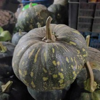

array([[[ 9, 12, 31],
        [11, 14, 33],
        [11, 14, 33],
        ...,
        [ 7,  7,  9],
        [ 7,  7,  9],
        [ 6,  6,  8]],

       [[ 9, 12, 31],
        [ 9, 12, 31],
        [13, 12, 31],
        ...,
        [ 7,  7,  9],
        [ 7,  7,  9],
        [ 7,  7,  9]],

       [[ 9, 12, 32],
        [ 9, 12, 31],
        [17, 15, 25],
        ...,
        [ 9,  9, 11],
        [ 7,  7,  9],
        [ 7,  7,  9]],

       ...,

       [[63, 55, 44],
        [63, 55, 44],
        [64, 55, 43],
        ...,
        [13,  8, 12],
        [13,  8, 12],
        [12,  7, 11]],

       [[64, 56, 45],
        [64, 56, 45],
        [63, 56, 44],
        ...,
        [12,  7, 11],
        [12,  7, 11],
        [11,  6, 10]],

       [[63, 55, 45],
        [63, 57, 44],
        [61, 55, 44],
        ...,
        [10,  8, 10],
        [10,  7, 10],
        [10,  6, 10]]], dtype=uint8)
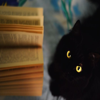

array([[[170, 162, 143],
        [168, 160, 141],
        [166, 157, 140],
        ...,
        [102,  79,  65],
        [104,  81,  67],
        [105,  82,  66]],

       [[162, 154, 135],
        [161, 153, 134],
        [160, 151, 134],
        ...,
        [106,  83,  69],
        [109,  86,  72],
        [109,  86,  70]],

       [[155, 144, 126],
        [156, 145, 127],
        [157, 145, 129],
        ...,
        [103,  80,  66],
        [108,  85,  71],
        [111,  88,  72]],

       ...,

       [[158, 135, 121],
        [158, 135, 121],
        [156, 133, 119],
        ...,
        [ 81,  30,  27],
        [ 81,  30,  27],
        [ 81,  30,  27]],

       [[158, 135, 121],
        [158, 135, 121],
        [156, 133, 119],
        ...,
        [ 80,  29,  26],
        [ 80,  29,  26],
        [ 80,  29,  26]],

       [[158, 135, 121],
        [158, 135, 121],
        [156, 133, 119],
        ...,
        [ 80,  29,  26],
        [ 80,  29,  26],
        [ 80,  29,  26]]], dtype=uint8)

array([[[ 72,  29,  39],
        [ 72,  29,  39],
        [ 72,  29,  38],
        ...,
        [ 76,  39,  47],
        [ 80,  43,  50],
        [ 86,  49,  56]],

       [[ 72,  29,  39],
        [ 72,  29,  39],
        [ 72,  29,  38],
        ...,
        [ 68,  31,  39],
        [ 70,  33,  40],
        [ 74,  37,  44]],

       [[ 71,  28,  38],
        [ 71,  28,  38],
        [ 71,  28,  37],
        ...,
        [ 45,  10,  17],
        [ 49,  14,  20],
        [ 56,  21,  27]],

       ...,

       [[255, 232, 195],
        [255, 226, 190],
        [253, 210, 178],
        ...,
        [ 45,  16,  20],
        [ 44,  15,  19],
        [ 43,  14,  18]],

       [[255, 230, 193],
        [255, 220, 184],
        [244, 201, 169],
        ...,
        [ 45,  16,  20],
        [ 44,  15,  19],
        [ 43,  14,  18]],

       [[255, 224, 187],
        [255, 220, 184],
        [244, 201, 169],
        ...,
        [ 45,  16,  20],
        [ 44,  15,  19],
        [ 43,  14,  18]]], dtype=uint8)
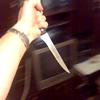

array([[[ 38,   0,   1],
        [ 43,   4,   5],
        [ 45,   6,   7],
        ...,
        [  0,  14,   0],
        [  0,  10,   0],
        [  0,   9,   0]],

       [[ 40,   1,   4],
        [ 37,   0,   0],
        [ 33,   0,   0],
        ...,
        [  1,  15,   0],
        [  0,  10,   0],
        [  0,   9,   0]],

       [[ 41,   5,   7],
        [ 33,   0,   0],
        [ 30,   0,   0],
        ...,
        [  6,  20,   5],
        [  3,  17,   2],
        [  1,  15,   0]],

       ...,

       [[168, 124,  85],
        [162, 123,  80],
        [162, 130,  81],
        ...,
        [121, 177, 138],
        [121, 177, 138],
        [121, 177, 138]],

       [[164, 122,  82],
        [158, 119,  76],
        [157, 127,  77],
        ...,
        [120, 176, 137],
        [120, 176, 137],
        [119, 175, 136]],

       [[167, 125,  85],
        [159, 122,  78],
        [157, 127,  77],
        ...,
        [116, 172, 133],
        [118, 174, 135],
        [120, 176, 137]]], dtype=uint8)

array([[[145, 150, 144],
        [141, 146, 139],
        [141, 144, 135],
        ...,
        [ 95,  42,  24],
        [ 93,  40,  24],
        [ 96,  43,  27]],

       [[146, 151, 145],
        [141, 146, 139],
        [141, 144, 135],
        ...,
        [ 96,  43,  25],
        [ 94,  41,  25],
        [ 97,  44,  28]],

       [[146, 151, 147],
        [141, 146, 140],
        [141, 144, 137],
        ...,
        [ 99,  44,  24],
        [ 97,  41,  24],
        [100,  44,  27]],

       ...,

       [[116,  98, 110],
        [114,  98, 109],
        [111,  97, 110],
        ...,
        [ 72,  74,  86],
        [ 74,  76,  88],
        [ 71,  73,  85]],

       [[115,  97, 109],
        [114,  98, 109],
        [110,  96, 109],
        ...,
        [ 72,  74,  86],
        [ 74,  76,  88],
        [ 71,  73,  85]],

       [[115,  97, 109],
        [113,  97, 108],
        [110,  96, 109],
        ...,
        [ 72,  74,  86],
        [ 74,  76,  88],
        [ 71,  73,  85]]], dtype=uint8)
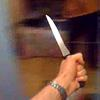

array([[[109,  96, 100],
        [108,  96, 100],
        [108,  95,  99],
        ...,
        [190, 175, 191],
        [194, 179, 195],
        [196, 179, 197]],

       [[ 79,  64,  69],
        [ 79,  63,  68],
        [ 79,  64,  69],
        ...,
        [149, 135, 144],
        [158, 141, 152],
        [169, 149, 161]],

       [[106,  89,  91],
        [102,  85,  88],
        [103,  86,  89],
        ...,
        [132, 118, 118],
        [139, 116, 120],
        [146, 116, 123]],

       ...,

       [[103, 137,  73],
        [ 32,  59,   9],
        [ 19,  36,   4],
        ...,
        [  6,   9,  14],
        [ 31,  31,  40],
        [ 54,  52,  68]],

       [[ 71,  97,  44],
        [ 28,  48,   9],
        [ 19,  32,   9],
        ...,
        [  5,   5,   8],
        [ 16,  15,  21],
        [ 37,  34,  48]],

       [[ 41,  64,  14],
        [ 33,  53,  15],
        [ 22,  34,  12],
        ...,
        [  9,   9,   9],
        [  8,   6,  10],
        [ 22,  19,  31]]], dtype=uint8)

array([[[198, 191, 165],
        [198, 191, 165],
        [198, 192, 166],
        ...,
        [ 87, 100, 116],
        [ 88, 101, 117],
        [ 88, 101, 117]],

       [[198, 191, 165],
        [198, 191, 165],
        [198, 192, 166],
        ...,
        [ 87,  96, 111],
        [ 88,  95, 113],
        [ 87,  96, 111]],

       [[198, 191, 165],
        [198, 191, 165],
        [198, 192, 168],
        ...,
        [ 74,  73,  89],
        [ 74,  71,  90],
        [ 71,  70,  86]],

       ...,

       [[185, 173, 157],
        [182, 170, 154],
        [180, 167, 151],
        ...,
        [103,  64,  69],
        [105,  66,  71],
        [105,  66,  71]],

       [[183, 171, 155],
        [181, 169, 153],
        [178, 165, 149],
        ...,
        [103,  64,  69],
        [105,  66,  71],
        [105,  66,  71]],

       [[182, 170, 154],
        [179, 167, 151],
        [177, 164, 148],
        ...,
        [103,  64,  69],
        [105,  66,  71],
        [105,  66,  71]]], dtype=uint8)
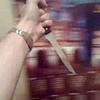

array([[[104,  14,   3],
        [104,  14,   3],
        [106,  14,   3],
        ...,
        [ 52,   1,   0],
        [ 52,   1,   0],
        [ 52,   1,   0]],

       [[104,  14,   3],
        [104,  14,   3],
        [108,  16,   5],
        ...,
        [ 52,   1,   0],
        [ 52,   1,   0],
        [ 52,   1,   0]],

       [[103,  11,   0],
        [104,  12,   1],
        [106,  14,   1],
        ...,
        [ 54,   0,   0],
        [ 54,   0,   0],
        [ 54,   0,   0]],

       ...,

       [[255, 248, 211],
        [255, 238, 200],
        [255, 228, 187],
        ...,
        [133, 144, 101],
        [132, 143, 100],
        [131, 142,  99]],

       [[255, 226, 188],
        [245, 211, 173],
        [232, 194, 155],
        ...,
        [133, 144, 101],
        [132, 143, 100],
        [131, 142,  99]],

       [[233, 199, 161],
        [214, 179, 139],
        [199, 160, 121],
        ...,
        [133, 144, 101],
        [132, 143, 100],
        [131, 142,  99]]], dtype=uint8)

array([[[ 95,  93,  77],
        [104, 102,  87],
        [149, 151, 130],
        ...,
        [127, 154, 104],
        [140, 169, 120],
        [150, 178, 132]],

       [[ 97,  98,  82],
        [111, 110,  93],
        [145, 148, 126],
        ...,
        [129, 158, 114],
        [133, 164, 115],
        [131, 162, 110]],

       [[ 93,  94,  76],
        [103, 103,  85],
        [151, 157, 133],
        ...,
        [121, 155, 107],
        [108, 139,  93],
        [ 84, 112,  69]],

       ...,

       [[ 55,  51,  67],
        [ 53,  50,  62],
        [ 36,  33,  42],
        ...,
        [108,  97,  96],
        [ 79,  73,  67],
        [136, 133, 124]],

       [[ 56,  48,  71],
        [ 66,  58,  79],
        [ 70,  63,  80],
        ...,
        [ 92,  81,  79],
        [ 47,  41,  35],
        [102,  99,  90]],

       [[ 64,  52,  80],
        [ 85,  75, 101],
        [ 87,  77, 100],
        ...,
        [ 89,  78,  76],
        [ 71,  65,  59],
        [ 32,  29,  20]]], dtype=uint8)

array([[[  5,   8,   2],
        [  4,   6,   0],
        [  4,   5,   0],
        ...,
        [ 21,  47,   3],
        [ 26,  63,   3],
        [ 52,  97,  23]],

       [[  6,   7,   1],
        [  6,   5,   0],
        [  6,   5,   0],
        ...,
        [ 41,  62,  21],
        [ 24,  57,   2],
        [ 49,  93,  21]],

       [[  3,   3,   0],
        [  2,   3,   0],
        [  6,   5,   2],
        ...,
        [ 32,  42,  16],
        [ 18,  42,   2],
        [ 52,  89,  29]],

       ...,

       [[ 72,  99,  31],
        [ 53,  80,  16],
        [ 51,  77,  18],
        ...,
        [ 74, 115, 200],
        [ 75, 116, 202],
        [ 80, 118, 201]],

       [[ 53,  79,  19],
        [ 49,  74,  17],
        [ 47,  70,  19],
        ...,
        [ 75, 115, 196],
        [ 78, 120, 203],
        [ 84, 124, 207]],

       [[ 47,  73,  18],
        [ 50,  74,  22],
        [ 47,  70,  23],
        ...,
        [ 75, 124, 204],
        [ 82, 127, 210],
        [ 89, 127, 208]]], dtype=uint8)

array([[[165, 161, 149],
        [165, 161, 149],
        [164, 161, 146],
        ...,
        [159, 144, 121],
        [159, 144, 121],
        [159, 144, 121]],

       [[165, 161, 149],
        [165, 161, 149],
        [164, 161, 146],
        ...,
        [158, 143, 120],
        [158, 143, 120],
        [158, 143, 120]],

       [[165, 161, 149],
        [165, 161, 149],
        [164, 161, 146],
        ...,
        [158, 142, 119],
        [158, 142, 119],
        [158, 142, 119]],

       ...,

       [[187, 181, 169],
        [188, 182, 170],
        [189, 183, 171],
        ...,
        [ 73,  36,  44],
        [ 77,  40,  48],
        [ 79,  42,  50]],

       [[180, 174, 162],
        [181, 175, 163],
        [184, 178, 166],
        ...,
        [ 70,  33,  41],
        [ 75,  38,  46],
        [ 77,  40,  48]],

       [[185, 179, 167],
        [186, 180, 168],
        [187, 181, 169],
        ...,
        [ 69,  32,  40],
        [ 74,  37,  45],
        [ 76,  39,  47]]], dtype=uint8)
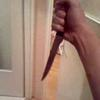

array([[[ 95,  82,  86],
        [ 98,  85,  89],
        [101,  88,  92],
        ...,
        [136,  83,  90],
        [ 99,  51,  55],
        [144,  87,  93]],

       [[ 88,  70,  76],
        [ 87,  69,  75],
        [ 85,  67,  73],
        ...,
        [132,  73,  85],
        [108,  52,  60],
        [150,  83,  92]],

       [[ 76,  56,  63],
        [ 78,  58,  65],
        [ 80,  59,  66],
        ...,
        [114,  65,  81],
        [109,  64,  74],
        [127,  71,  82]],

       ...,

       [[ 51,  67,  20],
        [ 29,  40,  12],
        [ 21,  28,  16],
        ...,
        [ 43,  41,  54],
        [ 70,  67,  84],
        [ 55,  52,  71]],

       [[ 72,  93,  32],
        [ 33,  47,  18],
        [ 46,  54,  48],
        ...,
        [ 31,  31,  41],
        [ 56,  54,  67],
        [ 64,  61,  78]],

       [[ 82, 108,  34],
        [ 50,  67,  34],
        [ 97, 106, 102],
        ...,
        [ 22,  22,  31],
        [ 48,  48,  60],
        [ 55,  53,  67]]], dtype=uint8)
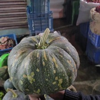

array([[[101,   6,   0],
        [101,   6,   0],
        [102,   5,   0],
        ...,
        [220, 161, 119],
        [218, 159, 117],
        [216, 157, 115]],

       [[101,   8,   0],
        [101,   8,   0],
        [102,   8,   0],
        ...,
        [226, 167, 125],
        [224, 165, 123],
        [221, 162, 120]],

       [[ 98,   8,   0],
        [ 98,   8,   0],
        [ 98,   8,   0],
        ...,
        [217, 160, 117],
        [215, 158, 115],
        [214, 157, 114]],

       ...,

       [[158, 161, 144],
        [153, 156, 139],
        [178, 180, 166],
        ...,
        [  6,  27,  10],
        [ 10,  33,  15],
        [ 10,  33,  13]],

       [[143, 146, 129],
        [158, 161, 144],
        [178, 180, 166],
        ...,
        [  5,  26,   9],
        [ 13,  36,  18],
        [ 14,  37,  17]],

       [[133, 136, 119],
        [164, 167, 150],
        [179, 181, 167],
        ...,
        [  4,  25,   8],
        [ 14,  37,  19],
        [ 16,  39,  19]]], dtype=uint8)

array([[[ 59,  71,  22],
        [128, 130,  62],
        [159, 147,  61],
        ...,
        [ 60,  71,  16],
        [ 60,  72,  20],
        [ 33,  43,  11]],

       [[ 98, 109,  45],
        [139, 140,  63],
        [166, 153,  59],
        ...,
        [ 78,  92,  32],
        [ 65,  74,  23],
        [ 30,  33,  10]],

       [[114, 123,  47],
        [145, 143,  56],
        [176, 160,  56],
        ...,
        [ 86,  96,  32],
        [ 66,  68,  23],
        [ 23,  18,   6]],

       ...,

       [[  1,   0,   5],
        [  1,   0,   0],
        [  1,   0,   0],
        ...,
        [  3,   4,   1],
        [ 41,  53,  29],
        [ 70,  90,  46]],

       [[  0,   0,   4],
        [  0,   0,   0],
        [  1,   0,   0],
        ...,
        [  4,  10,   1],
        [ 33,  47,  20],
        [ 66,  87,  45]],

       [[  1,   1,   2],
        [  1,   2,   0],
        [  2,   0,   2],
        ...,
        [  6,  14,   1],
        [ 21,  37,   8],
        [ 36,  59,  21]]], dtype=uint8)

array([[[ 39,  68,  91],
        [ 43,  69,  94],
        [ 45,  68,  94],
        ...,
        [164, 227, 252],
        [131, 214, 241],
        [ 69, 182, 224]],

       [[ 46,  72,  96],
        [ 47,  71,  96],
        [ 51,  72,  96],
        ...,
        [105, 204, 224],
        [104, 197, 217],
        [ 70, 168, 200]],

       [[ 46,  70,  96],
        [ 46,  70,  95],
        [ 51,  71,  95],
        ...,
        [ 69, 186, 205],
        [ 82, 160, 168],
        [ 85, 138, 147]],

       ...,

       [[ 29,  35,  30],
        [  4,   8,   5],
        [  0,   1,   0],
        ...,
        [ 43,  35,  41],
        [ 36,  33,  40],
        [ 31,  32,  38]],

       [[ 48,  58,  53],
        [ 27,  33,  29],
        [  7,  11,   8],
        ...,
        [ 42,  38,  43],
        [ 34,  34,  40],
        [ 27,  31,  35]],

       [[ 48,  60,  53],
        [ 39,  48,  43],
        [ 34,  40,  36],
        ...,
        [ 42,  41,  45],
        [ 35,  36,  41],
        [ 30,  35,  39]]], dtype=uint8)

array([[[ 49,  61,  75],
        [ 37,  51,  64],
        [ 33,  45,  56],
        ...,
        [ 92,  86,  84],
        [ 91,  82,  76],
        [ 94,  81,  71]],

       [[ 36,  48,  61],
        [ 28,  41,  55],
        [ 71,  83,  95],
        ...,
        [ 86,  81,  78],
        [ 88,  80,  73],
        [ 86,  75,  64]],

       [[ 33,  43,  56],
        [ 45,  58,  72],
        [137, 148, 162],
        ...,
        [ 82,  79,  74],
        [ 85,  79,  68],
        [ 86,  78,  63]],

       ...,

       [[  8,   6,   2],
        [  9,   6,   3],
        [ 11,   6,   3],
        ...,
        [ 81,  61,  63],
        [ 84,  64,  64],
        [ 93,  74,  69]],

       [[  6,   6,   3],
        [  7,   7,   5],
        [  8,   6,   6],
        ...,
        [ 94,  75,  75],
        [ 92,  72,  69],
        [101,  82,  75]],

       [[  2,   7,   3],
        [  6,   8,   7],
        [  7,   5,   7],
        ...,
        [ 98,  80,  78],
        [ 98,  79,  74],
        [105,  86,  78]]], dtype=uint8)

array([[[ 84,  54,  43],
        [114,  86,  64],
        [ 94,  67,  39],
        ...,
        [ 92,  58,  62],
        [ 74,  43,  47],
        [ 77,  49,  53]],

       [[115,  85,  71],
        [ 91,  61,  37],
        [ 86,  55,  27],
        ...,
        [ 87,  57,  57],
        [ 66,  38,  39],
        [ 75,  50,  53]],

       [[ 74,  42,  25],
        [ 79,  47,  22],
        [ 79,  44,  17],
        ...,
        [ 68,  43,  39],
        [ 64,  41,  39],
        [ 68,  49,  48]],

       ...,

       [[ 81,  65,  14],
        [ 76,  63,  15],
        [ 54,  47,   7],
        ...,
        [ 73,  37,  15],
        [ 74,  37,  16],
        [ 74,  36,  15]],

       [[ 66,  52,   6],
        [ 58,  47,   6],
        [ 35,  29,   3],
        ...,
        [ 75,  38,  14],
        [ 75,  37,  16],
        [ 75,  37,  16]],

       [[ 63,  49,   7],
        [ 47,  36,   4],
        [ 22,  16,   0],
        ...,
        [ 75,  38,  14],
        [ 76,  38,  17],
        [ 76,  38,  17]]], dtype=uint8)
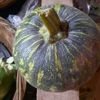

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 43,  25,  37],
        [ 65,  47,  59],
        [ 70,  52,  64]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 46,  28,  40],
        [ 67,  49,  61],
        [ 71,  53,  65]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 49,  32,  42],
        [ 68,  51,  61],
        [ 71,  54,  64]],

       ...,

       [[139, 128, 124],
        [130, 119, 115],
        [128, 117, 113],
        ...,
        [ 19,   1,  27],
        [ 19,   1,  27],
        [ 19,   1,  27]],

       [[139, 128, 124],
        [130, 119, 115],
        [128, 117, 113],
        ...,
        [ 19,   1,  27],
        [ 19,   1,  27],
        [ 19,   1,  27]],

       [[139, 128, 124],
        [130, 119, 115],
        [128, 117, 113],
        ...,
        [ 19,   1,  27],
        [ 19,   1,  27],
        [ 19,   1,  27]]], dtype=uint8)
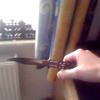

array([[[ 82,  58,  54],
        [ 81,  57,  53],
        [ 77,  56,  51],
        ...,
        [134, 130, 105],
        [134, 130, 105],
        [134, 130, 105]],

       [[ 64,  43,  38],
        [ 62,  41,  36],
        [ 62,  41,  36],
        ...,
        [128, 123, 103],
        [129, 122, 103],
        [128, 123, 103]],

       [[108,  89,  83],
        [107,  90,  83],
        [107,  90,  83],
        ...,
        [ 83,  75,  62],
        [ 84,  74,  62],
        [ 83,  75,  62]],

       ...,

       [[165, 103,  82],
        [167, 105,  84],
        [173, 108,  88],
        ...,
        [132, 122, 110],
        [132, 122, 110],
        [132, 122, 110]],

       [[178, 116,  95],
        [178, 116,  95],
        [181, 116,  96],
        ...,
        [134, 124, 112],
        [134, 124, 112],
        [134, 124, 112]],

       [[183, 121, 100],
        [182, 120,  99],
        [182, 117,  97],
        ...,
        [135, 125, 113],
        [135, 125, 113],
        [135, 125, 113]]], dtype=uint8)
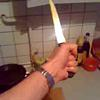

array([[[ 38,  86,   2],
        [ 54, 115,   2],
        [ 65, 129,   5],
        ...,
        [ 13,  27,   4],
        [ 14,  28,   6],
        [ 16,  29,  12]],

       [[ 30,  71,   5],
        [ 43,  99,   4],
        [ 49, 105,   2],
        ...,
        [ 14,  28,   4],
        [ 13,  27,   6],
        [ 14,  27,  11]],

       [[ 21,  54,   5],
        [ 33,  79,   3],
        [ 35,  83,   2],
        ...,
        [ 14,  29,   3],
        [ 14,  27,   6],
        [ 14,  25,   9]],

       ...,

       [[ 46, 109,   5],
        [ 42,  97,   3],
        [ 34,  80,   3],
        ...,
        [ 25,  25,  16],
        [ 16,  13,  11],
        [ 11,   7,   7]],

       [[ 47, 109,   5],
        [ 41,  95,   3],
        [ 34,  79,   3],
        ...,
        [ 20,  22,  11],
        [ 16,  15,  10],
        [ 14,  10,   7]],

       [[ 44, 101,   3],
        [ 38,  86,   1],
        [ 32,  71,   2],
        ...,
        [ 16,  19,   8],
        [ 14,  15,   9],
        [ 16,  13,  10]]], dtype=uint8)

array([[[ 46,  66,  88],
        [ 53,  68,  95],
        [ 68,  83, 115],
        ...,
        [114, 103, 104],
        [108,  99, 101],
        [ 97,  91,  92]],

       [[ 47,  66,  88],
        [ 53,  68,  94],
        [ 71,  86, 117],
        ...,
        [ 86,  75,  76],
        [ 76,  67,  71],
        [ 70,  64,  66]],

       [[ 51,  68,  89],
        [ 53,  67,  90],
        [ 72,  86, 117],
        ...,
        [ 90,  78,  81],
        [ 88,  78,  84],
        [ 89,  81,  86]],

       ...,

       [[ 35,  35,  34],
        [ 36,  36,  35],
        [ 37,  37,  36],
        ...,
        [ 15,  13,  14],
        [ 20,  18,  19],
        [ 31,  29,  30]],

       [[ 26,  26,  28],
        [ 28,  28,  29],
        [ 30,  30,  31],
        ...,
        [ 17,  15,  16],
        [ 21,  19,  20],
        [ 29,  27,  28]],

       [[ 23,  23,  25],
        [ 27,  27,  30],
        [ 29,  29,  31],
        ...,
        [ 18,  16,  17],
        [ 19,  17,  18],
        [ 28,  26,  27]]], dtype=uint8)

array([[[108, 139, 135],
        [ 89, 122, 113],
        [ 64,  99,  91],
        ...,
        [ 90,  87, 105],
        [ 39,  34,  40],
        [ 75,  66,  72]],

       [[ 77, 109,  83],
        [ 99, 131, 114],
        [121, 154, 145],
        ...,
        [ 99,  95, 112],
        [ 38,  32,  38],
        [ 69,  60,  66]],

       [[ 25,  53,   9],
        [ 43,  73,  37],
        [ 74, 105,  80],
        ...,
        [109, 103, 119],
        [ 53,  46,  52],
        [ 65,  55,  62]],

       ...,

       [[ 62, 108,  38],
        [ 68, 106,  42],
        [ 92, 116,  56],
        ...,
        [115, 129, 191],
        [112, 124, 183],
        [111, 121, 181]],

       [[ 78, 125,  46],
        [ 69, 114,  38],
        [ 74, 111,  41],
        ...,
        [114, 126, 187],
        [115, 124, 184],
        [114, 123, 180]],

       [[100, 145,  55],
        [ 81, 127,  40],
        [ 74, 121,  30],
        ...,
        [120, 130, 191],
        [113, 122, 182],
        [115, 121, 179]]], dtype=uint8)
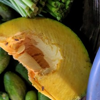

array([[[ 85,  60,  43],
        [112,  83,  66],
        [143, 110,  93],
        ...,
        [ 83,  99,  45],
        [ 85,  98,  49],
        [ 73,  87,  26]],

       [[ 53,  27,  16],
        [ 81,  51,  35],
        [128,  94,  76],
        ...,
        [115, 135,  63],
        [120, 136,  76],
        [ 70,  85,  32]],

       [[ 60,  35,  26],
        [127,  97,  78],
        [156, 123, 101],
        ...,
        [123, 143,  73],
        [107, 125,  67],
        [ 51,  66,  27]],

       ...,

       [[135, 111,  97],
        [134, 111,  97],
        [137, 115, 100],
        ...,
        [ 37,  46,  16],
        [ 92, 102,  55],
        [ 96, 108,  61]],

       [[127, 107,  93],
        [120, 102,  86],
        [119, 101,  86],
        ...,
        [ 66,  75,  34],
        [ 89,  98,  41],
        [ 73,  83,  36]],

       [[121, 104,  88],
        [112,  97,  81],
        [119, 105,  89],
        ...,
        [ 83,  91,  44],
        [ 79,  89,  24],
        [102, 111,  61]]], dtype=uint8)

array([[[  4,   3,   1],
        [  4,   3,   0],
        [  7,   2,   0],
        ...,
        [ 97, 152, 113],
        [ 85, 140, 101],
        [ 77, 132,  93]],

       [[  4,   2,   3],
        [  4,   3,   1],
        [  7,   2,   0],
        ...,
        [ 86, 141, 102],
        [ 75, 130,  91],
        [ 68, 123,  84]],

       [[  4,   2,   5],
        [  4,   2,   3],
        [  7,   1,   3],
        ...,
        [ 76, 132,  93],
        [ 66, 122,  83],
        [ 60, 116,  77]],

       ...,

       [[160, 196, 168],
        [173, 209, 181],
        [166, 202, 174],
        ...,
        [134, 161, 118],
        [133, 160, 117],
        [132, 159, 116]],

       [[153, 189, 161],
        [168, 204, 176],
        [165, 201, 173],
        ...,
        [134, 161, 118],
        [133, 160, 117],
        [132, 159, 116]],

       [[148, 184, 156],
        [166, 202, 174],
        [165, 201, 173],
        ...,
        [134, 161, 118],
        [133, 160, 117],
        [132, 159, 116]]], dtype=uint8)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 31,  17,  34],
        [ 31,  17,  34],
        [ 31,  17,  34]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 31,  17,  34],
        [ 31,  17,  34],
        [ 31,  17,  34]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 32,  17,  36],
        [ 32,  17,  36],
        [ 32,  17,  36]],

       ...,

       [[  9,  25,  76],
        [  7,  21,  70],
        [  2,  14,  62],
        ...,
        [151, 166, 171],
        [141, 149, 151],
        [136, 140, 139]],

       [[  4,  17,  69],
        [  0,  14,  63],
        [  0,   8,  56],
        ...,
        [158, 176, 180],
        [146, 156, 157],
        [136, 142, 140]],

       [[  0,  12,  64],
        [  0,   9,  58],
        [  0,   3,  52],
        ...,
        [163, 181, 185],
        [148, 158, 159],
        [135, 141, 139]]], dtype=uint8)
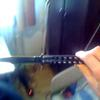

array([[[ 95,  84,  88],
        [ 89,  78,  82],
        [ 85,  74,  78],
        ...,
        [ 58,  59,  64],
        [ 52,  53,  58],
        [ 47,  48,  53]],

       [[ 99,  88,  92],
        [ 93,  82,  86],
        [ 89,  78,  82],
        ...,
        [ 55,  56,  61],
        [ 52,  53,  58],
        [ 50,  51,  56]],

       [[104,  93,  97],
        [ 98,  87,  91],
        [ 94,  83,  87],
        ...,
        [ 52,  53,  58],
        [ 52,  53,  58],
        [ 52,  53,  58]],

       ...,

       [[ 92,  82,  83],
        [ 98,  88,  89],
        [101,  91,  92],
        ...,
        [126, 116, 115],
        [106,  96,  95],
        [105,  95,  94]],

       [[ 94,  84,  84],
        [101,  91,  92],
        [112, 102, 102],
        ...,
        [117, 106, 109],
        [126, 115, 117],
        [125, 113, 116]],

       [[ 93,  83,  82],
        [102,  92,  91],
        [109,  99,  98],
        ...,
        [117, 107, 109],
        [125, 112, 114],
        [130, 115, 118]]], dtype=uint8)

array([[[212, 191, 167],
        [202, 183, 159],
        [102,  88,  65],
        ...,
        [194, 168, 156],
        [190, 167, 156],
        [178, 156, 145]],

       [[203, 184, 163],
        [105,  87,  67],
        [ 71,  57,  38],
        ...,
        [116,  82,  70],
        [130, 101,  89],
        [150, 123, 111]],

       [[ 83,  69,  51],
        [ 62,  49,  32],
        [ 54,  42,  26],
        ...,
        [109,  75,  62],
        [ 96,  63,  50],
        [ 92,  60,  47]],

       ...,

       [[148, 161, 170],
        [154, 168, 180],
        [147, 163, 178],
        ...,
        [ 33,  37,  44],
        [ 31,  38,  45],
        [ 37,  46,  53]],

       [[149, 162, 170],
        [149, 163, 175],
        [151, 167, 182],
        ...,
        [ 30,  36,  43],
        [ 30,  38,  45],
        [ 32,  40,  47]],

       [[152, 165, 173],
        [153, 167, 179],
        [151, 167, 183],
        ...,
        [ 30,  36,  44],
        [ 30,  38,  46],
        [ 35,  45,  52]]], dtype=uint8)

array([[[207, 232, 196],
        [167, 191, 150],
        [153, 177, 143],
        ...,
        [ 16,  16,  18],
        [ 17,  16,  17],
        [ 13,  22,  29]],

       [[156, 181, 132],
        [152, 173, 117],
        [135, 155,  94],
        ...,
        [ 18,  18,  18],
        [ 60,  57,  54],
        [ 86,  88,  86]],

       [[160, 173, 126],
        [154, 161, 103],
        [151, 154,  83],
        ...,
        [ 48,  46,  46],
        [134, 126, 121],
        [147, 136, 127]],

       ...,

       [[ 37,  28,  28],
        [ 55,  49,  48],
        [  9,   6,   7],
        ...,
        [110, 102,  72],
        [123, 116,  87],
        [110, 104,  79]],

       [[ 12,   6,   8],
        [ 20,  18,  18],
        [  5,   6,   7],
        ...,
        [107,  96,  68],
        [113, 103,  78],
        [104,  96,  77]],

       [[  7,   3,   7],
        [ 11,  10,  12],
        [  4,   7,   9],
        ...,
        [100,  88,  62],
        [110,  98,  76],
        [108,  98,  83]]], dtype=uint8)

array([[[ 95, 143, 119],
        [ 97, 143, 117],
        [103, 142, 113],
        ...,
        [ 66, 124,  84],
        [ 59, 120,  79],
        [ 51, 112,  71]],

       [[ 96, 141, 118],
        [ 97, 141, 116],
        [102, 141, 112],
        ...,
        [ 63, 121,  81],
        [ 57, 115,  75],
        [ 50, 108,  68]],

       [[ 99, 143, 118],
        [100, 143, 116],
        [103, 142, 113],
        ...,
        [ 64, 119,  80],
        [ 57, 112,  73],
        [ 50, 106,  67]],

       ...,

       [[127, 162, 132],
        [110, 145, 115],
        [ 95, 128,  99],
        ...,
        [ 74, 112,  73],
        [ 72, 110,  71],
        [ 72, 110,  71]],

       [[111, 146, 116],
        [ 93, 128,  98],
        [ 76, 109,  80],
        ...,
        [ 74, 112,  73],
        [ 72, 110,  71],
        [ 72, 110,  71]],

       [[100, 135, 105],
        [ 82, 117,  87],
        [ 65,  98,  69],
        ...,
        [ 74, 112,  73],
        [ 72, 110,  71],
        [ 72, 110,  71]]], dtype=uint8)

array([[[196, 169, 141],
        [179, 152, 123],
        [154, 127,  98],
        ...,
        [115, 132,  48],
        [163, 178, 108],
        [202, 215, 162]],

       [[145, 116,  97],
        [134, 106,  85],
        [128,  99,  78],
        ...,
        [147, 161,  84],
        [180, 195, 129],
        [210, 224, 171]],

       [[183, 155, 138],
        [176, 147, 131],
        [161, 132, 116],
        ...,
        [173, 185, 117],
        [194, 207, 148],
        [215, 228, 181]],

       ...,

       [[120, 102,  92],
        [115,  96,  84],
        [116,  95,  81],
        ...,
        [147, 125, 105],
        [ 97,  81,  69],
        [ 11,   3,   0]],

       [[120, 100,  93],
        [106,  87,  77],
        [106,  90,  76],
        ...,
        [143, 120, 100],
        [ 88,  74,  63],
        [ 15,  11,   7]],

       [[114,  94,  89],
        [104,  87,  78],
        [108,  97,  83],
        ...,
        [138, 114,  94],
        [ 82,  68,  59],
        [ 24,  22,  16]]], dtype=uint8)

array([[[ 70,  50,  23],
        [ 80,  60,  33],
        [107,  83,  57],
        ...,
        [145,  95,  44],
        [154, 104,  53],
        [170, 120,  69]],

       [[ 81,  61,  34],
        [ 93,  72,  45],
        [120,  96,  70],
        ...,
        [147,  97,  46],
        [156, 106,  55],
        [172, 122,  71]],

       [[ 94,  73,  44],
        [107,  86,  57],
        [134, 110,  82],
        ...,
        [150, 100,  47],
        [158, 108,  55],
        [175, 125,  72]],

       ...,

       [[171, 155, 142],
        [171, 155, 142],
        [169, 155, 142],
        ...,
        [ 46,  12,  10],
        [ 46,  12,  10],
        [ 45,  11,   9]],

       [[171, 155, 142],
        [171, 155, 142],
        [169, 155, 142],
        ...,
        [ 46,  12,  10],
        [ 46,  12,  10],
        [ 46,  12,  10]],

       [[171, 155, 142],
        [171, 155, 142],
        [169, 155, 142],
        ...,
        [ 47,  13,  11],
        [ 46,  12,  10],
        [ 46,  12,  10]]], dtype=uint8)
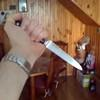

array([[[ 48,   7,   5],
        [ 43,   5,   2],
        [ 40,   7,   0],
        ...,
        [ 95, 152, 107],
        [ 96, 153, 108],
        [ 97, 154, 109]],

       [[ 42,   4,   1],
        [ 39,   4,   0],
        [ 37,   7,   0],
        ...,
        [ 93, 150, 105],
        [ 93, 150, 105],
        [ 94, 151, 106]],

       [[ 30,   3,   0],
        [ 32,   5,   0],
        [ 36,   7,   0],
        ...,
        [ 91, 148, 103],
        [ 91, 148, 103],
        [ 91, 148, 103]],

       ...,

       [[133,  47,   0],
        [132,  43,   0],
        [132,  40,   0],
        ...,
        [105,  16,   2],
        [104,  15,   1],
        [104,  15,   1]],

       [[134,  46,   0],
        [132,  43,   0],
        [132,  40,   0],
        ...,
        [104,  15,   1],
        [104,  15,   1],
        [104,  15,   1]],

       [[134,  46,   0],
        [132,  43,   0],
        [133,  40,   0],
        ...,
        [104,  15,   1],
        [104,  15,   1],
        [103,  14,   0]]], dtype=uint8)
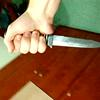

array([[[ 60,  59,  65],
        [ 49,  46,  51],
        [ 38,  33,  34],
        ...,
        [167, 160, 178],
        [168, 161, 179],
        [157, 150, 168]],

       [[ 50,  27,  31],
        [ 39,  19,  21],
        [ 22,   6,   7],
        ...,
        [172, 165, 181],
        [173, 166, 182],
        [171, 165, 180]],

       [[ 80,  37,  38],
        [ 81,  45,  45],
        [ 69,  44,  45],
        ...,
        [170, 164, 179],
        [171, 165, 179],
        [166, 160, 174]],

       ...,

       [[ 78,  80,  79],
        [ 77,  79,  78],
        [ 75,  77,  75],
        ...,
        [ 81,  67,  61],
        [ 42,  33,  29],
        [ 12,   7,   4]],

       [[ 79,  81,  80],
        [ 75,  77,  78],
        [ 70,  73,  74],
        ...,
        [ 33,  22,  18],
        [ 18,  11,  12],
        [  9,   4,   8]],

       [[ 84,  85,  85],
        [ 79,  80,  82],
        [ 69,  74,  77],
        ...,
        [ 36,  29,  26],
        [ 18,  13,  15],
        [ 17,  12,  19]]], dtype=uint8)
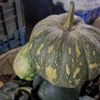

array([[[  1,   5,   8],
        [  3,  17,   0],
        [  4,  22,   7],
        ...,
        [ 46,  23,   6],
        [ 50,  26,  13],
        [ 51,  27,  16]],

       [[ 38,  44,  53],
        [  4,  16,  14],
        [  0,  14,   8],
        ...,
        [ 48,  25,   9],
        [ 53,  30,  15],
        [ 57,  33,  21]],

       [[141, 151, 161],
        [ 80,  92, 106],
        [  7,  20,  22],
        ...,
        [ 45,  24,  11],
        [ 51,  27,  14],
        [ 57,  31,  19]],

       ...,

       [[ 33,  38,  70],
        [ 29,  34,  66],
        [ 26,  30,  63],
        ...,
        [101,  95, 101],
        [106,  97, 102],
        [104,  93,  97]],

       [[ 32,  37,  69],
        [ 28,  33,  65],
        [ 21,  26,  58],
        ...,
        [102,  96, 101],
        [111, 103, 106],
        [107,  96, 100]],

       [[ 27,  32,  64],
        [ 22,  27,  59],
        [ 22,  27,  59],
        ...,
        [100,  94,  99],
        [108,  99, 103],
        [109,  99, 101]]], dtype=uint8)

array([[[ 53,  68,  26],
        [ 47,  63,  20],
        [ 78,  95,  52],
        ...,
        [ 53,  69,  39],
        [ 34,  50,  20],
        [ 57,  74,  42]],

       [[ 57,  75,  25],
        [ 64,  82,  34],
        [ 66,  83,  38],
        ...,
        [ 55,  70,  38],
        [ 40,  56,  24],
        [ 54,  70,  38]],

       [[ 64,  85,  29],
        [ 74,  94,  42],
        [ 67,  84,  39],
        ...,
        [ 61,  75,  43],
        [ 42,  57,  25],
        [ 35,  50,  16]],

       ...,

       [[130, 132, 120],
        [136, 139, 129],
        [144, 147, 140],
        ...,
        [136, 118, 119],
        [100,  87,  90],
        [125, 114, 118]],

       [[132, 133, 123],
        [141, 143, 135],
        [150, 152, 146],
        ...,
        [103,  84,  75],
        [ 45,  28,  23],
        [ 60,  45,  44]],

       [[138, 136, 127],
        [141, 141, 132],
        [141, 143, 136],
        ...,
        [ 86,  68,  53],
        [ 46,  29,  20],
        [ 49,  33,  30]]], dtype=uint8)

array([[[ 62,  59,  69],
        [ 63,  61,  70],
        [ 48,  49,  56],
        ...,
        [165, 147, 158],
        [147, 125, 138],
        [116,  97, 111]],

       [[ 56,  56,  61],
        [ 66,  68,  73],
        [ 54,  58,  62],
        ...,
        [123, 102, 114],
        [107,  85,  97],
        [101,  81,  92]],

       [[ 41,  44,  47],
        [ 69,  73,  76],
        [ 61,  66,  69],
        ...,
        [ 98,  76,  87],
        [ 82,  61,  69],
        [ 80,  60,  67]],

       ...,

       [[118, 120,  96],
        [127, 131, 102],
        [126, 133, 101],
        ...,
        [ 11,  10,  15],
        [ 16,  15,  20],
        [ 24,  23,  28]],

       [[129, 133, 105],
        [123, 128,  98],
        [131, 140, 110],
        ...,
        [ 17,  16,  21],
        [ 14,  13,  18],
        [ 21,  20,  25]],

       [[140, 144, 116],
        [133, 140, 110],
        [117, 127, 100],
        ...,
        [ 20,  19,  24],
        [ 19,  18,  23],
        [ 20,  19,  24]]], dtype=uint8)
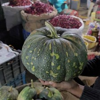

array([[[ 58,  58,  62],
        [ 79,  83,  86],
        [ 20,  25,  28],
        ...,
        [169, 171, 184],
        [174, 176, 189],
        [174, 176, 189]],

       [[ 43,  43,  48],
        [ 67,  70,  73],
        [ 23,  28,  31],
        ...,
        [171, 173, 186],
        [172, 174, 187],
        [178, 180, 193]],

       [[ 41,  39,  44],
        [ 69,  71,  75],
        [ 39,  44,  47],
        ...,
        [175, 177, 190],
        [173, 175, 188],
        [170, 172, 185]],

       ...,

       [[ 77,  78,  75],
        [ 91,  94,  90],
        [ 71,  76,  69],
        ...,
        [ 21,  20,  27],
        [ 34,  32,  42],
        [ 37,  35,  48]],

       [[ 66,  67,  58],
        [ 70,  73,  63],
        [ 62,  67,  56],
        ...,
        [ 15,  14,  20],
        [ 26,  25,  33],
        [ 35,  33,  43]],

       [[ 61,  63,  51],
        [ 62,  65,  51],
        [ 63,  67,  54],
        ...,
        [ 27,  26,  32],
        [ 32,  31,  39],
        [ 37,  35,  46]]], dtype=uint8)

array([[[ 81,  91, 105],
        [ 68,  74,  93],
        [ 66,  68,  84],
        ...,
        [ 65,  57,  64],
        [ 67,  56,  62],
        [ 68,  56,  60]],

       [[ 71,  83,  98],
        [ 69,  76,  96],
        [ 80,  83, 101],
        ...,
        [ 47,  41,  47],
        [ 54,  45,  50],
        [ 58,  48,  52]],

       [[ 79,  93, 112],
        [ 86,  97, 118],
        [ 96, 102, 121],
        ...,
        [ 47,  43,  49],
        [ 40,  34,  38],
        [ 50,  43,  47]],

       ...,

       [[  8,  10,   4],
        [  8,  10,   7],
        [  8,  10,  10],
        ...,
        [104,  94,  95],
        [ 18,  11,   8],
        [ 14,   7,   0]],

       [[  9,  10,   4],
        [  9,  11,   7],
        [  9,  11,  11],
        ...,
        [122, 109, 114],
        [ 80,  68,  66],
        [ 22,  10,   4]],

       [[ 11,  12,   4],
        [ 11,  12,   8],
        [ 10,  12,  12],
        ...,
        [122, 105, 115],
        [118, 102, 105],
        [ 51,  35,  32]]], dtype=uint8)
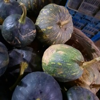

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_images = pd.read_pickle('/content/selected_images.pkl')
# X = StandardScaler().fit_transform(selected_images)

# n_samples = len(selected_images)
selected_images_reshaped = np.array([img.flatten() for img in selected_images])

pca = PCA(n_components=2)
data_pca = pca.fit_transform(selected_images_reshaped)

plt.figure(figsize=(8, 6))
# scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.7)
# plt.title("PCA of Selected Images Dataset")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.show()

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(selected_images_reshaped)

plt.figure(figsize=(8, 6))
# scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.7)
# plt.title("t-SNE of Selected Images Dataset")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_pca)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("K-means Clustering of Selected Images Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
# plt.legend(*scatter.legend_elements(), title="Class")
# plt.title("K-means Clustering of Selected Images Dataset")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.show()

clusters = {}
for i, label in enumerate(labels):
  if label not in clusters:
    clusters[label] = []
  clusters[label].append(selected_images[i])


print("\nData points in each cluster:")
for cluster_id, points in clusters.items():
  print(f"Cluster {cluster_id}:")
  print("##################################################")
  for point in points:
    display(point)
# for i in range(len(input)):
  # display(input[i])

# tem 4 classes no total

#https://www.kaggle.com/datasets/marcosvolpato/edible-and-poisonous-fungi/data

# DESAFIO! (Opcional)

Sem desafio hoje, Feliz Halloween!

E até a próxima, esse foi o último Laboratório :(